# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars due to lane misalignment.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

**ADD IMAGE OF PINHOLE MODEL**

**ADD IMAGE OF CHESSBOARD CORNERS FINDING**

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

In [3]:
def load_image(path, to_rgb=True):
    img = cv2.imread(path)
    return img if not to_rgb else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to show us a list of traffic sign images
    """
    #img_count = len(img_list)
    #rows = img_count // cols
    rows = len(img_list)
    cmap = None
    
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, rows):
        for j in range(0, cols):
            ax = axes[i, j] if rows > 1 else axes[j]
            #k = i * cols + j
            img_name = img_labels[i][j]   
            img = img_list[i][j]
            if len(img.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"
                img = np.reshape(img, (img.shape[0], img.shape[1]))

            if not show_ticks:            
                ax.axis("off")

            ax.imshow(img, cmap=cmap)
            ax.set_title(img_name)
                
    fig.suptitle(title, fontsize=12, fontweight='bold', y = 1)
    fig.tight_layout()
    plt.show()
    
    return

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [5]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

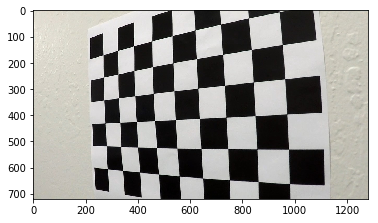

In [7]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [8]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [9]:
def to_grayscale(img):
    """
    Returns the grayscaled version of the supplied image (in RGB format)
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [10]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [11]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

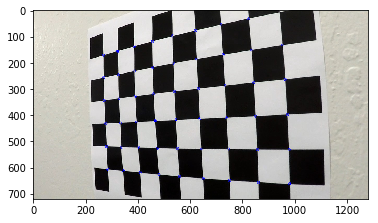

In [12]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [13]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [14]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [15]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [16]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [17]:
test_img_path = test_imgs_paths[5]
test_img = load_image(test_img_path)

In [18]:
undistorted_test_img = undistort_image(test_img, opts, ipts)

In [19]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [20]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [21]:
undist_test_img_names

array(['undistorted_test5', 'undistorted_straight_lines1',
       'undistorted_test1', 'undistorted_test6', 'undistorted_test2',
       'undistorted_straight_lines2', 'undistorted_test4',
       'undistorted_test3'], 
      dtype='<U27')

In [22]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

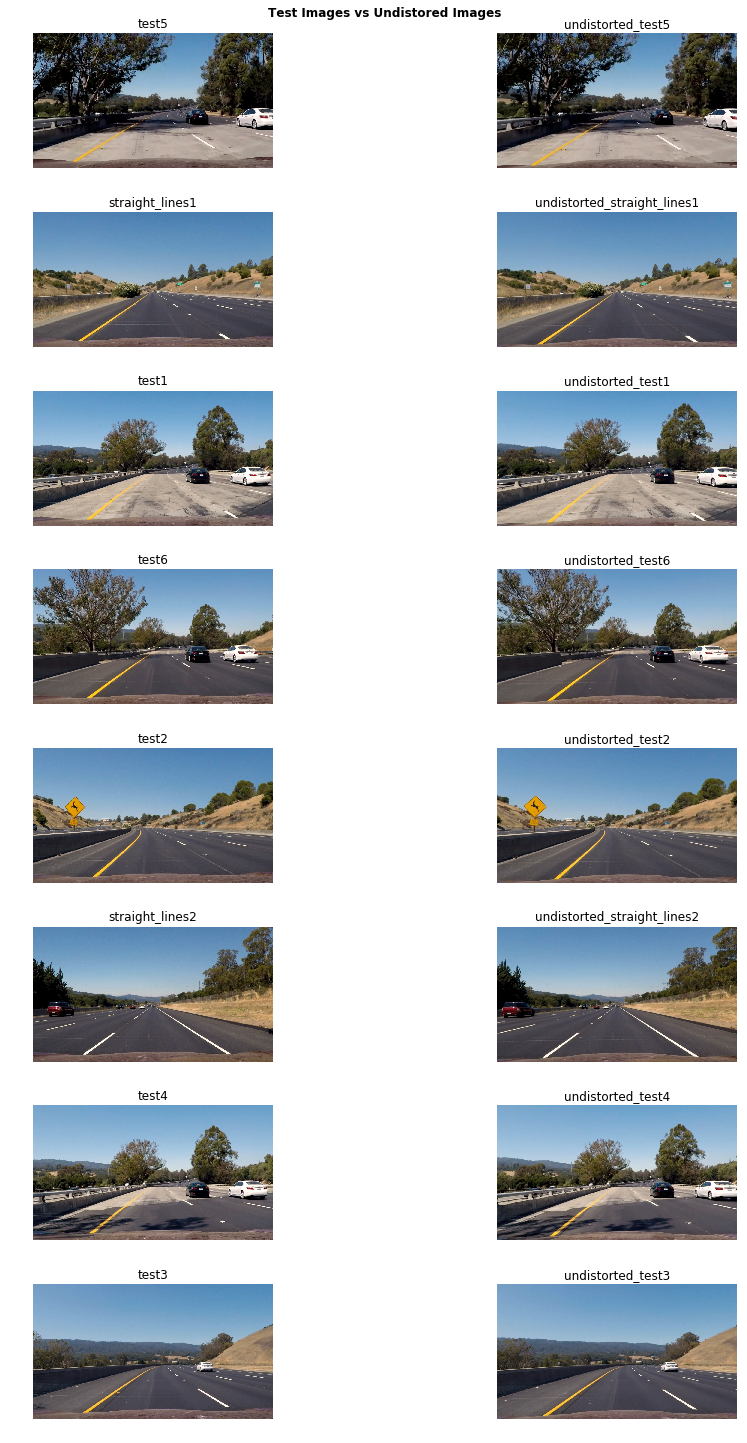

In [23]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(15, 20), cols=2, show_ticks=False)

The sample above shows original next to undistored images.

## Thresholding

We apply edge and color thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

#### Sobel In X or Y Directions

In [24]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [25]:
undist_test_img_gray = to_grayscale(undistorted_test_img)

In [26]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [27]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

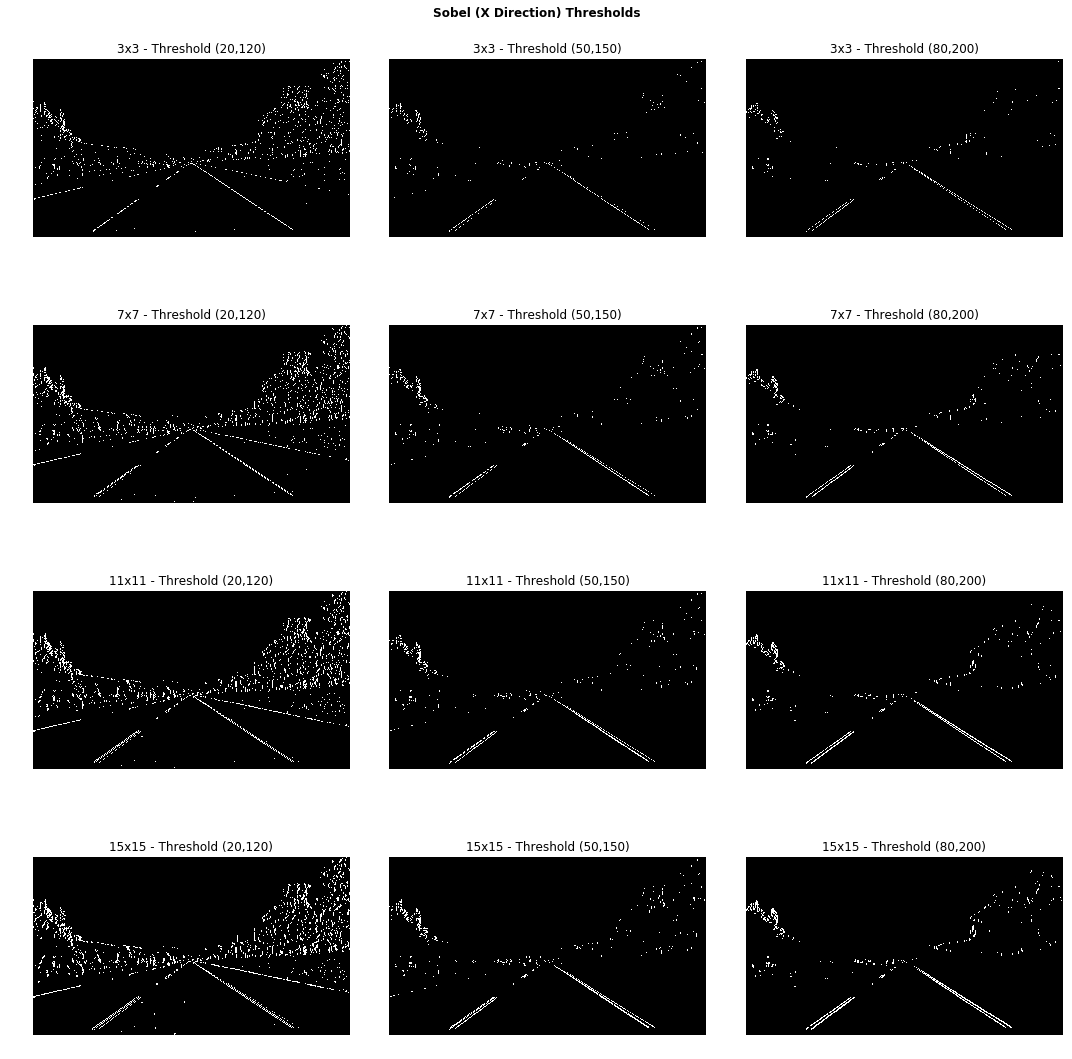

In [28]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [29]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

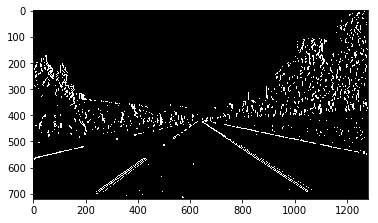

In [31]:
plt.imshow(sobx_best, cmap='gray')

In [32]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [33]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

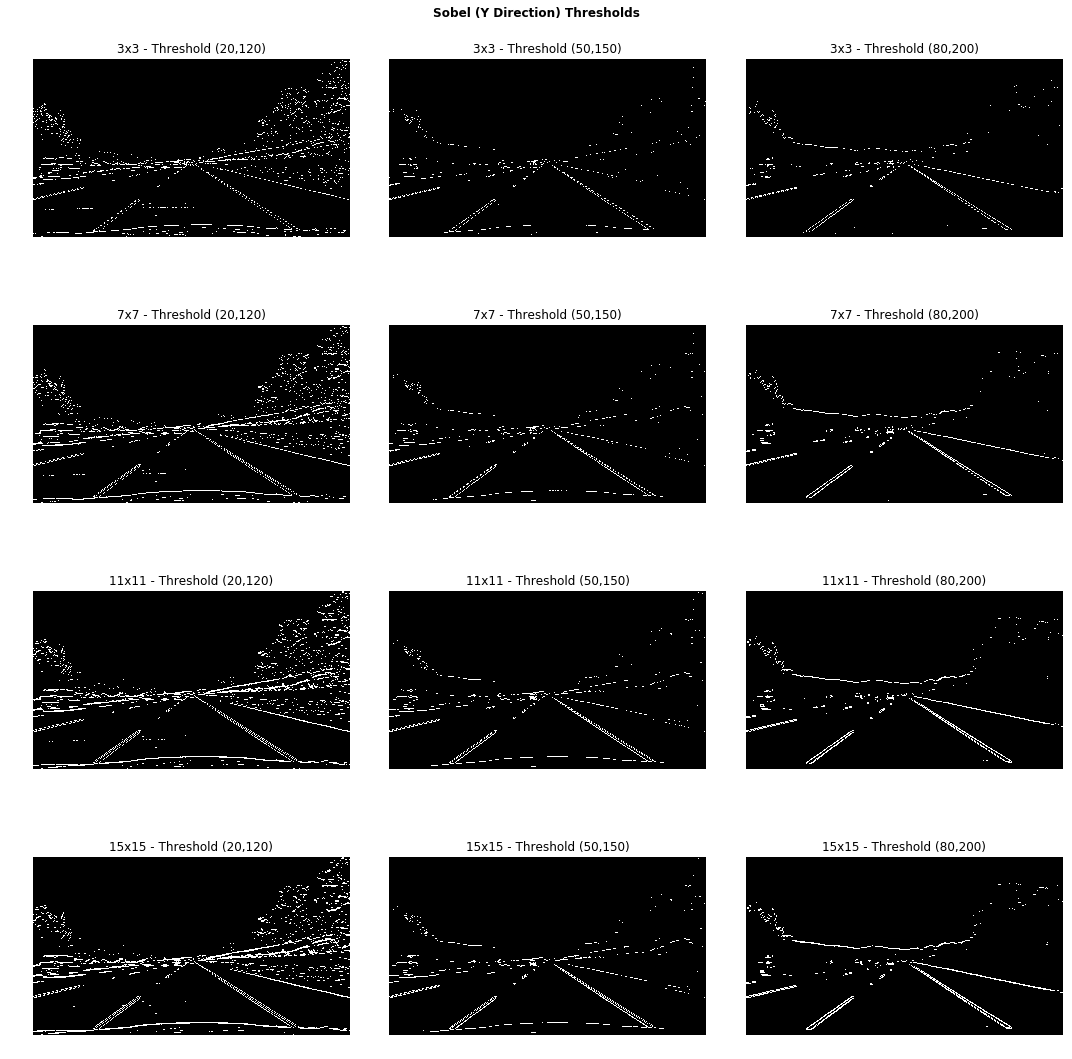

In [34]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [36]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

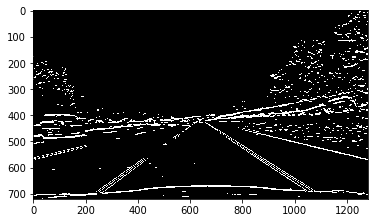

In [37]:
plt.imshow(soby_best, cmap='gray')

#### Sobel Magnitude in X and Y Directions

In [38]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [40]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [41]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


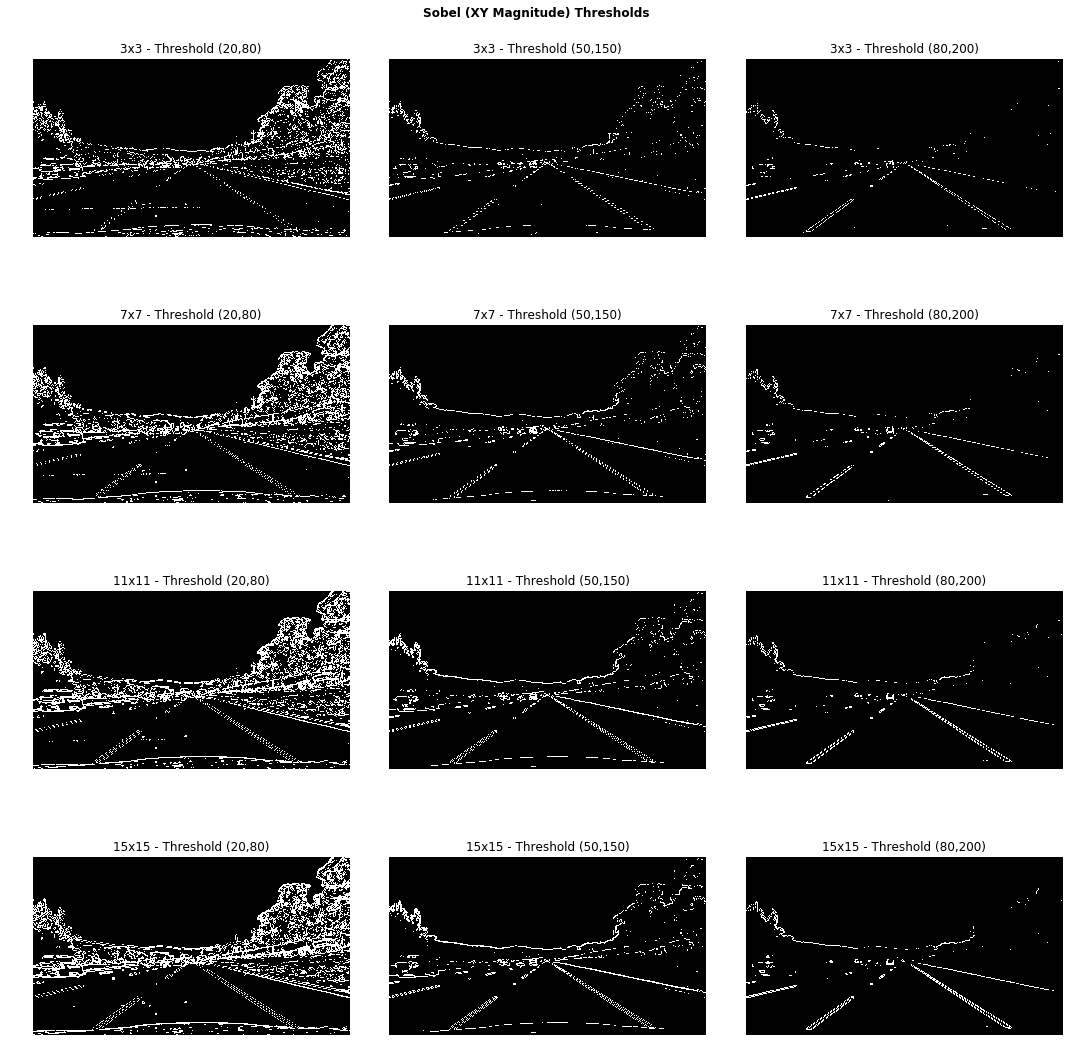

In [42]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [44]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

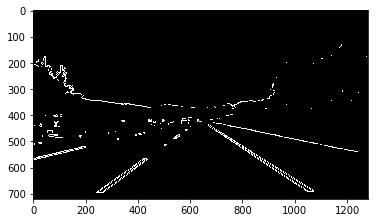

In [45]:
plt.imshow(sobxy_best, cmap='gray')

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [46]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [739]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels
    #combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    combined[((sx_binary == 1)) | ((sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [48]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [49]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [50]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))



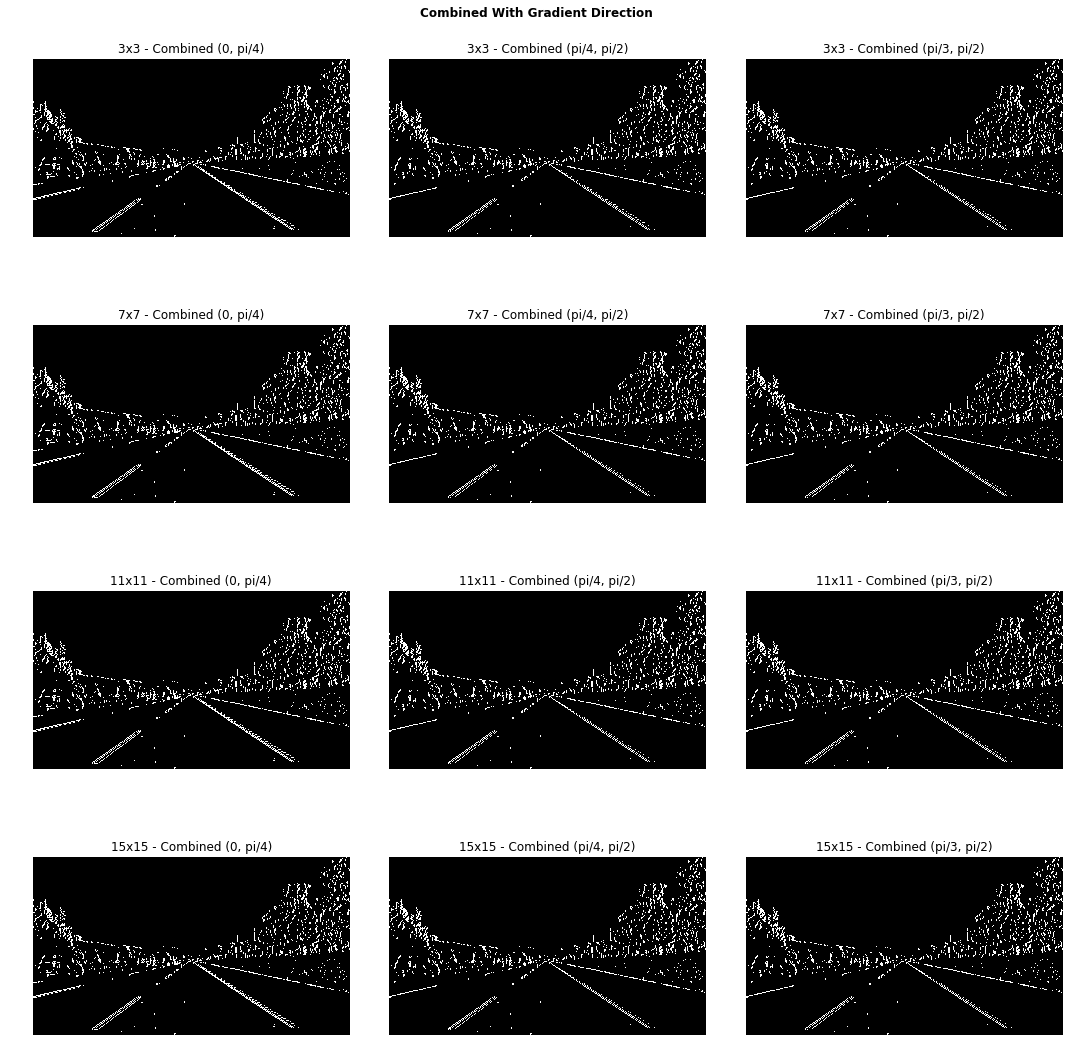

In [51]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [52]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. However, we can see that some lanes are not fully identified, due to shadows obscuring the image. We turn to color space manipulation in order to better isolate the yellow and white lines.

### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [497]:
def to_hsv(img):
    """
    Returns the same image in HSV format
    The input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    

In [53]:
def to_hls(img):
    """
    Returns the same image in HLS format
    The input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [54]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [55]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [56]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [714]:
hsv_test_img = to_hsv(undist_test_imgs[7])
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [715]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs))

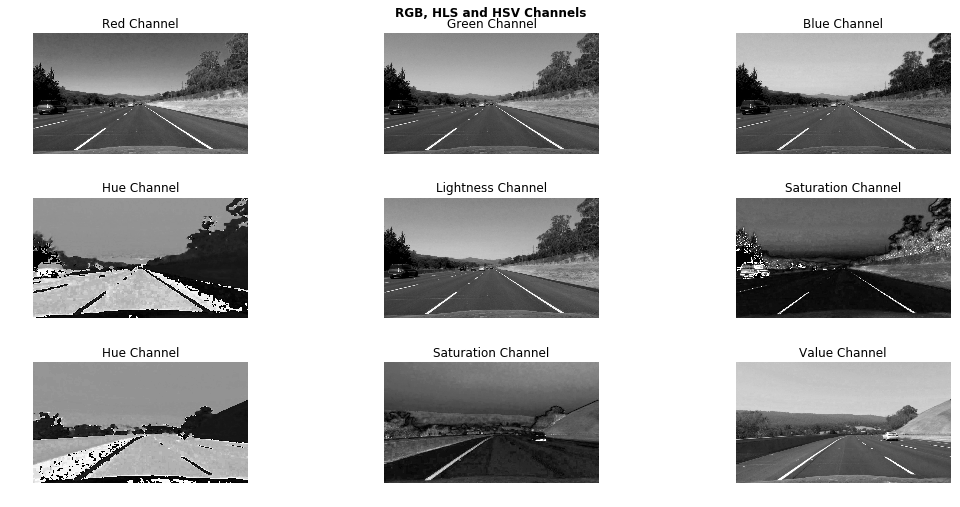

In [716]:
show_image_list(color_spaces_comps, color_spaces_lbs, "RGB, HLS and HSV Channels", cols=3, fig_size=(15, 7), show_ticks=False)

On the RGB components, we see that the blue channel gives the least clarity on the lines, while the red channel seems to give best results.

For HSL, the hue channel produces an extremely noisy output, while the saturation channel seems to give the best results. **The saturation channel in fact seems to produce the best contrast** so we will therefore focus on trying different thresholds for this channel.

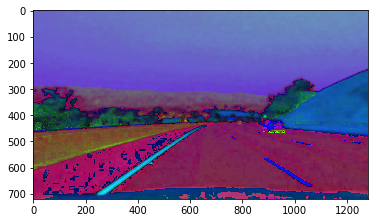

In [510]:
plt.imshow(hsv_test_img)

In [515]:
hsv_test_img_bin = np.zeros_like(hsv_test_img[:,:,0])
hsv_test_img_bin[(hsv_test_img[:,:,0] >= 15) & (hsv_test_img[:,:,0] <= 35) ] = 1

#hsv_test_img_bin2 = np.zeros_like(hsv_test_img[:,:,0])
#hsv_test_img_bin2[(hsv_test_img[:,:,0] >= 28) & (hsv_test_img[:,:,0] <= 43) ] = 1

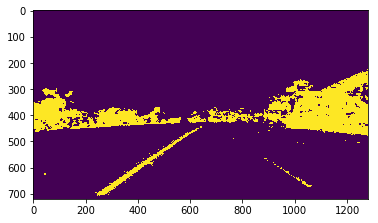

In [516]:
plt.imshow(hsv_test_img_bin)

In [ ]:
hsv_h_thres_1 = np.asarray([[threshold_img(hlv_test_img, 0, thres=(0, 85)), threshold_img(hls_test_img, 2, thres=(85, 170)), threshold_img(hls_test_img, 2, thres=(170, 255))]])
hsv_h_lbs_1 = np.asarray([["S Thresold (0,85)", "S Thresold (85,170)", "S Thresold (170,255)"]])

hls_s_thres_2 = np.asarray([[threshold_img(hls_test_img, 2, thres=(50, 100)), threshold_img(hls_test_img, 2, thres=(100, 150)), threshold_img(hls_test_img, 2, thres=(150, 255))]])
hls_s_lbs_2 = np.asarray([["S Thresold (50,100)", "S Thresold (100,150)", "S Thresold (150,255)"]])

In [ ]:
hls_s_thres = np.concatenate((hls_s_thres_1, hls_s_thres_2))
hls_s_lbs = np.concatenate((hls_s_lbs_1, hls_s_lbs_2))

In [ ]:
show_image_list(hls_s_thres, hls_s_lbs, "HLS - S Thresholds", cols=3, fig_size=(15, 7), show_ticks=False)

In [523]:
hls_test_img = to_hls(undist_test_imgs[7])

In [528]:
hls_test_img_yellow_bin = np.zeros_like(hls_test_img[:,:,0])
hls_test_img_yellow_bin[((hls_test_img[:,:,0] >= 15) & (hls_test_img[:,:,0] <= 35))
                 & ((hls_test_img[:,:,1] >= 38) & (hls_test_img[:,:,1] <= 204))
                 & ((hls_test_img[:,:,2] >= 115) & (hls_test_img[:,:,2] <= 255))                
                ] = 1


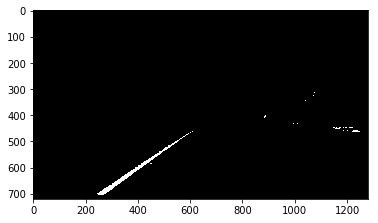

In [542]:
plt.imshow(hls_test_img_yellow_bin, cmap='gray')

In [ ]:
 low_threshold = np.array([0, 200, 0], dtype=np.uint8)
    # Higher value equivalent pure HSL is (360, 100, 100)
    high_threshold = np.array([180, 255, 255], dtype=np.uint8)  

In [632]:
hls_test_img_white_bin = np.zeros_like(hls_test_img[:,:,0])
hls_test_img_white_bin[((hls_test_img[:,:,0] >= 0) & (hls_test_img[:,:,0] <= 255))
                 & ((hls_test_img[:,:,1] >= 200) & (hls_test_img[:,:,1] <= 255))
                 & ((hls_test_img[:,:,2] >= 0) & (hls_test_img[:,:,2] <= 255))                
                ] = 1


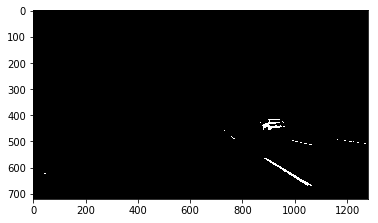

In [633]:
plt.imshow(hls_test_img_white_bin, cmap='gray')

In [634]:
hls_test_white_yellow_bin = np.zeros_like(hls_test_img_white_bin)
hls_test_white_yellow_bin[(hls_test_img_yellow_bin == 1) | (hls_test_img_white_bin == 1)] = 1

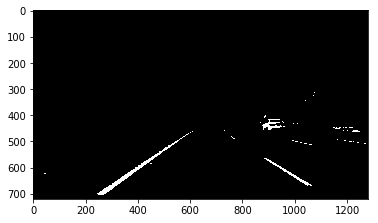

In [635]:
plt.imshow(hls_test_white_yellow_bin, cmap='gray')

In [641]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 38) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

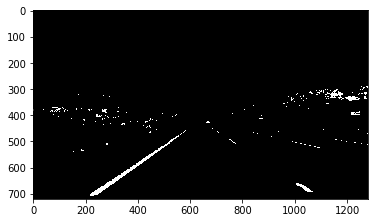

In [642]:
best_hls = compute_hls_white_yellow_binary(undist_test_imgs[1])
plt.imshow(best_hls, cmap='gray')

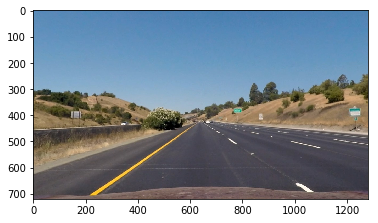

In [640]:
plt.imshow(undist_test_imgs[1])

In [ ]:
low_threshold = np.array([15, 38, 115], dtype=np.uint8)
    # Higher value equivalent pure HSL is (75, 100, 80)
high_threshold = np.array([35, 204, 255], dtype=np.uint8)  

In [59]:
hls_s_thres_1 = np.asarray([[threshold_img(hls_test_img, 2, thres=(0, 85)), threshold_img(hls_test_img, 2, thres=(85, 170)), threshold_img(hls_test_img, 2, thres=(170, 255))]])
hls_s_lbs_1 = np.asarray([["S Thresold (0,85)", "S Thresold (85,170)", "S Thresold (170,255)"]])

hls_s_thres_2 = np.asarray([[threshold_img(hls_test_img, 2, thres=(50, 100)), threshold_img(hls_test_img, 2, thres=(100, 150)), threshold_img(hls_test_img, 2, thres=(150, 255))]])
hls_s_lbs_2 = np.asarray([["S Thresold (50,100)", "S Thresold (100,150)", "S Thresold (150,255)"]])


In [60]:
hls_s_thres = np.concatenate((hls_s_thres_1, hls_s_thres_2))
hls_s_lbs = np.concatenate((hls_s_lbs_1, hls_s_lbs_2))

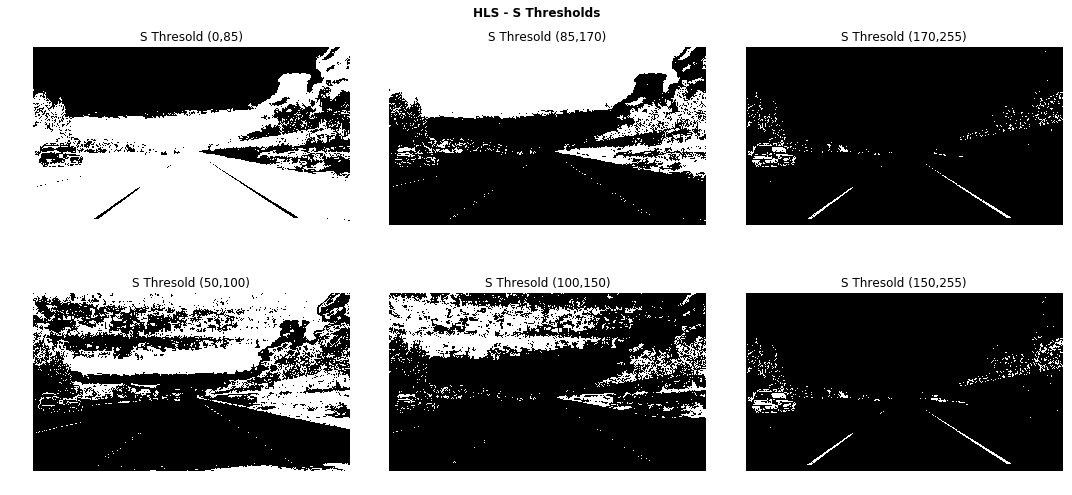

In [61]:
show_image_list(hls_s_thres, hls_s_lbs, "HLS - S Thresholds", cols=3, fig_size=(15, 7), show_ticks=False)


We seem to obtain the best results with thresholding on the saturation channel with values in the interval _[150,255]_. We will use this interval going forward.

In [62]:
hls_s_binary_best = threshold_img(hls_test_img, 2, thres=(150, 255))

### Combining Color And Gradient (Sobel) Thresholds

In [63]:
color_binary = np.dstack((np.zeros_like(hls_s_binary_best), sobel_combined_best, hls_s_binary_best)) * 255
color_binary = color_binary.astype(np.uint8)

In [64]:
combined_binary = np.zeros_like(hls_s_binary_best)
combined_binary[(sobel_combined_best == 1) | (hls_s_binary_best == 1)] = 1

In [65]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined S And Gradient Thresholds"]])

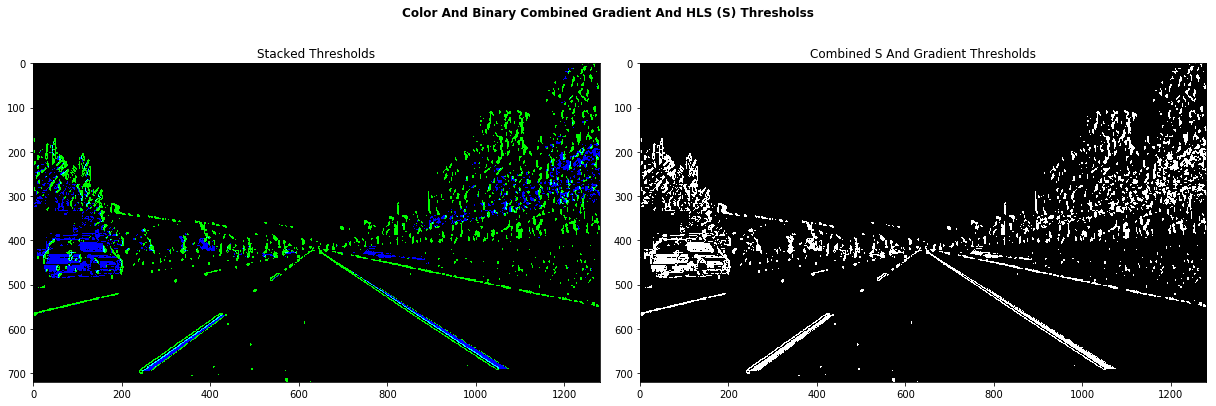

In [66]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=True)

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

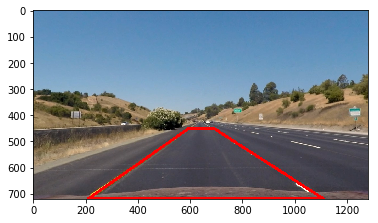

In [118]:
#pts = np.array([[250,bottom_px],[600,450],[700,450], [1180, bottom_px]], np.int32)
#pts = np.array([[200,bottom_px],[520,500],[770,500], [1120, bottom_px]], np.int32)
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.imshow(copy_combined)

In [107]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [108]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [119]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [120]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

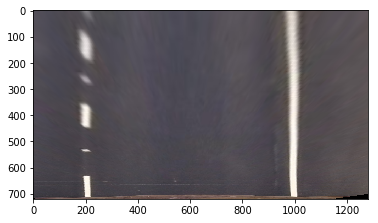

In [121]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [122]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

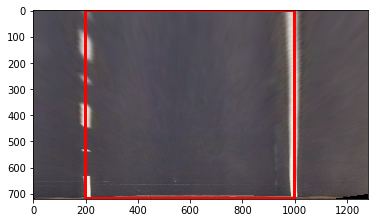

In [123]:
test_persp_img = np.copy(test_imgs_pers_tr[5])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)
plt.imshow(test_persp_img)

We can see that our perspective transform keeps straight lines straight, which is a required sanity check.

In [124]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

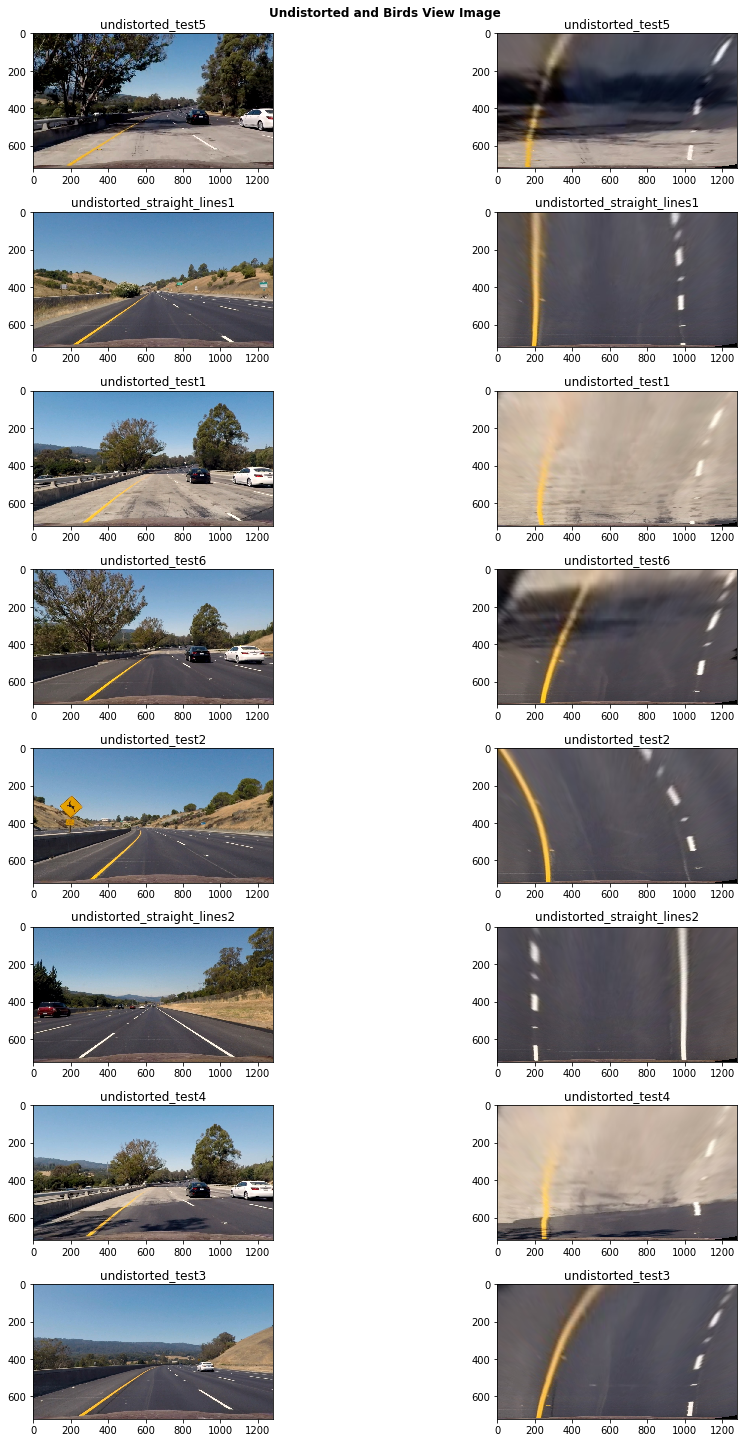

In [125]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

In [751]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    #undist_img_gray = to_grayscale(undist_img)
    undist_img_gray = to_hsv(undist_img)[:,:,2]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(25, 200))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(50, 150))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(150, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/5, np.pi/2))   
    
    #undist_img_hls = to_hls(undist_img)
    #hls_s_thresholds = threshold_img(undist_img_hls, 2, thres=(150, 255))
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    #undist_img_hsv = to_hsv(undist_img)
    #hsv_img_thres = np.zeros_like(undist_img_hsv[:,:,0])
    #hsv_img_thres[(undist_img_hsv[:,:,0] >= 15) & (undist_img_hsv[:,:,0] <= 35) ] = 1

    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
    
    return combined_binary

In [752]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [753]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [754]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [755]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

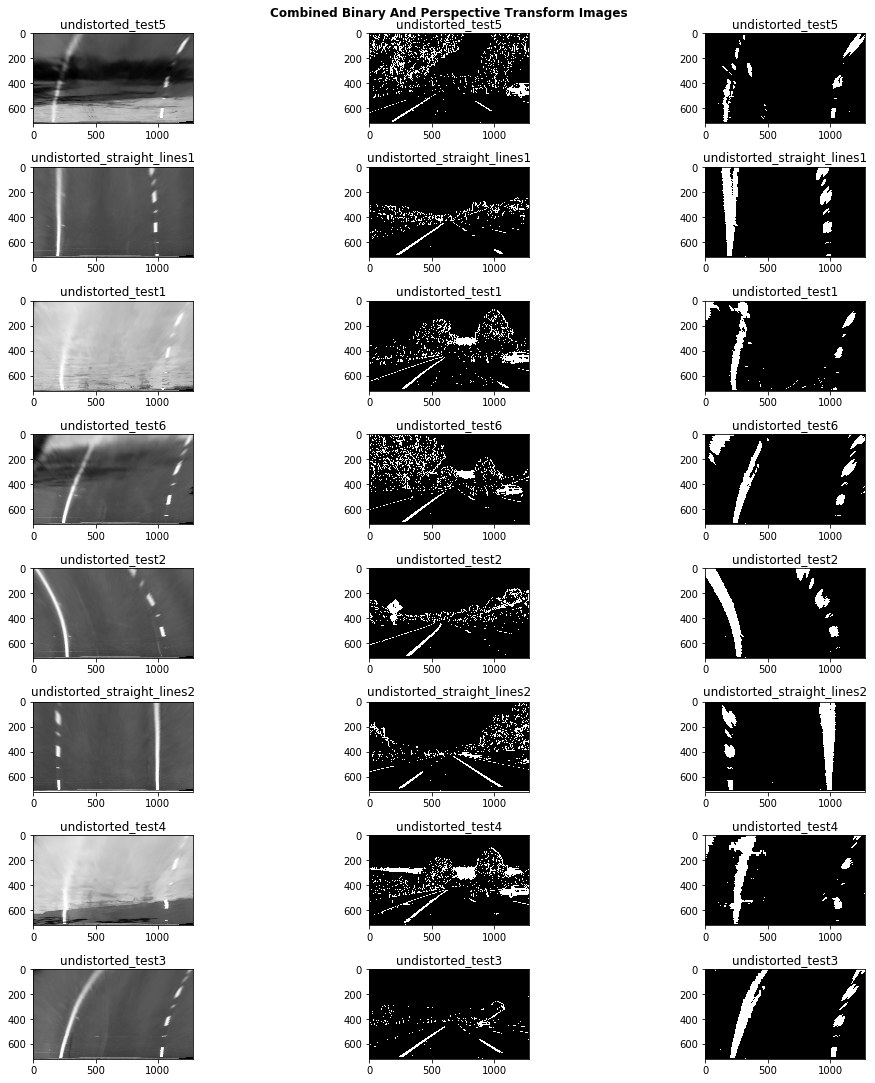

In [756]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

The perspective transform still works reasonably well but we are faced with lots of artefacts on the image.

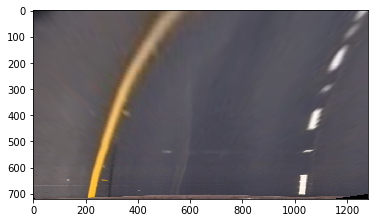

In [618]:
plt.imshow(test_imgs_psp_tr[-1])

In [141]:
sample_combined_binary_psp_tr = test_imgs_combined_binary_psp_tr[7]

In [142]:
sample_combined_binary_psp_tr[sample_combined_binary_psp_tr.shape[0]//2:,:].shape

(360, 1280)

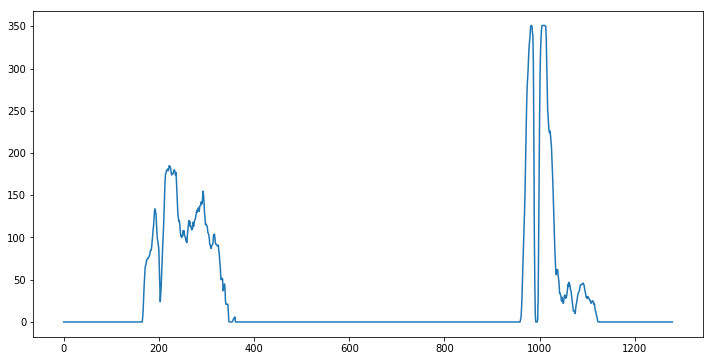

In [143]:
histogram = np.sum(sample_combined_binary_psp_tr[sample_combined_binary_psp_tr.shape[0]//2:,:], axis=0)
plt.figure(figsize=(12,6))
plt.plot(histogram)

In [974]:
histogram.shape

(1280,)

In [489]:
def compute_and_visualize_sliding_windows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image, summing pixel values column wise 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Create an image for the contour
    window_img = np.zeros_like(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # NOTE: nonzero returns a tuple of arrays in y and x directions
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Defining our window's coverage in the horizontal (i.e. x) direction 
        # Notice that the window's width is twice the margin
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image - we are passing in points of the one of the rectangle's diagonals
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
#        print("Shape of good_left_ind={0}".format(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
 #       (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]))
        
        # Super crytic and hard to understand...
        # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
        # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
        # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
    # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    ###### LANE CURVATURE #### Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 20/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/800.0 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    ###### LANE CURVATURE #### Define conversions in x and y from pixels space to meters
    

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,200, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,200, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    
    # Now draw the lines
    print("LEFT FIT X SHAPE={0} - PLOTY SHAPE={1}".format(left_fitx.shape, ploty.shape))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    #return (left_fit, right_fit, out_img)

152.882308827 m 4623.49687419 m
LEFT FIT X SHAPE=(720,) - PLOTY SHAPE=(720,)


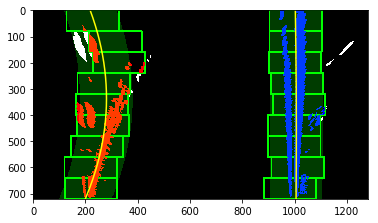

In [490]:
compute_and_visualize_sliding_windows(sample_combined_binary_psp_tr)

# Pipeline Definition

In [166]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [405]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [411]:
import math

class LaneLineHistory:
    def __init__(self, test_points=[50, 300, 500, 700], poly_max_deviation_distance=50):
        self.lane_lines = create_queue(5)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line):
        if len(self.lane_lines) == 0:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [757]:
class AdvancedLaneDetectorWithMemory:
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=20):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        final_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        #plt.imshow(final_img)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        #start_offset_y = 2 * self.small_img_y_offset + self.small_img_size[1]
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        #print("pts shape = {0}".format(pts[0]))
        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (200, 0, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (200, 0, 0))
        #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        #plt.imshow(result)
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified are colored
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 0, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()

        
        #if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
        if False:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 

            
        else:
            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit
            print("**** REVISED Poly left {0}".format(left_fit))

        if not self.previous_right_lane_lines.append(right_line):
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit
            print("**** REVISED Poly right {0}".format(right_fit))

    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [758]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [759]:
proc_img = ld.process_image(test_img)

[LEFT] Number of hot pixels=24154
[RIGHT] Number of hot pixels=60821


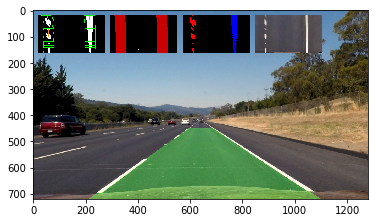

In [760]:
plt.imshow(proc_img)

In [ ]:
#(720, 1280, 3)

# Normal video

In [175]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [181]:
project_video_path = "project_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'

In [766]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 20, 30, targetname=project_video_sample_path)


[MoviePy] Running:
>>> ffmpeg -y -i project_video.mp4 -ss 20.00 -t 10.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [767]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 25)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359
[MoviePy] >>>> Building video output_videos/lanes_project_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_project_video_sample.mp4



  0%|          | 1/251 [00:01<04:23,  1.06s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  1%|          | 2/251 [00:02<04:26,  1.07s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  1%|          | 3/251 [00:03<04:24,  1.07s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  2%|▏         | 4/251 [00:04<04:22,  1.06s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  2%|▏         | 5/251 [00:05<04:20,  1.06s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  2%|▏         | 6/251 [00:06<04:18,  1.06s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  3%|▎         | 7/251 [00:07<04:17,  1.05s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  3%|▎         | 8/251 [00:08<04:15,  1.05s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  4%|▎         | 9/251 [00:09<04:14,  1.05s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  4%|▍         | 10/251 [00:10<04:13,  1.05s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  4%|▍         | 11/251 [00:11<04:12,  1.05s/it]

[LEFT] Number of hot pixels=54327
[RIGHT] Number of hot pixels=21359



  5%|▍         | 12/251 [00:12<04:11,  1.05s/it]

[LEFT] Number of hot pixels=53008
[RIGHT] Number of hot pixels=22735



  5%|▌         | 13/251 [00:13<04:10,  1.05s/it]

[LEFT] Number of hot pixels=52362
[RIGHT] Number of hot pixels=23887



  6%|▌         | 14/251 [00:14<04:09,  1.05s/it]

[LEFT] Number of hot pixels=52165
[RIGHT] Number of hot pixels=25244



  6%|▌         | 15/251 [00:15<04:08,  1.05s/it]

[LEFT] Number of hot pixels=50914
[RIGHT] Number of hot pixels=23979



  6%|▋         | 16/251 [00:16<04:07,  1.05s/it]

[LEFT] Number of hot pixels=49012
[RIGHT] Number of hot pixels=24239



  7%|▋         | 17/251 [00:17<04:06,  1.05s/it]

[LEFT] Number of hot pixels=47790
[RIGHT] Number of hot pixels=23796



  7%|▋         | 18/251 [00:18<04:05,  1.05s/it]

[LEFT] Number of hot pixels=49544
[RIGHT] Number of hot pixels=23129



  8%|▊         | 19/251 [00:20<04:04,  1.05s/it]

[LEFT] Number of hot pixels=50030
[RIGHT] Number of hot pixels=22535



  8%|▊         | 20/251 [00:21<04:03,  1.05s/it]

[LEFT] Number of hot pixels=48783
[RIGHT] Number of hot pixels=22925



  8%|▊         | 21/251 [00:22<04:02,  1.05s/it]

[LEFT] Number of hot pixels=44269
[RIGHT] Number of hot pixels=20201



  9%|▉         | 22/251 [00:23<04:01,  1.05s/it]

[LEFT] Number of hot pixels=44820
[RIGHT] Number of hot pixels=20926



  9%|▉         | 23/251 [00:24<03:59,  1.05s/it]

[LEFT] Number of hot pixels=46804
[RIGHT] Number of hot pixels=22717



 10%|▉         | 24/251 [00:25<03:59,  1.05s/it]

[LEFT] Number of hot pixels=45505
[RIGHT] Number of hot pixels=20829



 10%|▉         | 25/251 [00:26<03:57,  1.05s/it]

[LEFT] Number of hot pixels=42298
[RIGHT] Number of hot pixels=19840



 10%|█         | 26/251 [00:27<03:56,  1.05s/it]

[LEFT] Number of hot pixels=41583
[RIGHT] Number of hot pixels=19395



 11%|█         | 27/251 [00:28<03:55,  1.05s/it]

[LEFT] Number of hot pixels=41539
[RIGHT] Number of hot pixels=18455



 11%|█         | 28/251 [00:29<03:54,  1.05s/it]

[LEFT] Number of hot pixels=44665
[RIGHT] Number of hot pixels=20497



 12%|█▏        | 29/251 [00:30<03:53,  1.05s/it]

[LEFT] Number of hot pixels=42633
[RIGHT] Number of hot pixels=20490



 12%|█▏        | 30/251 [00:31<03:52,  1.05s/it]

[LEFT] Number of hot pixels=40114
[RIGHT] Number of hot pixels=21173



 12%|█▏        | 31/251 [00:32<03:50,  1.05s/it]

[LEFT] Number of hot pixels=36543
[RIGHT] Number of hot pixels=20634



 13%|█▎        | 32/251 [00:33<03:49,  1.05s/it]

[LEFT] Number of hot pixels=30550
[RIGHT] Number of hot pixels=16756



 13%|█▎        | 33/251 [00:34<03:48,  1.05s/it]

[LEFT] Number of hot pixels=31781
[RIGHT] Number of hot pixels=16751



 14%|█▎        | 34/251 [00:35<03:47,  1.05s/it]

[LEFT] Number of hot pixels=33078
[RIGHT] Number of hot pixels=17781



 14%|█▍        | 35/251 [00:36<03:46,  1.05s/it]

[LEFT] Number of hot pixels=36122
[RIGHT] Number of hot pixels=18015



 14%|█▍        | 36/251 [00:37<03:45,  1.05s/it]

[LEFT] Number of hot pixels=38282
[RIGHT] Number of hot pixels=18775



 15%|█▍        | 37/251 [00:38<03:44,  1.05s/it]

[LEFT] Number of hot pixels=37832
[RIGHT] Number of hot pixels=17860



 15%|█▌        | 38/251 [00:39<03:43,  1.05s/it]

[LEFT] Number of hot pixels=38494
[RIGHT] Number of hot pixels=17595



 16%|█▌        | 39/251 [00:41<03:42,  1.05s/it]

[LEFT] Number of hot pixels=36596
[RIGHT] Number of hot pixels=16648



 16%|█▌        | 40/251 [00:42<03:41,  1.05s/it]

[LEFT] Number of hot pixels=35717
[RIGHT] Number of hot pixels=17305



 16%|█▋        | 41/251 [00:43<03:40,  1.05s/it]

[LEFT] Number of hot pixels=39086
[RIGHT] Number of hot pixels=16719



 17%|█▋        | 42/251 [00:44<03:39,  1.05s/it]

[LEFT] Number of hot pixels=36543
[RIGHT] Number of hot pixels=16724



 17%|█▋        | 43/251 [00:45<03:38,  1.05s/it]

[LEFT] Number of hot pixels=34361
[RIGHT] Number of hot pixels=15629



 18%|█▊        | 44/251 [00:46<03:36,  1.05s/it]

[LEFT] Number of hot pixels=32289
[RIGHT] Number of hot pixels=14162



 18%|█▊        | 45/251 [00:47<03:35,  1.05s/it]

[LEFT] Number of hot pixels=31816
[RIGHT] Number of hot pixels=15019



 18%|█▊        | 46/251 [00:48<03:34,  1.05s/it]

[LEFT] Number of hot pixels=31273
[RIGHT] Number of hot pixels=14939



 19%|█▊        | 47/251 [00:49<03:33,  1.05s/it]

[LEFT] Number of hot pixels=31447
[RIGHT] Number of hot pixels=14792



 19%|█▉        | 48/251 [00:50<03:32,  1.05s/it]

[LEFT] Number of hot pixels=31128
[RIGHT] Number of hot pixels=14610



 20%|█▉        | 49/251 [00:51<03:31,  1.05s/it]

[LEFT] Number of hot pixels=31837
[RIGHT] Number of hot pixels=14552



 20%|█▉        | 50/251 [00:52<03:30,  1.05s/it]

[LEFT] Number of hot pixels=35011
[RIGHT] Number of hot pixels=15340



 20%|██        | 51/251 [00:53<03:29,  1.05s/it]

[LEFT] Number of hot pixels=35901
[RIGHT] Number of hot pixels=14976



 21%|██        | 52/251 [00:54<03:28,  1.05s/it]

[LEFT] Number of hot pixels=35919
[RIGHT] Number of hot pixels=14192



 21%|██        | 53/251 [00:55<03:27,  1.05s/it]

[LEFT] Number of hot pixels=33434
[RIGHT] Number of hot pixels=12831



 22%|██▏       | 54/251 [00:56<03:25,  1.05s/it]

[LEFT] Number of hot pixels=31939
[RIGHT] Number of hot pixels=11213



 22%|██▏       | 55/251 [00:57<03:24,  1.04s/it]

[LEFT] Number of hot pixels=28309
[RIGHT] Number of hot pixels=10106



 22%|██▏       | 56/251 [00:58<03:23,  1.04s/it]

[LEFT] Number of hot pixels=27263
[RIGHT] Number of hot pixels=12522



 23%|██▎       | 57/251 [00:59<03:22,  1.04s/it]

[LEFT] Number of hot pixels=26007
[RIGHT] Number of hot pixels=14113



 23%|██▎       | 58/251 [01:00<03:21,  1.04s/it]

[LEFT] Number of hot pixels=26025
[RIGHT] Number of hot pixels=15234



 24%|██▎       | 59/251 [01:01<03:20,  1.04s/it]

[LEFT] Number of hot pixels=27747
[RIGHT] Number of hot pixels=13719



 24%|██▍       | 60/251 [01:03<03:19,  1.05s/it]

[LEFT] Number of hot pixels=31368
[RIGHT] Number of hot pixels=11270
**** MAX DISTANCE BREACHED ****
y_smooth=[ 165.81235557  193.08961443  204.84004101  207.63812936] - y_new=[  95.17338374  136.52038702  166.00043561  192.28265839] - distance=70.63897182579052 - max-distance=50
**** REVISED Poly left [ -3.99728225e-05   1.79378501e-01   8.63043908e+01]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1058.03641149  1052.90448802  1043.43596498  1029.20034482] - y_new=[ 1144.34170311  1129.95957912  1098.35099139  1048.87316941] - distance=86.30529161872369 - max-distance=50
**** REVISED Poly right [ -2.23365428e-04   2.06494039e-02   1.14386765e+03]



 24%|██▍       | 61/251 [01:04<03:18,  1.05s/it]

[LEFT] Number of hot pixels=32533
[RIGHT] Number of hot pixels=11758
**** MAX DISTANCE BREACHED ****
y_smooth=[ 165.81235557  193.08961443  204.84004101  207.63812936] - y_new=[  81.48250484  123.5574572   156.07475265  187.57634458] - distance=84.32985073188448 - max-distance=50
**** REVISED Poly left [ -1.26962939e-05   1.72743512e-01   7.28770700e+01]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1058.03641149  1052.90448802  1043.43596498  1029.20034482] - y_new=[ 1192.62006525  1141.3058576   1099.26977048  1056.35837581] - distance=134.58365376045685 - max-distance=50
**** REVISED Poly right [ -1.09413444e-05  -2.01427360e-01   1.20271879e+03]



 25%|██▍       | 62/251 [01:05<03:17,  1.05s/it]

[LEFT] Number of hot pixels=32306
[RIGHT] Number of hot pixels=11545
**** MAX DISTANCE BREACHED ****
y_smooth=[ 165.81235557  193.08961443  204.84004101  207.63812936] - y_new=[  60.30414469  111.07671677  147.95929064  181.52143448] - distance=105.50821087630335 - max-distance=50
**** REVISED Poly left [ -4.15053754e-05   2.17617170e-01   4.95270496e+01]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1058.03641149  1052.90448802  1043.43596498  1029.20034482] - y_new=[ 1240.02340054  1158.04755335  1105.83904347  1065.51690506] - distance=181.9869890511584 - max-distance=50
**** REVISED Poly right [  1.48579643e-04  -3.79906264e-01   1.25864726e+03]



 25%|██▌       | 63/251 [01:06<03:16,  1.05s/it]

[LEFT] Number of hot pixels=25810
[RIGHT] Number of hot pixels=15120
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1058.03641149  1052.90448802  1043.43596498  1029.20034482] - y_new=[ 1137.90963837  1107.98328085  1083.44880132  1058.38686089] - distance=79.87322687479741 - max-distance=50
**** REVISED Poly right [ -6.59326132e-06  -1.17397789e-01   1.14379601e+03]



 25%|██▌       | 64/251 [01:07<03:15,  1.04s/it]

[LEFT] Number of hot pixels=18367
[RIGHT] Number of hot pixels=12984



 26%|██▌       | 65/251 [01:08<03:13,  1.04s/it]

[LEFT] Number of hot pixels=15649
[RIGHT] Number of hot pixels=11390



 26%|██▋       | 66/251 [01:09<03:12,  1.04s/it]

[LEFT] Number of hot pixels=14839
[RIGHT] Number of hot pixels=12936
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1064.75054289  1054.84564521  1046.67100278  1038.27349431] - y_new=[  999.47260561  1019.93617168  1030.2661758   1035.22653661] - distance=65.27793727776304 - max-distance=50
**** REVISED Poly right [ -6.71205415e-05   1.05346454e-01   9.94373084e+02]



 27%|██▋       | 67/251 [01:10<03:11,  1.04s/it]

[LEFT] Number of hot pixels=14935
[RIGHT] Number of hot pixels=11316
**** MAX DISTANCE BREACHED ****
y_smooth=[ 165.61368208  180.90735749  189.86780498  195.91759217] - y_new=[ 216.71508791  217.30270525  213.69809941  206.47153828] - distance=51.10140583772815 - max-distance=50
**** REVISED Poly left [ -4.52744411e-05   1.81965237e-02   2.15918448e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1064.75054289  1054.84564521  1046.67100278  1038.27349431] - y_new=[  980.63223144  1007.01797174  1022.00932249  1031.56312526] - distance=84.11831144746805 - max-distance=50
**** REVISED Poly right [ -6.79693498e-05   1.29332234e-01   9.74335543e+02]



 27%|██▋       | 68/251 [01:11<03:10,  1.04s/it]

[LEFT] Number of hot pixels=14086
[RIGHT] Number of hot pixels=11046
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1064.75054289  1054.84564521  1046.67100278  1038.27349431] - y_new=[  973.02602818  1005.57416522  1022.46321979  1031.21942542] - distance=91.72451471236741 - max-distance=50
**** REVISED Poly right [ -1.01660612e-04   1.65773762e-01   9.64991492e+02]



 27%|██▋       | 69/251 [01:12<03:09,  1.04s/it]

[LEFT] Number of hot pixels=14492
[RIGHT] Number of hot pixels=12750
**** MAX DISTANCE BREACHED ****
y_smooth=[ 178.43791366  188.62621068  194.41175709  198.0950002 ] - y_new=[ 229.41870913  211.60291497  206.33658969  209.05809556] - distance=50.980795467194525 - max-distance=50
**** REVISED Poly left [  9.98478894e-05  -1.06209938e-01   2.34479586e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1064.75054289  1054.84564521  1046.67100278  1038.27349431] - y_new=[  992.45749833  1019.7509776   1031.98913568  1035.69696014] - distance=72.29304455521833 - max-distance=50
**** REVISED Poly right [ -1.06629170e-04   1.46494127e-01   9.85399365e+02]



 28%|██▊       | 70/251 [01:13<03:08,  1.04s/it]

[LEFT] Number of hot pixels=14193
[RIGHT] Number of hot pixels=13405
**** MAX DISTANCE BREACHED ****
y_smooth=[ 178.43791366  188.62621068  194.41175709  198.0950002 ] - y_new=[ 245.38464915  214.03568671  204.7152524   209.40258311] - distance=66.94673548637928 - max-distance=50
**** REVISED Poly left [  1.75097063e-04  -1.86679822e-01   2.54280898e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1064.75054289  1054.84564521  1046.67100278  1038.27349431] - y_new=[ 1005.73228839  1028.49094052  1037.7633155   1039.09387115] - distance=59.01825449987814 - max-distance=50
**** REVISED Poly right [ -9.92727415e-05   1.25780068e-01   9.99691467e+02]



 28%|██▊       | 71/251 [01:14<03:07,  1.04s/it]

[LEFT] Number of hot pixels=16361
[RIGHT] Number of hot pixels=15178



 29%|██▊       | 72/251 [01:15<03:06,  1.04s/it]

[LEFT] Number of hot pixels=15646
[RIGHT] Number of hot pixels=15157



 29%|██▉       | 73/251 [01:16<03:05,  1.04s/it]

[LEFT] Number of hot pixels=15478
[RIGHT] Number of hot pixels=15030



 29%|██▉       | 74/251 [01:17<03:04,  1.04s/it]

[LEFT] Number of hot pixels=14213
[RIGHT] Number of hot pixels=13292



 30%|██▉       | 75/251 [01:18<03:03,  1.04s/it]

[LEFT] Number of hot pixels=12672
[RIGHT] Number of hot pixels=11562



 30%|███       | 76/251 [01:19<03:05,  1.06s/it]

[LEFT] Number of hot pixels=12502
[RIGHT] Number of hot pixels=11628



 31%|███       | 77/251 [01:20<03:03,  1.06s/it]

[LEFT] Number of hot pixels=12166
[RIGHT] Number of hot pixels=12394



 31%|███       | 78/251 [01:21<03:01,  1.05s/it]

[LEFT] Number of hot pixels=10879
[RIGHT] Number of hot pixels=13046



 31%|███▏      | 79/251 [01:22<03:02,  1.06s/it]

[LEFT] Number of hot pixels=11088
[RIGHT] Number of hot pixels=12302



 32%|███▏      | 80/251 [01:23<03:00,  1.05s/it]

[LEFT] Number of hot pixels=12484
[RIGHT] Number of hot pixels=12732



 32%|███▏      | 81/251 [01:24<02:58,  1.05s/it]

[LEFT] Number of hot pixels=13248
[RIGHT] Number of hot pixels=12166



 33%|███▎      | 82/251 [01:26<02:56,  1.05s/it]

[LEFT] Number of hot pixels=12630
[RIGHT] Number of hot pixels=12235



 33%|███▎      | 83/251 [01:27<02:55,  1.04s/it]

[LEFT] Number of hot pixels=13801
[RIGHT] Number of hot pixels=10810



 33%|███▎      | 84/251 [01:28<02:53,  1.04s/it]

[LEFT] Number of hot pixels=14160
[RIGHT] Number of hot pixels=10905



 34%|███▍      | 85/251 [01:29<02:55,  1.06s/it]

[LEFT] Number of hot pixels=15151
[RIGHT] Number of hot pixels=11429



 34%|███▍      | 86/251 [01:30<02:55,  1.07s/it]

[LEFT] Number of hot pixels=13567
[RIGHT] Number of hot pixels=9973



 35%|███▍      | 87/251 [01:31<02:53,  1.06s/it]

[LEFT] Number of hot pixels=14551
[RIGHT] Number of hot pixels=9623



 35%|███▌      | 88/251 [01:32<02:51,  1.05s/it]

[LEFT] Number of hot pixels=13777
[RIGHT] Number of hot pixels=8681



 35%|███▌      | 89/251 [01:33<02:49,  1.05s/it]

[LEFT] Number of hot pixels=14946
[RIGHT] Number of hot pixels=8433



 36%|███▌      | 90/251 [01:34<02:48,  1.05s/it]

[LEFT] Number of hot pixels=13409
[RIGHT] Number of hot pixels=8282
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1009.072717    1001.4173391   1012.97647909  1040.25423444] - y_new=[ 1084.26434825  1017.05878797  1020.25298914  1074.07710087] - distance=75.19163124503223 - max-distance=50
**** REVISED Poly right [  6.32873882e-04  -4.90328100e-01   1.10719857e+03]



 36%|███▋      | 91/251 [01:35<02:46,  1.04s/it]

[LEFT] Number of hot pixels=16420
[RIGHT] Number of hot pixels=8563
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1009.072717    1001.4173391   1012.97647909  1040.25423444] - y_new=[ 1098.402671    1026.78866857  1021.86742328  1063.49725058] - distance=89.32995399669755 - max-distance=50
**** REVISED Poly right [  5.81888407e-04  -4.90116952e-01   1.12145380e+03]



 37%|███▋      | 92/251 [01:36<02:48,  1.06s/it]

[LEFT] Number of hot pixels=14271
[RIGHT] Number of hot pixels=8425



 37%|███▋      | 93/251 [01:37<02:46,  1.05s/it]

[LEFT] Number of hot pixels=13603
[RIGHT] Number of hot pixels=7999



 37%|███▋      | 94/251 [01:38<02:45,  1.05s/it]

[LEFT] Number of hot pixels=12791
[RIGHT] Number of hot pixels=9343
**** MAX DISTANCE BREACHED ****
y_smooth=[  77.52397062  159.08692416  194.90062795  204.54841259] - y_new=[ 209.57635651  185.55798742  184.82247975  200.51291662] - distance=132.0523858858245 - max-distance=50
**** REVISED Poly left [  2.05324307e-04  -1.67936984e-01   2.17459895e+02]



 38%|███▊      | 95/251 [01:39<02:43,  1.05s/it]

[LEFT] Number of hot pixels=12925
[RIGHT] Number of hot pixels=10859
**** MAX DISTANCE BREACHED ****
y_smooth=[  77.52397062  159.08692416  194.90062795  204.54841259] - y_new=[  12.04955568  135.43988665  186.09270592  194.02601807] - distance=65.47441493527737 - max-distance=50
**** REVISED Poly left [ -5.33993839e-04   6.80459168e-01  -2.06384181e+01]



 38%|███▊      | 96/251 [01:40<02:42,  1.05s/it]

[LEFT] Number of hot pixels=13706
[RIGHT] Number of hot pixels=11632
**** MAX DISTANCE BREACHED ****
y_smooth=[  77.52397062  159.08692416  194.90062795  204.54841259] - y_new=[ 173.41242023  178.01536706  184.45741575  193.35252332] - distance=95.88844960831632 - max-distance=50
**** REVISED Poly left [  3.06632359e-05   7.67965477e-03   1.72951779e+02]



 39%|███▊      | 97/251 [01:41<02:40,  1.04s/it]

[LEFT] Number of hot pixels=15865
[RIGHT] Number of hot pixels=12246
**** MAX DISTANCE BREACHED ****
y_smooth=[  77.52397062  159.08692416  194.90062795  204.54841259] - y_new=[ 154.48336825  167.69103322  179.3214909   191.89801587] - distance=76.95939763522391 - max-distance=50
**** REVISED Poly left [  1.18258411e-05   4.86916155e-02   1.52019223e+02]



 39%|███▉      | 98/251 [01:42<02:39,  1.04s/it]

[LEFT] Number of hot pixels=14330
[RIGHT] Number of hot pixels=13291



 39%|███▉      | 99/251 [01:43<02:38,  1.04s/it]

[LEFT] Number of hot pixels=16007
[RIGHT] Number of hot pixels=13932



 40%|███▉      | 100/251 [01:44<02:40,  1.06s/it]

[LEFT] Number of hot pixels=15042
[RIGHT] Number of hot pixels=13990



 40%|████      | 101/251 [01:46<02:38,  1.05s/it]

[LEFT] Number of hot pixels=18719
[RIGHT] Number of hot pixels=12769



 41%|████      | 102/251 [01:47<02:36,  1.05s/it]

[LEFT] Number of hot pixels=19914
[RIGHT] Number of hot pixels=13870



 41%|████      | 103/251 [01:48<02:35,  1.05s/it]

[LEFT] Number of hot pixels=19340
[RIGHT] Number of hot pixels=13358



 41%|████▏     | 104/251 [01:49<02:36,  1.07s/it]

[LEFT] Number of hot pixels=21817
[RIGHT] Number of hot pixels=13995



 42%|████▏     | 105/251 [01:50<02:37,  1.08s/it]

[LEFT] Number of hot pixels=20209
[RIGHT] Number of hot pixels=12011
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 175.34178674  160.06151123  165.98181044  188.03057152] - distance=58.77346138392005 - max-distance=50
**** REVISED Poly left [  2.01605773e-04  -1.31683123e-01   1.81421928e+02]



 42%|████▏     | 106/251 [01:51<02:34,  1.07s/it]

[LEFT] Number of hot pixels=17656
[RIGHT] Number of hot pixels=14367
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 213.20428432  180.43955084  175.43420513  189.27902928] - distance=96.63595896139515 - max-distance=50
**** REVISED Poly left [  2.35627123e-04  -2.13528427e-01   2.23291638e+02]



 43%|████▎     | 107/251 [01:52<02:34,  1.08s/it]

[LEFT] Number of hot pixels=16429
[RIGHT] Number of hot pixels=15576
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 235.01974282  191.30838297  179.61403813  188.60835377] - distance=118.45141746320334 - max-distance=50
**** REVISED Poly left [  2.58608256e-04  -2.65358329e-01   2.47641139e+02]



 43%|████▎     | 108/251 [01:53<02:32,  1.07s/it]

[LEFT] Number of hot pixels=18290
[RIGHT] Number of hot pixels=16880
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 222.51708759  184.13839915  174.32435067  183.07821534] - distance=105.94876222996572 - max-distance=50
**** REVISED Poly left [  2.32098914e-04  -2.34749374e-01   2.33674309e+02]



 43%|████▎     | 109/251 [01:54<02:30,  1.06s/it]

[LEFT] Number of hot pixels=20015
[RIGHT] Number of hot pixels=17593
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 212.79586524  176.7699853   168.9027066   179.66069479] - distance=96.22753988606198 - max-distance=50
**** REVISED Poly left [  2.32815836e-04  -2.25589062e-01   2.23493279e+02]



 44%|████▍     | 110/251 [01:55<02:29,  1.06s/it]

[LEFT] Number of hot pixels=21146
[RIGHT] Number of hot pixels=16823
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 204.79102503  170.70399847  164.83242108  177.98132711] - distance=88.22269966766413 - max-distance=50
**** REVISED Poly left [  2.37756043e-04  -2.19562721e-01   2.15174771e+02]



 44%|████▍     | 111/251 [01:56<02:27,  1.05s/it]

[LEFT] Number of hot pixels=22233
[RIGHT] Number of hot pixels=17897
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 207.64691498  167.44104807  160.50711199  176.00051588] - distance=91.07858962711907 - max-distance=50
**** REVISED Poly left [  2.80341750e-04  -2.58943080e-01   2.19893215e+02]



 45%|████▍     | 112/251 [01:57<02:26,  1.05s/it]

[LEFT] Number of hot pixels=20517
[RIGHT] Number of hot pixels=17116
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 233.0044104   178.39621869  164.98018308  178.47127436] - distance=116.43608504036496 - max-distance=50
**** REVISED Poly left [  3.36339086e-04  -3.36151447e-01   2.48971135e+02]



 45%|████▌     | 113/251 [01:58<02:27,  1.07s/it]

[LEFT] Number of hot pixels=20889
[RIGHT] Number of hot pixels=16046
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 249.5948297   182.69251158  164.30297607  177.14216854] - distance=133.0265043416731 - max-distance=50
**** REVISED Poly left [  3.90359100e-04  -4.04234957e-01   2.68830680e+02]



 45%|████▌     | 114/251 [01:59<02:25,  1.06s/it]

[LEFT] Number of hot pixels=19951
[RIGHT] Number of hot pixels=16745
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 264.69919272  188.3536572   165.27559159  175.97384848] - distance=148.13086735836868 - max-distance=50
**** REVISED Poly left [  4.22204031e-04  -4.53153553e-01   2.86301360e+02]



 46%|████▌     | 115/251 [02:00<02:23,  1.05s/it]

[LEFT] Number of hot pixels=22941
[RIGHT] Number of hot pixels=16873
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 298.27610655  192.96443539  161.32228228  176.44207035] - distance=181.70778119420203 - max-distance=50
**** REVISED Poly left [  5.84524265e-04  -6.25830177e-01   3.28106305e+02]



 46%|████▌     | 116/251 [02:01<02:21,  1.05s/it]

[LEFT] Number of hot pixels=26222
[RIGHT] Number of hot pixels=16814
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 322.57439463  208.48176826  168.06781061  172.86286936] - distance=206.00606926766858 - max-distance=50
**** REVISED Poly left [  5.65112705e-04  -6.54159952e-01   3.53869610e+02]



 47%|████▋     | 117/251 [02:02<02:20,  1.05s/it]

[LEFT] Number of hot pixels=27222
[RIGHT] Number of hot pixels=17594
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 345.19464632  224.08694698  175.81860306  170.76609518] - distance=228.62632096171626 - max-distance=50
**** REVISED Poly left [  5.40197951e-04  -6.73500080e-01   3.77519155e+02]



 47%|████▋     | 118/251 [02:04<02:19,  1.05s/it]

[LEFT] Number of hot pixels=26565
[RIGHT] Number of hot pixels=17292
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 352.00517063  228.07724191  176.94100979  168.47687623] - distance=235.4368452701529 - max-distance=50
**** REVISED Poly left [  5.33401232e-04  -6.82402146e-01   3.84791775e+02]



 47%|████▋     | 119/251 [02:05<02:18,  1.05s/it]

[LEFT] Number of hot pixels=25108
[RIGHT] Number of hot pixels=17867
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 391.86514263  252.18552228  189.42287194  170.19892911] - distance=275.2968172699015 - max-distance=50
**** REVISED Poly left [  5.44233844e-04  -7.49200327e-01   4.27964574e+02]



 48%|████▊     | 120/251 [02:06<02:17,  1.05s/it]

[LEFT] Number of hot pixels=26913
[RIGHT] Number of hot pixels=18378
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 392.25072266  252.16653906  189.24005485  169.99433747] - distance=275.68239730678494 - max-distance=50
**** REVISED Poly left [  5.46009585e-04  -7.51440089e-01   4.28457703e+02]



 48%|████▊     | 121/251 [02:07<02:16,  1.05s/it]

[LEFT] Number of hot pixels=27365
[RIGHT] Number of hot pixels=18832
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 411.99677798  264.16510681  195.10184044  169.77374791] - distance=295.4284526261542 - max-distance=50
**** REVISED Poly left [  5.46689673e-04  -7.82668070e-01   4.49763457e+02]



 49%|████▊     | 122/251 [02:08<02:15,  1.05s/it]

[LEFT] Number of hot pixels=28809
[RIGHT] Number of hot pixels=19920
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 400.92209066  257.98540591  192.39133949  170.13530096] - distance=284.353765300444 - max-distance=50
**** REVISED Poly left [  5.41725349e-04  -7.61350611e-01   4.37635308e+02]



 49%|████▉     | 123/251 [02:09<02:14,  1.05s/it]

[LEFT] Number of hot pixels=28787
[RIGHT] Number of hot pixels=19637
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 403.74152437  263.34102879  197.59900949  173.25999209] - distance=287.17319900860514 - max-distance=50
**** REVISED Poly left [  5.17537524e-04  -7.42740116e-01   4.39584686e+02]



 49%|████▉     | 124/251 [02:10<02:13,  1.05s/it]

[LEFT] Number of hot pixels=29725
[RIGHT] Number of hot pixels=18887
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 418.98174648  272.10215172  202.68580612  176.01375406] - distance=302.4134211184555 - max-distance=50
**** REVISED Poly left [  5.34303669e-04  -7.74524663e-01   4.56372220e+02]



 50%|████▉     | 125/251 [02:11<02:12,  1.05s/it]

[LEFT] Number of hot pixels=26302
[RIGHT] Number of hot pixels=19166
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 498.55129071  315.30065583  226.39558473  188.77534635] - distance=381.9829653496316 - max-distance=50
**** REVISED Poly left [  6.41060409e-04  -9.57373683e-01   5.44817324e+02]



 50%|█████     | 126/251 [02:12<02:11,  1.05s/it]

[LEFT] Number of hot pixels=26619
[RIGHT] Number of hot pixels=18683
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 505.40398634  324.96556997  234.00063867  190.48975342] - distance=388.8356609785122 - max-distance=50
**** REVISED Poly left [  5.93175576e-04  -9.29365117e-01   5.50389303e+02]



 51%|█████     | 127/251 [02:13<02:10,  1.05s/it]

[LEFT] Number of hot pixels=26691
[RIGHT] Number of hot pixels=18055
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 510.46718452  329.35313366  237.18310527  191.87637671] - distance=393.89885916433025 - max-distance=50
**** REVISED Poly left [  5.85791248e-04  -9.29483140e-01   5.55476863e+02]



 51%|█████     | 128/251 [02:14<02:08,  1.05s/it]

[LEFT] Number of hot pixels=26618
[RIGHT] Number of hot pixels=18199
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 551.66878174  354.91597018  251.9466982   197.3622949 ] - distance=435.100456381941 - max-distance=50
**** REVISED Poly left [  6.04810859e-04  -9.98695047e-01   6.00091507e+02]



 51%|█████▏    | 129/251 [02:15<02:07,  1.05s/it]

[LEFT] Number of hot pixels=29167
[RIGHT] Number of hot pixels=17753
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 529.83994369  347.34175852  249.9144802   195.66166392] - distance=413.27161833334964 - max-distance=50
**** REVISED Poly left [  5.39680776e-04  -9.18881012e-01   5.74434792e+02]



 52%|█████▏    | 130/251 [02:16<02:06,  1.05s/it]

[LEFT] Number of hot pixels=34903
[RIGHT] Number of hot pixels=17747
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 461.99498259  313.06029983  233.88090927  190.22894595] - distance=345.4266572336712 - max-distance=50
**** REVISED Poly left [  4.44092841e-04  -7.51171225e-01   4.98443312e+02]



 52%|█████▏    | 131/251 [02:17<02:05,  1.05s/it]

[LEFT] Number of hot pixels=39999
[RIGHT] Number of hot pixels=17037
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 410.78013873  288.56175062  222.0071725   183.20382316] - distance=294.2118133679826 - max-distance=50
**** REVISED Poly left [  3.46890360e-04  -6.10285178e-01   4.40427172e+02]



 53%|█████▎    | 132/251 [02:18<02:04,  1.05s/it]

[LEFT] Number of hot pixels=40829
[RIGHT] Number of hot pixels=16933
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 380.55088103  271.5674033   212.84055163  179.41141597] - distance=263.9825556741842 - max-distance=50
**** REVISED Poly left [  3.16221450e-04  -5.46611418e-01   4.07090898e+02]



 53%|█████▎    | 133/251 [02:19<02:03,  1.05s/it]

[LEFT] Number of hot pixels=41383
[RIGHT] Number of hot pixels=16861
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 373.31911932  269.02125479  211.71591367  177.63986188] - distance=256.7507939600429 - max-distance=50
**** REVISED Poly left [  2.90366117e-04  -5.18819599e-01   3.98534184e+02]



 53%|█████▎    | 134/251 [02:20<02:02,  1.05s/it]

[LEFT] Number of hot pixels=40328
[RIGHT] Number of hot pixels=18719
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 402.72966017  284.49370206  219.66350749  181.28537687] - distance=286.1613348085 - max-distance=50
**** REVISED Poly left [  3.30650799e-04  -5.88671612e-01   4.31336614e+02]



 54%|█████▍    | 135/251 [02:21<02:01,  1.05s/it]

[LEFT] Number of hot pixels=38997
[RIGHT] Number of hot pixels=19786
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 445.11593148  314.11527076  237.3302652   185.44794675] - distance=328.5476061220084 - max-distance=50
**** REVISED Poly left [  3.11283589e-04  -6.32951899e-01   4.75985317e+02]



 54%|█████▍    | 136/251 [02:22<02:00,  1.05s/it]

[LEFT] Number of hot pixels=31027
[RIGHT] Number of hot pixels=19893
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 493.37000067  341.56015062  256.57155053  203.99119928] - distance=376.8016753140581 - max-distance=50
**** REVISED Poly left [  4.05103111e-04  -7.49025489e-01   5.29808517e+02]



 55%|█████▍    | 137/251 [02:23<02:01,  1.06s/it]

[LEFT] Number of hot pixels=26106
[RIGHT] Number of hot pixels=19954
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 550.00271943  374.27445439  275.49779794  213.88199088] - distance=433.4343940748227 - max-distance=50
**** REVISED Poly left [  4.64510618e-04  -8.65491776e-01   5.92116032e+02]



 55%|█████▍    | 138/251 [02:25<01:59,  1.06s/it]

[LEFT] Number of hot pixels=29916
[RIGHT] Number of hot pixels=20450
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 546.69014353  379.08813421  279.11389657  209.45732101] - distance=430.12181817611514 - max-distance=50
**** REVISED Poly left [  3.78970776e-04  -8.03047809e-01   5.85895107e+02]



 55%|█████▌    | 139/251 [02:26<01:58,  1.06s/it]

[LEFT] Number of hot pixels=32148
[RIGHT] Number of hot pixels=19082
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 518.10411324  365.67559249  274.22594036  209.88132333] - distance=401.53578788001784 - max-distance=50
**** REVISED Poly left [  3.38812939e-04  -7.28298612e-01   5.53672011e+02]



 56%|█████▌    | 140/251 [02:27<01:57,  1.06s/it]

[LEFT] Number of hot pixels=38292
[RIGHT] Number of hot pixels=18351
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 467.13044002  340.59381072  263.12686202  206.78200643] - distance=350.5621146636369 - max-distance=50
**** REVISED Poly left [  2.64026164e-04  -5.98555675e-01   4.96398158e+02]



 56%|█████▌    | 141/251 [02:28<01:55,  1.05s/it]

[LEFT] Number of hot pixels=44054
[RIGHT] Number of hot pixels=17258
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 415.21046134  315.12115974  251.02292952  201.12310912] - distance=298.64213598660723 - max-distance=50
**** REVISED Poly left [  1.77480123e-04  -4.62475249e-01   4.37890524e+02]



 57%|█████▋    | 142/251 [02:29<01:54,  1.05s/it]

[LEFT] Number of hot pixels=45389
[RIGHT] Number of hot pixels=17204
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 400.05430691  309.26284564  249.59334197  201.44709638] - distance=283.48598155313624 - max-distance=50
**** REVISED Poly left [  1.44040726e-04  -4.13580099e-01   4.20373210e+02]



 57%|█████▋    | 143/251 [02:30<01:53,  1.05s/it]

[LEFT] Number of hot pixels=44742
[RIGHT] Number of hot pixels=17644
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 413.50668396  318.21114779  255.87624836  205.89826406] - distance=296.93835859786924 - max-distance=50
**** REVISED Poly left [  1.54461439e-04  -4.35243648e-01   4.34882713e+02]



 57%|█████▋    | 144/251 [02:31<01:52,  1.05s/it]

[LEFT] Number of hot pixels=43168
[RIGHT] Number of hot pixels=18448
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 435.99929895  330.90752114  264.05871979  212.52069257] - distance=319.430973596407 - max-distance=50
**** REVISED Poly left [  1.91384677e-04  -4.87351748e-01   4.59888425e+02]



 58%|█████▊    | 145/251 [02:32<01:51,  1.05s/it]

[LEFT] Number of hot pixels=42341
[RIGHT] Number of hot pixels=19560
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 443.98836059  335.17551881  268.36943644  219.55819057] - distance=327.42003523116387 - max-distance=50
**** REVISED Poly left [  2.24935456e-04  -5.13978777e-01   4.69124961e+02]



 58%|█████▊    | 146/251 [02:33<01:50,  1.05s/it]

[LEFT] Number of hot pixels=39329
[RIGHT] Number of hot pixels=19078
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 466.40237768  346.00166993  274.76747363  225.83227282] - distance=349.83405232402816 - max-distance=50
**** REVISED Poly left [  2.78737443e-04  -5.79160936e-01   4.94663581e+02]



 59%|█████▊    | 147/251 [02:34<01:49,  1.05s/it]

[LEFT] Number of hot pixels=40910
[RIGHT] Number of hot pixels=19831
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 460.72729962  343.58168925  274.76326159  228.07644337] - distance=344.1589742652728 - max-distance=50
**** REVISED Poly left [  2.76645118e-04  -5.65408233e-01   4.88306098e+02]



 59%|█████▉    | 148/251 [02:35<01:48,  1.05s/it]

[LEFT] Number of hot pixels=42021
[RIGHT] Number of hot pixels=20205
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 457.73912157  342.04077717  274.69161006  229.75089488] - distance=341.17079620911545 - max-distance=50
**** REVISED Poly left [  2.80105649e-04  -5.60830355e-01   4.85080375e+02]



 59%|█████▉    | 149/251 [02:36<01:47,  1.05s/it]

[LEFT] Number of hot pixels=41895
[RIGHT] Number of hot pixels=20187
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 454.7002829   341.252146    275.43727719  231.79453343] - distance=338.1319575453795 - max-distance=50
**** REVISED Poly left [  2.77151563e-04  -5.50795595e-01   4.81547184e+02]



 60%|█████▉    | 150/251 [02:37<01:45,  1.05s/it]

[LEFT] Number of hot pixels=44253
[RIGHT] Number of hot pixels=20217
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 439.11029692  332.52361036  271.67328023  232.52874488] - distance=322.541971566275 - max-distance=50
**** REVISED Poly left [  2.71322435e-04  -5.21309598e-01   4.64497471e+02]



 60%|██████    | 151/251 [02:38<01:44,  1.05s/it]

[LEFT] Number of hot pixels=44095
[RIGHT] Number of hot pixels=20026
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 442.38527654  333.22058779  272.27310283  234.77829879] - distance=325.81695117857805 - max-distance=50
**** REVISED Poly left [  2.93158511e-04  -5.39264234e-01   4.68615592e+02]



 61%|██████    | 152/251 [02:39<01:44,  1.05s/it]

[LEFT] Number of hot pixels=44359
[RIGHT] Number of hot pixels=19618
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 441.70299589  332.27713933  271.94845661  235.80822059] - distance=325.13467053084236 - max-distance=50
**** REVISED Poly left [  3.02355584e-04  -5.43527881e-01   4.68123501e+02]



 61%|██████    | 153/251 [02:40<01:43,  1.05s/it]

[LEFT] Number of hot pixels=43362
[RIGHT] Number of hot pixels=18790
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 451.10096856  334.57976407  273.19100363  240.09397934] - distance=334.53264320092217 - max-distance=50
**** REVISED Poly left [  3.53646702e-04  -5.89861164e-01   4.79709910e+02]



 61%|██████▏   | 154/251 [02:41<01:41,  1.05s/it]

[LEFT] Number of hot pixels=44137
[RIGHT] Number of hot pixels=17797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 451.93155303  335.46802399  273.64901097  239.69827369] - distance=335.3632276750659 - max-distance=50
**** REVISED Poly left [  3.48353447e-04  -5.87777823e-01   4.80449561e+02]



 62%|██████▏   | 155/251 [02:42<01:40,  1.05s/it]

[LEFT] Number of hot pixels=43109
[RIGHT] Number of hot pixels=18885
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 456.97561807  336.8720606   275.08599307  243.78595083] - distance=340.4072927113176 - max-distance=50
**** REVISED Poly left [  3.81075316e-04  -6.13790591e-01   4.86712459e+02]



 62%|██████▏   | 156/251 [02:43<01:39,  1.05s/it]

[LEFT] Number of hot pixels=43571
[RIGHT] Number of hot pixels=18425
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 456.50526141  336.2385368   274.51796454  243.45766555] - distance=339.9369360560662 - max-distance=50
**** REVISED Poly left [  3.83253416e-04  -6.15205594e-01   4.86307408e+02]



 63%|██████▎   | 157/251 [02:45<01:38,  1.05s/it]

[LEFT] Number of hot pixels=43819
[RIGHT] Number of hot pixels=19011
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 457.29039662  336.87924173  275.35717728  244.77454348] - distance=340.72207126638165 - max-distance=50
**** REVISED Poly left [  3.86742883e-04  -6.17004629e-01   4.87173771e+02]



 63%|██████▎   | 158/251 [02:46<01:37,  1.05s/it]

[LEFT] Number of hot pixels=42622
[RIGHT] Number of hot pixels=19267
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 467.4845792   342.8786225   278.54619995  245.63808213] - distance=350.91625384743793 - max-distance=50
**** REVISED Poly left [  3.92803809e-04  -6.35905160e-01   4.98297828e+02]



 63%|██████▎   | 159/251 [02:47<01:36,  1.05s/it]

[LEFT] Number of hot pixels=43012
[RIGHT] Number of hot pixels=19810
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 458.62576513  337.25995899  275.31816244  244.62156444] - distance=342.05743976854785 - max-distance=50
**** REVISED Poly left [  3.90564982e-04  -6.22160968e-01   4.88757401e+02]



 64%|██████▎   | 160/251 [02:48<01:35,  1.05s/it]

[LEFT] Number of hot pixels=43425
[RIGHT] Number of hot pixels=19822
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 458.67533772  338.64423698  276.3761695   244.1141581 ] - distance=342.10701235756255 - max-distance=50
**** REVISED Poly left [  3.75075701e-04  -6.11400898e-01   4.88307693e+02]



 64%|██████▍   | 161/251 [02:49<01:34,  1.05s/it]

[LEFT] Number of hot pixels=44271
[RIGHT] Number of hot pixels=19463
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 452.66742941  335.13144992  274.29046531  242.94974644] - distance=336.0991040481247 - max-distance=50
**** REVISED Poly left [  3.68753322e-04  -5.99207581e-01   4.81705925e+02]



 65%|██████▍   | 162/251 [02:50<01:33,  1.05s/it]

[LEFT] Number of hot pixels=44343
[RIGHT] Number of hot pixels=19878
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 442.31142761  329.76533533  271.49441371  241.45989403] - distance=325.7431022517795 - max-distance=50
**** REVISED Poly left [  3.52955024e-04  -5.73718628e-01   4.70114971e+02]



 65%|██████▍   | 163/251 [02:51<01:32,  1.05s/it]

[LEFT] Number of hot pixels=44483
[RIGHT] Number of hot pixels=19873
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 440.47843532  329.50309175  271.21768942  240.03884045] - distance=323.9101099617027 - max-distance=50
**** REVISED Poly left [  3.38831917e-04  -5.62492545e-01   4.67755983e+02]



 65%|██████▌   | 164/251 [02:52<01:31,  1.05s/it]

[LEFT] Number of hot pixels=45099
[RIGHT] Number of hot pixels=19326
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 437.46563112  329.10596368  271.0618082   238.47861137] - distance=320.8973057656551 - max-distance=50
**** REVISED Poly left [  3.18261983e-04  -5.44830364e-01   4.63911494e+02]



 66%|██████▌   | 165/251 [02:53<01:30,  1.05s/it]

[LEFT] Number of hot pixels=44261
[RIGHT] Number of hot pixels=18433
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 442.80501192  332.41031195  272.98499591  239.24007447] - distance=326.2366865667675 - max-distance=50
**** REVISED Poly left [  3.21004933e-04  -5.53930526e-01   4.69699026e+02]



 66%|██████▌   | 166/251 [02:54<01:29,  1.05s/it]

[LEFT] Number of hot pixels=43555
[RIGHT] Number of hot pixels=19021
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 449.68808661  337.61132086  275.73343799  238.55202601] - distance=333.11976124772434 - max-distance=50
**** REVISED Poly left [  3.08705886e-04  -5.56354123e-01   4.76734028e+02]



 67%|██████▋   | 167/251 [02:55<01:28,  1.05s/it]

[LEFT] Number of hot pixels=42920
[RIGHT] Number of hot pixels=18490
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 451.56267478  340.16592791  277.63394837  238.73345148] - distance=334.9943494258174 - max-distance=50
**** REVISED Poly left [  2.95393533e-04  -5.48974724e-01   4.78272927e+02]



 67%|██████▋   | 168/251 [02:56<01:27,  1.05s/it]

[LEFT] Number of hot pixels=44008
[RIGHT] Number of hot pixels=18366
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 441.26993079  335.35342232  275.47311757  237.68428129] - distance=324.70160543178406 - max-distance=50
**** REVISED Poly left [  2.76143356e-04  -5.20316208e-01   4.66595383e+02]



 67%|██████▋   | 169/251 [02:57<01:26,  1.05s/it]

[LEFT] Number of hot pixels=44551
[RIGHT] Number of hot pixels=19743
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 435.3650436   333.43124024  274.79814657  236.53300758] - distance=318.7967182376966 - max-distance=50
**** REVISED Poly left [  2.54599433e-04  -4.96845015e-01   4.59570796e+02]



 68%|██████▊   | 170/251 [02:58<01:25,  1.05s/it]

[LEFT] Number of hot pixels=44741
[RIGHT] Number of hot pixels=19623
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 429.23224854  332.27587592  275.03352113  235.85582707] - distance=312.66392318061304 - max-distance=50
**** REVISED Poly left [  2.25808259e-04  -4.66858381e-01   4.52010647e+02]



 68%|██████▊   | 171/251 [02:59<01:24,  1.05s/it]

[LEFT] Number of hot pixels=45463
[RIGHT] Number of hot pixels=20634
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 424.73713758  331.55657913  275.202635    235.01802654] - distance=308.1688122240088 - max-distance=50
**** REVISED Poly left [  2.02116696e-04  -4.43463077e-01   4.46405000e+02]



 69%|██████▊   | 172/251 [03:00<01:22,  1.05s/it]

[LEFT] Number of hot pixels=44410
[RIGHT] Number of hot pixels=19807
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 438.47844579  338.28061293  278.66072975  237.29718711] - distance=321.9101204298209 - max-distance=50
**** REVISED Poly left [  2.28204257e-04  -4.80662821e-01   4.61941076e+02]



 69%|██████▉   | 173/251 [03:01<01:21,  1.05s/it]

[LEFT] Number of hot pixels=45342
[RIGHT] Number of hot pixels=20921
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 431.84265555  336.75129392  278.70497293  236.68244598] - distance=315.2743301901361 - max-distance=50
**** REVISED Poly left [  2.00297426e-04  -4.50469545e-01   4.53865389e+02]



 69%|██████▉   | 174/251 [03:02<01:20,  1.05s/it]

[LEFT] Number of hot pixels=44402
[RIGHT] Number of hot pixels=19589
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 435.26287785  339.10193076  280.24647159  237.45616663] - distance=318.6945524961693 - max-distance=50
**** REVISED Poly left [  2.00814428e-04  -4.54928838e-01   4.57507284e+02]



 70%|██████▉   | 175/251 [03:03<01:19,  1.05s/it]

[LEFT] Number of hot pixels=44371
[RIGHT] Number of hot pixels=20949
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 435.86809632  340.15826099  281.5353843   238.86361123] - distance=319.29977096267237 - max-distance=50
**** REVISED Poly left [  1.99388795e-04  -4.52625420e-01   4.58000895e+02]



 70%|███████   | 176/251 [03:04<01:18,  1.05s/it]

[LEFT] Number of hot pixels=44142
[RIGHT] Number of hot pixels=20000
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 440.10207365  343.06149827  283.77449306  240.79455905] - distance=323.53374829137255 - max-distance=50
**** REVISED Poly left [  2.03838390e-04  -4.59505738e-01   4.62567765e+02]



 71%|███████   | 177/251 [03:06<01:17,  1.05s/it]

[LEFT] Number of hot pixels=43576
[RIGHT] Number of hot pixels=19431
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 443.52197495  344.30349101  285.19421117  244.09871561] - distance=326.95364959496965 - max-distance=50
**** REVISED Poly left [  2.25172303e-04  -4.75684242e-01   4.66743256e+02]



 71%|███████   | 178/251 [03:07<01:16,  1.05s/it]

[LEFT] Number of hot pixels=44180
[RIGHT] Number of hot pixels=18809
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 435.82609237  341.53883056  283.87786123  242.01141644] - distance=319.2577670081696 - max-distance=50
**** REVISED Poly left [  1.97431557e-04  -4.46250092e-01   4.57645018e+02]



 71%|███████▏  | 179/251 [03:08<01:15,  1.05s/it]

[LEFT] Number of hot pixels=43394
[RIGHT] Number of hot pixels=19435
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 439.08417602  342.49121214  285.31380322  246.0003607 ] - distance=322.51585066058374 - max-distance=50
**** REVISED Poly left [  2.23299580e-04  -4.64526708e-01   4.61752262e+02]



 72%|███████▏  | 180/251 [03:09<01:14,  1.05s/it]

[LEFT] Number of hot pixels=43739
[RIGHT] Number of hot pixels=20222
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 436.16470212  341.28456225  284.74280546  245.412031  ] - distance=319.5963767633287 - max-distance=50
**** REVISED Poly left [  2.15137279e-04  -4.54818607e-01   4.58367789e+02]



 72%|███████▏  | 181/251 [03:10<01:13,  1.05s/it]

[LEFT] Number of hot pixels=43622
[RIGHT] Number of hot pixels=19235
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 439.88337253  342.05690055  284.99500835  246.77692537] - distance=323.31504717196634 - max-distance=50
**** REVISED Poly left [  2.35547615e-04  -4.73747553e-01   4.62981881e+02]



 73%|███████▎  | 182/251 [03:11<01:12,  1.05s/it]

[LEFT] Number of hot pixels=43219
[RIGHT] Number of hot pixels=19712
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 438.18887267  340.45654046  284.12551354  247.22101004] - distance=321.6205473120466 - max-distance=50
**** REVISED Poly left [  2.42831543e-04  -4.75920369e-01   4.61377812e+02]



 73%|███████▎  | 183/251 [03:12<01:11,  1.05s/it]

[LEFT] Number of hot pixels=42388
[RIGHT] Number of hot pixels=20516
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 437.52903546  338.32781043  283.08109769  249.26928921] - distance=320.9607100986674 - max-distance=50
**** REVISED Poly left [  2.67936303e-04  -4.90582606e-01   4.61388325e+02]



 73%|███████▎  | 184/251 [03:13<01:10,  1.05s/it]

[LEFT] Number of hot pixels=43597
[RIGHT] Number of hot pixels=20008
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 430.77170551  334.61882226  281.19375796  248.65513127] - distance=314.2033801573595 - max-distance=50
**** REVISED Poly left [  2.61080470e-04  -4.75989698e-01   4.53918489e+02]



 74%|███████▎  | 185/251 [03:14<01:09,  1.05s/it]

[LEFT] Number of hot pixels=40513
[RIGHT] Number of hot pixels=19451
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 432.97335698  335.04472546  281.36661569  249.61276854] - distance=316.4050316204927 - max-distance=50
**** REVISED Poly left [  2.74053283e-04  -4.87633175e-01   4.56669883e+02]



 74%|███████▍  | 186/251 [03:15<01:08,  1.05s/it]

[LEFT] Number of hot pixels=42620
[RIGHT] Number of hot pixels=21868
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 440.99887437  337.65893762  282.81567529  252.70902368] - distance=324.4305490138799 - max-distance=50
**** REVISED Poly left [  3.09207634e-04  -5.21582419e-01   4.66304976e+02]



 75%|███████▍  | 187/251 [03:16<01:07,  1.05s/it]

[LEFT] Number of hot pixels=38246
[RIGHT] Number of hot pixels=18612
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 442.34519702  338.3043699   282.52035495  251.1351371 ] - distance=325.77687165973833 - max-distance=50
**** REVISED Poly left [  3.04984964e-04  -5.22908046e-01   4.67728137e+02]



 75%|███████▍  | 188/251 [03:17<01:06,  1.05s/it]

[LEFT] Number of hot pixels=43292
[RIGHT] Number of hot pixels=21698
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 437.15069149  332.95117412  279.50839679  252.65836306] - distance=320.58236612973184 - max-distance=50
**** REVISED Poly left [  3.32409295e-04  -5.33141323e-01   4.62976734e+02]



 75%|███████▌  | 189/251 [03:18<01:05,  1.05s/it]

[LEFT] Number of hot pixels=42047
[RIGHT] Number of hot pixels=18850
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 422.51026101  325.48332802  275.67116544  250.57845514] - distance=305.9419356570865 - max-distance=50
**** REVISED Poly left [  3.08993153e-04  -4.96255336e-01   4.46550545e+02]



 76%|███████▌  | 190/251 [03:19<01:04,  1.05s/it]

[LEFT] Number of hot pixels=41003
[RIGHT] Number of hot pixels=17259
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 427.29168268  326.96116727  276.14688463  251.51049504] - distance=310.7233573180134 - max-distance=50
**** REVISED Poly left [  3.27223663e-04  -5.15850344e-01   4.52266141e+02]



 76%|███████▌  | 191/251 [03:20<01:03,  1.05s/it]

[LEFT] Number of hot pixels=45254
[RIGHT] Number of hot pixels=19302
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 426.36477944  327.73220341  276.62865949  250.23846395] - distance=309.79645408159274 - max-distance=50
**** REVISED Poly left [  3.08916855e-04  -5.02651203e-01   4.50725047e+02]



 76%|███████▋  | 192/251 [03:21<01:02,  1.05s/it]

[LEFT] Number of hot pixels=38345
[RIGHT] Number of hot pixels=16568
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 437.61158936  332.49625509  278.47246972  251.17622393] - distance=321.04326400294605 - max-distance=50
**** REVISED Poly left [  3.34094245e-04  -5.37394323e-01   4.63646070e+02]



 77%|███████▋  | 193/251 [03:22<01:01,  1.05s/it]

[LEFT] Number of hot pixels=42816
[RIGHT] Number of hot pixels=20137
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 440.9268456   330.86189901  276.80944664  252.97877642] - distance=324.35852024267314 - max-distance=50
**** REVISED Poly left [  3.77772277e-04  -5.72480083e-01   4.68606419e+02]



 77%|███████▋  | 194/251 [03:23<01:00,  1.05s/it]

[LEFT] Number of hot pixels=41472
[RIGHT] Number of hot pixels=18452
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 440.9817584   329.61965767  275.18148854  251.54466292] - distance=324.413433037724 - max-distance=50
**** REVISED Poly left [  3.85016794e-04  -5.80204281e-01   4.69029430e+02]



 78%|███████▊  | 195/251 [03:24<00:58,  1.05s/it]

[LEFT] Number of hot pixels=41913
[RIGHT] Number of hot pixels=19619
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 441.73315096  330.02913473  275.16756912  250.9741345 ] - distance=325.16482560454716 - max-distance=50
**** REVISED Poly left [  3.83351637e-04  -5.80989138e-01   4.69824229e+02]



 78%|███████▊  | 196/251 [03:26<00:57,  1.05s/it]

[LEFT] Number of hot pixels=40980
[RIGHT] Number of hot pixels=18584
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 440.62520542  329.72324189  274.53269878  249.14751364] - distance=324.056880062033 - max-distance=50
**** REVISED Poly left [  3.72566975e-04  -5.74006295e-01   4.68394103e+02]



 78%|███████▊  | 197/251 [03:27<00:57,  1.06s/it]

[LEFT] Number of hot pixels=37420
[RIGHT] Number of hot pixels=18781
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 446.98336855  333.37140087  276.35995145  249.46239068] - distance=330.41504319493777 - max-distance=50
**** REVISED Poly left [  3.76423608e-04  -5.86196134e-01   4.75352116e+02]



 79%|███████▉  | 198/251 [03:28<00:56,  1.06s/it]

[LEFT] Number of hot pixels=40914
[RIGHT] Number of hot pixels=20740
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 460.25376708  336.64113109  276.72317975  251.44714614] - distance=343.68544172490215 - max-distance=50
**** REVISED Poly left [  4.33023972e-04  -6.46008934e-01   4.91471654e+02]



 79%|███████▉  | 199/251 [03:29<00:54,  1.05s/it]

[LEFT] Number of hot pixels=38358
[RIGHT] Number of hot pixels=18936
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 462.82743085  339.71028523  278.36716926  250.04680929] - distance=346.2591054960952 - max-distance=50
**** REVISED Poly left [  4.12784450e-04  -6.36943140e-01   4.93642627e+02]



 80%|███████▉  | 200/251 [03:30<00:53,  1.05s/it]

[LEFT] Number of hot pixels=38857
[RIGHT] Number of hot pixels=20151
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 475.50196167  345.68357867  280.9859298   251.09455426] - distance=358.9336363077497 - max-distance=50
**** REVISED Poly left [  4.35078417e-04  -6.71550978e-01   5.07991815e+02]



 80%|████████  | 201/251 [03:31<00:52,  1.05s/it]

[LEFT] Number of hot pixels=35213
[RIGHT] Number of hot pixels=17966
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 474.49706068  349.289078    283.54151562  248.38846325] - distance=357.92873532089754 - max-distance=50
**** REVISED Poly left [  3.82431375e-04  -6.34682912e-01   5.05275128e+02]



 80%|████████  | 202/251 [03:32<00:51,  1.05s/it]

[LEFT] Number of hot pixels=38115
[RIGHT] Number of hot pixels=18530
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 468.83186218  344.94196147  280.73461446  247.55355506] - distance=352.26353682024137 - max-distance=50
**** REVISED Poly left [  3.87828595e-04  -6.31299611e-01   4.99427271e+02]



 81%|████████  | 203/251 [03:33<00:50,  1.05s/it]

[LEFT] Number of hot pixels=37896
[RIGHT] Number of hot pixels=18650
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 467.39444757  346.30896315  281.39485448  244.88454925] - distance=350.82612220851615 - max-distance=50
**** REVISED Poly left [  3.55047543e-04  -6.08608578e-01   4.96937258e+02]



 81%|████████▏ | 204/251 [03:34<00:49,  1.05s/it]

[LEFT] Number of hot pixels=37678
[RIGHT] Number of hot pixels=17614
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 469.66205387  347.33482876  281.61673274  244.47080032] - distance=353.0937285135386 - max-distance=50
**** REVISED Poly left [  3.57152045e-04  -6.14312116e-01   4.99484780e+02]



 82%|████████▏ | 205/251 [03:35<00:48,  1.06s/it]

[LEFT] Number of hot pixels=39423
[RIGHT] Number of hot pixels=19691
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 472.39077888  348.95711152  282.27644606  244.09913032] - distance=355.822453525236 - max-distance=50
**** REVISED Poly left [  3.56291872e-04  -6.18436824e-01   5.02421890e+02]



 82%|████████▏ | 206/251 [03:36<00:47,  1.06s/it]

[LEFT] Number of hot pixels=37855
[RIGHT] Number of hot pixels=19590
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 465.13803401  347.63642851  281.85191215  241.14896739] - distance=348.5697086554282 - max-distance=50
**** REVISED Poly left [  3.13519645e-04  -5.79738298e-01   4.93341150e+02]



 82%|████████▏ | 207/251 [03:37<00:46,  1.06s/it]

[LEFT] Number of hot pixels=39797
[RIGHT] Number of hot pixels=20062
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 461.07170235  344.68981453  280.06101272  240.74484064] - distance=344.5033769973522 - max-distance=50
**** REVISED Poly left [  3.16407872e-04  -5.76270306e-01   4.89094198e+02]



 83%|████████▎ | 208/251 [03:38<00:45,  1.06s/it]

[LEFT] Number of hot pixels=37401
[RIGHT] Number of hot pixels=18465
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 459.28997496  344.16569586  279.70896613  239.82351956] - distance=342.7216496032225 - max-distance=50
**** REVISED Poly left [  3.07141039e-04  -5.67996480e-01   4.86921946e+02]



 83%|████████▎ | 209/251 [03:39<00:44,  1.05s/it]

[LEFT] Number of hot pixels=37464
[RIGHT] Number of hot pixels=19540
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 462.3947953   346.97176529  281.36019058  239.50581523] - distance=345.8264699436343 - max-distance=50
**** REVISED Poly left [  2.96964992e-04  -5.65629867e-01   4.89933876e+02]



 84%|████████▎ | 210/251 [03:40<00:43,  1.05s/it]

[LEFT] Number of hot pixels=37146
[RIGHT] Number of hot pixels=19246
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 463.62945321  348.1966294   282.112737    239.37317049] - distance=347.0611278497573 - max-distance=50
**** REVISED Poly left [  2.91804074e-04  -5.63862721e-01   4.91093079e+02]



 84%|████████▍ | 211/251 [03:41<00:42,  1.05s/it]

[LEFT] Number of hot pixels=37244
[RIGHT] Number of hot pixels=19993
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 458.37178671  346.88229962  282.42152944  239.94370992] - distance=341.80346135154286 - max-distance=50
**** REVISED Poly left [  2.74786883e-04  -5.42133357e-01   4.84791487e+02]



 84%|████████▍ | 212/251 [03:42<00:41,  1.05s/it]

[LEFT] Number of hot pixels=36535
[RIGHT] Number of hot pixels=19234
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 451.50288719  342.90647694  280.16369256  238.87365823] - distance=334.9345618278242 - max-distance=50
**** REVISED Poly left [  2.68159376e-04  -5.28241422e-01   4.77244560e+02]



 85%|████████▍ | 213/251 [03:43<00:39,  1.05s/it]

[LEFT] Number of hot pixels=39430
[RIGHT] Number of hot pixels=19417
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 451.42068991  340.3665518   278.29122337  240.00965677] - distance=334.852364547719 - max-distance=50
**** REVISED Poly left [  2.97422023e-04  -5.48314260e-01   4.78092848e+02]



 85%|████████▌ | 214/251 [03:44<00:38,  1.05s/it]

[LEFT] Number of hot pixels=37541
[RIGHT] Number of hot pixels=18302
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 460.79364462  345.7744264   281.67532259  242.39068169] - distance=344.22531925903064 - max-distance=50
**** REVISED Poly left [  3.10180786e-04  -5.68640148e-01   4.88450200e+02]



 86%|████████▌ | 215/251 [03:46<00:37,  1.05s/it]

[LEFT] Number of hot pixels=35526
[RIGHT] Number of hot pixels=17960
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 468.58223044  351.5351085   284.90525239  242.28236646] - distance=352.01390507849004 - max-distance=50
**** REVISED Poly left [  3.00087127e-04  -5.73218982e-01   4.96492962e+02]



 86%|████████▌ | 216/251 [03:47<00:36,  1.05s/it]

[LEFT] Number of hot pixels=36319
[RIGHT] Number of hot pixels=18156
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 466.92443762  351.20440211  285.37654923  243.32485238] - distance=350.3561122668919 - max-distance=50
**** REVISED Poly left [  2.97201950e-04  -5.66900825e-01   4.94526474e+02]



 86%|████████▋ | 217/251 [03:48<00:35,  1.05s/it]

[LEFT] Number of hot pixels=35917
[RIGHT] Number of hot pixels=17937
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 460.12487558  346.41493907  282.87817608  243.72468973] - distance=343.5565502230003 - max-distance=50
**** REVISED Poly left [  3.04790958e-04  -5.61516581e-01   4.87438727e+02]



 87%|████████▋ | 218/251 [03:49<00:34,  1.05s/it]

[LEFT] Number of hot pixels=38300
[RIGHT] Number of hot pixels=18748
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 450.60475817  342.95085388  281.87361815  243.05939371] - distance=334.03643281431533 - max-distance=50
**** REVISED Poly left [  2.78287641e-04  -5.28016292e-01   4.76309854e+02]



 87%|████████▋ | 219/251 [03:50<00:33,  1.05s/it]

[LEFT] Number of hot pixels=38200
[RIGHT] Number of hot pixels=19413
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 453.15398274  345.33357237  283.55213781  243.52616436] - distance=336.5856573865155 - max-distance=50
**** REVISED Poly left [  2.71943264e-04  -5.26461784e-01   4.78797214e+02]



 88%|████████▊ | 220/251 [03:51<00:32,  1.05s/it]

[LEFT] Number of hot pixels=39170
[RIGHT] Number of hot pixels=19344
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 457.04548593  343.48973641  281.77352789  245.94922256] - distance=340.4771605736988 - max-distance=50
**** REVISED Poly left [  3.23648790e-04  -5.67500075e-01   4.84611368e+02]



 88%|████████▊ | 221/251 [03:52<00:31,  1.05s/it]

[LEFT] Number of hot pixels=41100
[RIGHT] Number of hot pixels=19395
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 459.12110197  346.02920648  283.46996316  245.72340701] - distance=342.55277661645624 - max-distance=50
**** REVISED Poly left [  3.10158590e-04  -5.60923088e-01   4.86391860e+02]



 88%|████████▊ | 222/251 [03:53<00:30,  1.05s/it]

[LEFT] Number of hot pixels=39725
[RIGHT] Number of hot pixels=19180
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 457.83102125  344.68565011  283.40633584  248.1154506 ] - distance=341.2626958950739 - max-distance=50
**** REVISED Poly left [  3.24855363e-04  -5.66280862e-01   4.85332926e+02]



 89%|████████▉ | 223/251 [03:54<00:29,  1.05s/it]

[LEFT] Number of hot pixels=40873
[RIGHT] Number of hot pixels=19651
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 458.55510016  345.62954415  284.16513188  248.36830409] - distance=341.9867748023298 - max-distance=50
**** REVISED Poly left [  3.20844806e-04  -5.63997906e-01   4.85952883e+02]



 89%|████████▉ | 224/251 [03:55<00:28,  1.07s/it]

[LEFT] Number of hot pixels=39674
[RIGHT] Number of hot pixels=18989
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 460.03305442  345.56615226  284.04072504  249.22471517] - distance=343.46472906077764 - max-distance=50
**** REVISED Poly left [  3.33867717e-04  -5.74721309e-01   4.87934451e+02]



 90%|████████▉ | 225/251 [03:56<00:27,  1.06s/it]

[LEFT] Number of hot pixels=41263
[RIGHT] Number of hot pixels=18518
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 452.54087937  341.76564553  282.0632927   248.06568142] - distance=335.97255400979196 - max-distance=50
**** REVISED Poly left [  3.21309269e-04  -5.55559180e-01   4.79515565e+02]



 90%|█████████ | 226/251 [03:57<00:26,  1.06s/it]

[LEFT] Number of hot pixels=39959
[RIGHT] Number of hot pixels=17686
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 461.54105422  346.47563661  284.7965291   250.11584521] - distance=344.9727288593967 - max-distance=50
**** REVISED Poly left [  3.37480295e-04  -5.78379774e-01   4.89616342e+02]



 90%|█████████ | 227/251 [03:58<00:25,  1.06s/it]

[LEFT] Number of hot pixels=40033
[RIGHT] Number of hot pixels=16872
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 468.34686385  350.56741584  286.86395595  250.28947251] - distance=351.7785384962334 - max-distance=50
**** REVISED Poly left [  3.39112206e-04  -5.89807064e-01   4.96989437e+02]



 91%|█████████ | 228/251 [03:59<00:24,  1.06s/it]

[LEFT] Number of hot pixels=39423
[RIGHT] Number of hot pixels=16392
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 475.04515957  354.39673232  289.32463764  252.2051182 ] - distance=358.476834213141 - max-distance=50
**** REVISED Poly left [  3.49407190e-04  -6.04886226e-01   5.04415953e+02]



 91%|█████████ | 229/251 [04:00<00:23,  1.05s/it]

[LEFT] Number of hot pixels=40309
[RIGHT] Number of hot pixels=17351
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 481.95306705  358.06478571  291.06543684  252.60944461] - distance=365.38474169216613 - max-distance=50
**** REVISED Poly left [  3.56791958e-04  -6.20430311e-01   5.12082603e+02]



 92%|█████████▏| 230/251 [04:01<00:22,  1.05s/it]

[LEFT] Number of hot pixels=39871
[RIGHT] Number of hot pixels=17666
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 482.39743466  359.55077866  292.77553441  254.00213955] - distance=365.8291093071712 - max-distance=50
**** REVISED Poly left [  3.50023117e-04  -6.13894715e-01   5.12217113e+02]



 92%|█████████▏| 231/251 [04:02<00:21,  1.05s/it]

[LEFT] Number of hot pixels=38723
[RIGHT] Number of hot pixels=18540
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 492.51856863  364.95638423  295.95875563  256.34078829] - distance=375.95024327665436 - max-distance=50
**** REVISED Poly left [  3.67245766e-04  -6.38784756e-01   5.23539692e+02]



 92%|█████████▏| 232/251 [04:03<00:19,  1.05s/it]

[LEFT] Number of hot pixels=37020
[RIGHT] Number of hot pixels=18723
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 508.18047803  372.93937157  299.90332045  258.11778847] - distance=391.61215266965695 - max-distance=50
**** REVISED Poly left [  3.90631489e-04  -6.77685447e-01   5.41088172e+02]



 93%|█████████▎| 233/251 [04:05<00:19,  1.06s/it]

[LEFT] Number of hot pixels=35052
[RIGHT] Number of hot pixels=19201
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 520.69917322  380.69666118  304.38548239  259.79948658] - distance=404.1308478595425 - max-distance=50
**** REVISED Poly left [  3.96564787e-04  -6.98807724e-01   5.54648147e+02]



 93%|█████████▎| 234/251 [04:06<00:18,  1.06s/it]

[LEFT] Number of hot pixels=35197
[RIGHT] Number of hot pixels=18501
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 522.17328594  381.88299949  305.18238542  260.0654292 ] - distance=405.6049605827829 - max-distance=50
**** REVISED Poly left [  3.94795723e-04  -6.99339649e-01   5.56153279e+02]



 94%|█████████▎| 235/251 [04:07<00:16,  1.06s/it]

[LEFT] Number of hot pixels=35799
[RIGHT] Number of hot pixels=18015
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 522.33038783  381.16542616  304.95192468  261.3770613 ] - distance=405.76206247329645 - max-distance=50
**** REVISED Poly left [  4.07982976e-04  -7.07453888e-01   5.56683125e+02]



 94%|█████████▍| 236/251 [04:08<00:15,  1.06s/it]

[LEFT] Number of hot pixels=36742
[RIGHT] Number of hot pixels=19266
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 524.64830277  383.17187321  306.56566399  262.47050759] - distance=408.07997740938805 - max-distance=50
**** REVISED Poly left [  4.06388160e-04  -7.08141574e-01   5.59039411e+02]



 94%|█████████▍| 237/251 [04:09<00:14,  1.06s/it]

[LEFT] Number of hot pixels=37063
[RIGHT] Number of hot pixels=17681
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 520.39822211  383.96399897  307.8354836   261.05706882] - distance=403.82989675408174 - max-distance=50
**** REVISED Poly left [  3.66876257e-04  -6.74143583e-01   5.53188211e+02]



 95%|█████████▍| 238/251 [04:10<00:13,  1.05s/it]

[LEFT] Number of hot pixels=37563
[RIGHT] Number of hot pixels=16504
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 525.64883688  387.84377636  310.75468005  263.13665226] - distance=409.0805115176826 - max-distance=50
**** REVISED Poly left [  3.68388357e-04  -6.80156167e-01   5.58735674e+02]



 95%|█████████▌| 239/251 [04:11<00:12,  1.05s/it]

[LEFT] Number of hot pixels=37332
[RIGHT] Number of hot pixels=15687
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 522.52467651  385.08952692  309.41901975  264.21750148] - distance=405.95635115175986 - max-distance=50
**** REVISED Poly left [  3.80862361e-04  -6.83042425e-01   5.55724642e+02]



 96%|█████████▌| 240/251 [04:12<00:11,  1.05s/it]

[LEFT] Number of hot pixels=39237
[RIGHT] Number of hot pixels=15964
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 529.47115514  392.16319762  314.0895382   264.25828463] - distance=412.902829785557 - max-distance=50
**** REVISED Poly left [  3.53030073e-04  -6.72792356e-01   5.62228198e+02]



 96%|█████████▌| 241/251 [04:13<00:10,  1.05s/it]

[LEFT] Number of hot pixels=38839
[RIGHT] Number of hot pixels=16572
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 529.74303967  393.16127302  315.14561167  264.90750763] - distance=413.1747143157399 - max-distance=50
**** REVISED Poly left [  3.47219466e-04  -6.67853880e-01   5.62267685e+02]



 96%|█████████▋| 242/251 [04:14<00:09,  1.05s/it]

[LEFT] Number of hot pixels=38664
[RIGHT] Number of hot pixels=16632
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 535.93981315  397.32346515  318.05850433  266.90742582] - distance=419.37148779277476 - max-distance=50
**** REVISED Poly left [  3.51423529e-04  -6.77463627e-01   5.68934436e+02]



 97%|█████████▋| 243/251 [04:15<00:08,  1.05s/it]

[LEFT] Number of hot pixels=38826
[RIGHT] Number of hot pixels=16834
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 535.55005808  397.76849195  319.15902477  268.65247824] - distance=418.98173272665537 - max-distance=50
**** REVISED Poly left [  3.51286508e-04  -6.74076542e-01   5.68375669e+02]



 97%|█████████▋| 244/251 [04:16<00:07,  1.06s/it]

[LEFT] Number of hot pixels=38368
[RIGHT] Number of hot pixels=18163
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 540.47281706  401.1093993   321.23258537  269.4570339 ] - distance=423.9044916975774 - max-distance=50
**** REVISED Poly left [  3.51265781e-04  -6.80396694e-01   5.73614487e+02]



 98%|█████████▊| 245/251 [04:17<00:06,  1.05s/it]

[LEFT] Number of hot pixels=38519
[RIGHT] Number of hot pixels=18296
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 532.49265339  398.77628905  321.65032013  271.0551268 ] - distance=415.9243280364786 - max-distance=50
**** REVISED Poly left [  3.31634695e-04  -6.50937601e-01   5.64210447e+02]



 98%|█████████▊| 246/251 [04:18<00:05,  1.05s/it]

[LEFT] Number of hot pixels=39060
[RIGHT] Number of hot pixels=16981
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 525.11725446  396.77115676  321.64294357  271.00243257] - distance=408.548929106392 - max-distance=50
**** REVISED Poly left [  3.06096277e-04  -6.20518088e-01   5.55377918e+02]



 98%|█████████▊| 247/251 [04:19<00:04,  1.05s/it]

[LEFT] Number of hot pixels=40680
[RIGHT] Number of hot pixels=18288
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 521.19996774  396.2163076   322.94937436  273.43354768] - distance=404.6316423801481 - max-distance=50
**** REVISED Poly left [  2.96888832e-04  -6.03845732e-01   5.50650032e+02]



 99%|█████████▉| 248/251 [04:20<00:03,  1.05s/it]

[LEFT] Number of hot pixels=39890
[RIGHT] Number of hot pixels=17411
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 513.49215445  394.99474875  323.5869765   272.97045075] - distance=396.92382908980943 - max-distance=50
**** REVISED Poly left [  2.59890581e-04  -5.64951326e-01   5.41089994e+02]



 99%|█████████▉| 249/251 [04:21<00:02,  1.05s/it]

[LEFT] Number of hot pixels=41136
[RIGHT] Number of hot pixels=15421
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 508.93413225  393.91719644  323.96186159  273.61382792] - distance=392.3658068960691 - max-distance=50
**** REVISED Poly left [  2.45091265e-04  -5.45849686e-01   5.35613888e+02]



100%|█████████▉| 250/251 [04:22<00:01,  1.05s/it]

[LEFT] Number of hot pixels=40314
[RIGHT] Number of hot pixels=15398
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 512.1374745   397.55789751  326.87455313  274.84037961] - distance=395.5691491392295 - max-distance=50
**** REVISED Poly left [  2.33114636e-04  -5.39908430e-01   5.38550109e+02]



100%|██████████| 251/251 [04:23<00:00,  1.05s/it]

[LEFT] Number of hot pixels=40314
[RIGHT] Number of hot pixels=15398
**** MAX DISTANCE BREACHED ****
y_smooth=[ 116.56832536  140.74521757  162.13473933  185.34471263] - y_new=[ 512.1374745   397.55789751  326.87455313  274.84037961] - distance=395.5691491392295 - max-distance=50
**** REVISED Poly left [  2.33114636e-04  -5.39908430e-01   5.38550109e+02]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video_sample.mp4 

CPU times: user 7min 37s, sys: 3.62 s, total: 7min 41s
Wall time: 4min 24s


In [772]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [ ]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 9, 100, 50)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

[LEFT] Number of hot pixels=56274
[RIGHT] Number of hot pixels=25229
[MoviePy] >>>> Building video output_videos/lanes_project_video.mp4
[MoviePy] Writing video output_videos/lanes_project_video.mp4



  0%|          | 1/1261 [00:01<22:16,  1.06s/it]

[LEFT] Number of hot pixels=56274
[RIGHT] Number of hot pixels=25229



  0%|          | 2/1261 [00:02<22:31,  1.07s/it]

[LEFT] Number of hot pixels=55786
[RIGHT] Number of hot pixels=25667



  0%|          | 3/1261 [00:03<22:22,  1.07s/it]

[LEFT] Number of hot pixels=55754
[RIGHT] Number of hot pixels=24583



  0%|          | 4/1261 [00:04<22:15,  1.06s/it]

[LEFT] Number of hot pixels=55767
[RIGHT] Number of hot pixels=23487



  0%|          | 5/1261 [00:05<22:09,  1.06s/it]

[LEFT] Number of hot pixels=55318
[RIGHT] Number of hot pixels=21920



  0%|          | 6/1261 [00:06<22:03,  1.05s/it]

[LEFT] Number of hot pixels=55945
[RIGHT] Number of hot pixels=22320



  1%|          | 7/1261 [00:07<22:00,  1.05s/it]

[LEFT] Number of hot pixels=56036
[RIGHT] Number of hot pixels=22860



  1%|          | 8/1261 [00:08<21:57,  1.05s/it]

[LEFT] Number of hot pixels=55647
[RIGHT] Number of hot pixels=21909



  1%|          | 9/1261 [00:09<21:55,  1.05s/it]

[LEFT] Number of hot pixels=55772
[RIGHT] Number of hot pixels=22533



  1%|          | 10/1261 [00:10<21:53,  1.05s/it]

[LEFT] Number of hot pixels=55963
[RIGHT] Number of hot pixels=23509



  1%|          | 11/1261 [00:11<21:52,  1.05s/it]

[LEFT] Number of hot pixels=56280
[RIGHT] Number of hot pixels=25410



  1%|          | 12/1261 [00:12<21:50,  1.05s/it]

[LEFT] Number of hot pixels=56654
[RIGHT] Number of hot pixels=26141



  1%|          | 13/1261 [00:13<21:50,  1.05s/it]

[LEFT] Number of hot pixels=56066
[RIGHT] Number of hot pixels=25287



  1%|          | 14/1261 [00:14<21:48,  1.05s/it]

[LEFT] Number of hot pixels=55830
[RIGHT] Number of hot pixels=23216



  1%|          | 15/1261 [00:15<21:46,  1.05s/it]

[LEFT] Number of hot pixels=55078
[RIGHT] Number of hot pixels=23130



  1%|▏         | 16/1261 [00:16<21:45,  1.05s/it]

[LEFT] Number of hot pixels=54935
[RIGHT] Number of hot pixels=19243



  1%|▏         | 17/1261 [00:17<21:44,  1.05s/it]

[LEFT] Number of hot pixels=54214
[RIGHT] Number of hot pixels=19494



  1%|▏         | 18/1261 [00:18<21:43,  1.05s/it]

[LEFT] Number of hot pixels=54192
[RIGHT] Number of hot pixels=21300



  2%|▏         | 19/1261 [00:19<21:42,  1.05s/it]

[LEFT] Number of hot pixels=54844
[RIGHT] Number of hot pixels=22314



  2%|▏         | 20/1261 [00:21<21:40,  1.05s/it]

[LEFT] Number of hot pixels=53736
[RIGHT] Number of hot pixels=22147



  2%|▏         | 21/1261 [00:22<21:37,  1.05s/it]

[LEFT] Number of hot pixels=54341
[RIGHT] Number of hot pixels=21621



  2%|▏         | 22/1261 [00:23<21:35,  1.05s/it]

[LEFT] Number of hot pixels=54067
[RIGHT] Number of hot pixels=22081



  2%|▏         | 23/1261 [00:24<21:35,  1.05s/it]

[LEFT] Number of hot pixels=55095
[RIGHT] Number of hot pixels=23214



  2%|▏         | 24/1261 [00:25<21:35,  1.05s/it]

[LEFT] Number of hot pixels=54469
[RIGHT] Number of hot pixels=25169



  2%|▏         | 25/1261 [00:26<21:34,  1.05s/it]

[LEFT] Number of hot pixels=54119
[RIGHT] Number of hot pixels=24463



  2%|▏         | 26/1261 [00:27<21:34,  1.05s/it]

[LEFT] Number of hot pixels=54785
[RIGHT] Number of hot pixels=23919



  2%|▏         | 27/1261 [00:28<21:34,  1.05s/it]

[LEFT] Number of hot pixels=55010
[RIGHT] Number of hot pixels=23487



  2%|▏         | 28/1261 [00:29<21:33,  1.05s/it]

[LEFT] Number of hot pixels=55690
[RIGHT] Number of hot pixels=24415



  2%|▏         | 29/1261 [00:30<21:31,  1.05s/it]

[LEFT] Number of hot pixels=54711
[RIGHT] Number of hot pixels=25341



  2%|▏         | 30/1261 [00:31<21:28,  1.05s/it]

[LEFT] Number of hot pixels=53773
[RIGHT] Number of hot pixels=21891



  2%|▏         | 31/1261 [00:32<21:25,  1.05s/it]

[LEFT] Number of hot pixels=52833
[RIGHT] Number of hot pixels=20361



  3%|▎         | 32/1261 [00:33<21:25,  1.05s/it]

[LEFT] Number of hot pixels=52286
[RIGHT] Number of hot pixels=19798
**** MAX DISTANCE BREACHED ****
y_smooth=[  801.83139762   939.27391253  1017.39697428  1067.22585809] - y_new=[  747.61398448   913.06240916  1005.89472318  1063.59243656] - distance=54.21741314056362 - max-distance=50
**** REVISED Poly right [ -4.39182508e-04   8.15507577e-01   7.07936562e+02]



  3%|▎         | 33/1261 [00:34<21:24,  1.05s/it]

[LEFT] Number of hot pixels=52820
[RIGHT] Number of hot pixels=20031



  3%|▎         | 34/1261 [00:35<21:25,  1.05s/it]

[LEFT] Number of hot pixels=50895
[RIGHT] Number of hot pixels=18375



  3%|▎         | 35/1261 [00:36<21:25,  1.05s/it]

[LEFT] Number of hot pixels=50508
[RIGHT] Number of hot pixels=19984



  3%|▎         | 36/1261 [00:37<21:23,  1.05s/it]

[LEFT] Number of hot pixels=49878
[RIGHT] Number of hot pixels=21551



  3%|▎         | 37/1261 [00:38<21:21,  1.05s/it]

[LEFT] Number of hot pixels=50353
[RIGHT] Number of hot pixels=20056



  3%|▎         | 38/1261 [00:39<21:19,  1.05s/it]

[LEFT] Number of hot pixels=49624
[RIGHT] Number of hot pixels=18835



  3%|▎         | 39/1261 [00:40<21:18,  1.05s/it]

[LEFT] Number of hot pixels=49218
[RIGHT] Number of hot pixels=19119



  3%|▎         | 40/1261 [00:41<21:16,  1.05s/it]

[LEFT] Number of hot pixels=49196
[RIGHT] Number of hot pixels=19728



  3%|▎         | 41/1261 [00:43<21:15,  1.05s/it]

[LEFT] Number of hot pixels=49609
[RIGHT] Number of hot pixels=16864



  3%|▎         | 42/1261 [00:44<21:13,  1.05s/it]

[LEFT] Number of hot pixels=49231
[RIGHT] Number of hot pixels=16159



  3%|▎         | 43/1261 [00:45<21:10,  1.04s/it]

[LEFT] Number of hot pixels=49547
[RIGHT] Number of hot pixels=18980



  3%|▎         | 44/1261 [00:46<21:11,  1.04s/it]

[LEFT] Number of hot pixels=49778
[RIGHT] Number of hot pixels=19727



  4%|▎         | 45/1261 [00:47<21:11,  1.05s/it]

[LEFT] Number of hot pixels=50235
[RIGHT] Number of hot pixels=19767



  4%|▎         | 46/1261 [00:48<21:09,  1.05s/it]

[LEFT] Number of hot pixels=50098
[RIGHT] Number of hot pixels=19591



  4%|▎         | 47/1261 [00:49<21:08,  1.05s/it]

[LEFT] Number of hot pixels=49927
[RIGHT] Number of hot pixels=19677



  4%|▍         | 48/1261 [00:50<21:08,  1.05s/it]

[LEFT] Number of hot pixels=50187
[RIGHT] Number of hot pixels=20714



  4%|▍         | 49/1261 [00:51<21:08,  1.05s/it]

[LEFT] Number of hot pixels=50388
[RIGHT] Number of hot pixels=22183



  4%|▍         | 50/1261 [00:52<21:08,  1.05s/it]

[LEFT] Number of hot pixels=50438
[RIGHT] Number of hot pixels=22389



  4%|▍         | 51/1261 [00:53<21:07,  1.05s/it]

[LEFT] Number of hot pixels=51208
[RIGHT] Number of hot pixels=21214



  4%|▍         | 52/1261 [00:54<21:09,  1.05s/it]

[LEFT] Number of hot pixels=50951
[RIGHT] Number of hot pixels=21520



  4%|▍         | 53/1261 [00:55<21:06,  1.05s/it]

[LEFT] Number of hot pixels=51127
[RIGHT] Number of hot pixels=21386



  4%|▍         | 54/1261 [00:56<21:04,  1.05s/it]

[LEFT] Number of hot pixels=51160
[RIGHT] Number of hot pixels=17680



  4%|▍         | 55/1261 [00:57<21:03,  1.05s/it]

[LEFT] Number of hot pixels=50752
[RIGHT] Number of hot pixels=18368



  4%|▍         | 56/1261 [00:58<21:03,  1.05s/it]

[LEFT] Number of hot pixels=51072
[RIGHT] Number of hot pixels=20367



  5%|▍         | 57/1261 [00:59<21:01,  1.05s/it]

[LEFT] Number of hot pixels=51926
[RIGHT] Number of hot pixels=21679



  5%|▍         | 58/1261 [01:00<21:00,  1.05s/it]

[LEFT] Number of hot pixels=51708
[RIGHT] Number of hot pixels=22317



  5%|▍         | 59/1261 [01:01<20:58,  1.05s/it]

[LEFT] Number of hot pixels=51600
[RIGHT] Number of hot pixels=20465



  5%|▍         | 60/1261 [01:02<20:57,  1.05s/it]

[LEFT] Number of hot pixels=52497
[RIGHT] Number of hot pixels=21199



  5%|▍         | 61/1261 [01:03<20:58,  1.05s/it]

[LEFT] Number of hot pixels=53022
[RIGHT] Number of hot pixels=19745



  5%|▍         | 62/1261 [01:05<20:57,  1.05s/it]

[LEFT] Number of hot pixels=52280
[RIGHT] Number of hot pixels=17690



  5%|▍         | 63/1261 [01:06<20:56,  1.05s/it]

[LEFT] Number of hot pixels=53289
[RIGHT] Number of hot pixels=19141



  5%|▌         | 64/1261 [01:07<20:56,  1.05s/it]

[LEFT] Number of hot pixels=54196
[RIGHT] Number of hot pixels=19716



  5%|▌         | 65/1261 [01:08<20:54,  1.05s/it]

[LEFT] Number of hot pixels=55399
[RIGHT] Number of hot pixels=17242



  5%|▌         | 66/1261 [01:09<20:54,  1.05s/it]

[LEFT] Number of hot pixels=55708
[RIGHT] Number of hot pixels=18506



  5%|▌         | 67/1261 [01:10<20:51,  1.05s/it]

[LEFT] Number of hot pixels=56512
[RIGHT] Number of hot pixels=19369



  5%|▌         | 68/1261 [01:11<20:50,  1.05s/it]

[LEFT] Number of hot pixels=55555
[RIGHT] Number of hot pixels=20581



  5%|▌         | 69/1261 [01:12<20:49,  1.05s/it]

[LEFT] Number of hot pixels=55972
[RIGHT] Number of hot pixels=19348



  6%|▌         | 70/1261 [01:13<20:47,  1.05s/it]

[LEFT] Number of hot pixels=55958
[RIGHT] Number of hot pixels=19770



  6%|▌         | 71/1261 [01:14<20:45,  1.05s/it]

[LEFT] Number of hot pixels=55283
[RIGHT] Number of hot pixels=18004



  6%|▌         | 72/1261 [01:15<20:46,  1.05s/it]

[LEFT] Number of hot pixels=54985
[RIGHT] Number of hot pixels=19209



  6%|▌         | 73/1261 [01:16<20:44,  1.05s/it]

[LEFT] Number of hot pixels=55446
[RIGHT] Number of hot pixels=20893



  6%|▌         | 74/1261 [01:17<20:41,  1.05s/it]

[LEFT] Number of hot pixels=55354
[RIGHT] Number of hot pixels=20584



  6%|▌         | 75/1261 [01:18<20:41,  1.05s/it]

[LEFT] Number of hot pixels=56522
[RIGHT] Number of hot pixels=21346



  6%|▌         | 76/1261 [01:19<21:02,  1.07s/it]

[LEFT] Number of hot pixels=55674
[RIGHT] Number of hot pixels=19546



  6%|▌         | 77/1261 [01:20<20:53,  1.06s/it]

[LEFT] Number of hot pixels=55738
[RIGHT] Number of hot pixels=20548



  6%|▌         | 78/1261 [01:21<20:48,  1.06s/it]

[LEFT] Number of hot pixels=54621
[RIGHT] Number of hot pixels=20566



  6%|▋         | 79/1261 [01:22<20:42,  1.05s/it]

[LEFT] Number of hot pixels=55925
[RIGHT] Number of hot pixels=21075



  6%|▋         | 80/1261 [01:23<20:41,  1.05s/it]

[LEFT] Number of hot pixels=55487
[RIGHT] Number of hot pixels=19350



  6%|▋         | 81/1261 [01:24<20:39,  1.05s/it]

[LEFT] Number of hot pixels=55826
[RIGHT] Number of hot pixels=17925



  7%|▋         | 82/1261 [01:26<20:37,  1.05s/it]

[LEFT] Number of hot pixels=56439
[RIGHT] Number of hot pixels=19594



  7%|▋         | 83/1261 [01:27<20:36,  1.05s/it]

[LEFT] Number of hot pixels=58716
[RIGHT] Number of hot pixels=23490



  7%|▋         | 84/1261 [01:28<20:34,  1.05s/it]

[LEFT] Number of hot pixels=58398
[RIGHT] Number of hot pixels=23000



  7%|▋         | 85/1261 [01:29<20:32,  1.05s/it]

[LEFT] Number of hot pixels=59174
[RIGHT] Number of hot pixels=24264



  7%|▋         | 86/1261 [01:30<20:32,  1.05s/it]

[LEFT] Number of hot pixels=59215
[RIGHT] Number of hot pixels=24104



  7%|▋         | 87/1261 [01:31<20:31,  1.05s/it]

[LEFT] Number of hot pixels=58917
[RIGHT] Number of hot pixels=25298



  7%|▋         | 88/1261 [01:32<20:30,  1.05s/it]

[LEFT] Number of hot pixels=58541
[RIGHT] Number of hot pixels=22902



  7%|▋         | 89/1261 [01:33<20:28,  1.05s/it]

[LEFT] Number of hot pixels=59292
[RIGHT] Number of hot pixels=23974



  7%|▋         | 90/1261 [01:34<20:27,  1.05s/it]

[LEFT] Number of hot pixels=58225
[RIGHT] Number of hot pixels=22813



  7%|▋         | 91/1261 [01:35<20:27,  1.05s/it]

[LEFT] Number of hot pixels=58091
[RIGHT] Number of hot pixels=23122



  7%|▋         | 92/1261 [01:36<20:26,  1.05s/it]

[LEFT] Number of hot pixels=57273
[RIGHT] Number of hot pixels=20909



  7%|▋         | 93/1261 [01:37<20:25,  1.05s/it]

[LEFT] Number of hot pixels=57845
[RIGHT] Number of hot pixels=24347



  7%|▋         | 94/1261 [01:38<20:23,  1.05s/it]

[LEFT] Number of hot pixels=58082
[RIGHT] Number of hot pixels=24764



  8%|▊         | 95/1261 [01:39<20:23,  1.05s/it]

[LEFT] Number of hot pixels=58291
[RIGHT] Number of hot pixels=23311



  8%|▊         | 96/1261 [01:40<20:42,  1.07s/it]

[LEFT] Number of hot pixels=57698
[RIGHT] Number of hot pixels=22940



  8%|▊         | 97/1261 [01:41<20:35,  1.06s/it]

[LEFT] Number of hot pixels=56034
[RIGHT] Number of hot pixels=23215



  8%|▊         | 98/1261 [01:42<20:29,  1.06s/it]

[LEFT] Number of hot pixels=56736
[RIGHT] Number of hot pixels=24108



  8%|▊         | 99/1261 [01:43<20:26,  1.06s/it]

[LEFT] Number of hot pixels=56192
[RIGHT] Number of hot pixels=22512



  8%|▊         | 100/1261 [01:44<20:23,  1.05s/it]

[LEFT] Number of hot pixels=56741
[RIGHT] Number of hot pixels=23535



  8%|▊         | 101/1261 [01:46<20:20,  1.05s/it]

[LEFT] Number of hot pixels=56739
[RIGHT] Number of hot pixels=23201



  8%|▊         | 102/1261 [01:47<20:18,  1.05s/it]

[LEFT] Number of hot pixels=57293
[RIGHT] Number of hot pixels=23120



  8%|▊         | 103/1261 [01:48<20:16,  1.05s/it]

[LEFT] Number of hot pixels=57562
[RIGHT] Number of hot pixels=23529



  8%|▊         | 104/1261 [01:49<20:15,  1.05s/it]

[LEFT] Number of hot pixels=57427
[RIGHT] Number of hot pixels=22044



  8%|▊         | 105/1261 [01:50<20:13,  1.05s/it]

[LEFT] Number of hot pixels=56171
[RIGHT] Number of hot pixels=21805



  8%|▊         | 106/1261 [01:51<20:12,  1.05s/it]

[LEFT] Number of hot pixels=55219
[RIGHT] Number of hot pixels=19563



  8%|▊         | 107/1261 [01:52<20:10,  1.05s/it]

[LEFT] Number of hot pixels=57585
[RIGHT] Number of hot pixels=22832



  9%|▊         | 108/1261 [01:53<20:09,  1.05s/it]

[LEFT] Number of hot pixels=56447
[RIGHT] Number of hot pixels=21093



  9%|▊         | 109/1261 [01:54<20:08,  1.05s/it]

[LEFT] Number of hot pixels=57064
[RIGHT] Number of hot pixels=22285



  9%|▊         | 110/1261 [01:55<20:05,  1.05s/it]

[LEFT] Number of hot pixels=57448
[RIGHT] Number of hot pixels=22852



  9%|▉         | 111/1261 [01:56<20:05,  1.05s/it]

[LEFT] Number of hot pixels=56493
[RIGHT] Number of hot pixels=22006



  9%|▉         | 112/1261 [01:57<20:04,  1.05s/it]

[LEFT] Number of hot pixels=56532
[RIGHT] Number of hot pixels=24397



  9%|▉         | 113/1261 [01:58<20:03,  1.05s/it]

[LEFT] Number of hot pixels=55321
[RIGHT] Number of hot pixels=21977



  9%|▉         | 114/1261 [01:59<20:02,  1.05s/it]

[LEFT] Number of hot pixels=57423
[RIGHT] Number of hot pixels=23204



  9%|▉         | 115/1261 [02:00<20:11,  1.06s/it]

[LEFT] Number of hot pixels=55723
[RIGHT] Number of hot pixels=23213



  9%|▉         | 116/1261 [02:01<20:07,  1.05s/it]

[LEFT] Number of hot pixels=55699
[RIGHT] Number of hot pixels=23232



  9%|▉         | 117/1261 [02:02<20:18,  1.07s/it]

[LEFT] Number of hot pixels=55696
[RIGHT] Number of hot pixels=20461



  9%|▉         | 118/1261 [02:03<20:11,  1.06s/it]

[LEFT] Number of hot pixels=55723
[RIGHT] Number of hot pixels=20514



  9%|▉         | 119/1261 [02:04<20:06,  1.06s/it]

[LEFT] Number of hot pixels=56131
[RIGHT] Number of hot pixels=22623



 10%|▉         | 120/1261 [02:06<20:02,  1.05s/it]

[LEFT] Number of hot pixels=54820
[RIGHT] Number of hot pixels=20955



 10%|▉         | 121/1261 [02:07<19:59,  1.05s/it]

[LEFT] Number of hot pixels=53706
[RIGHT] Number of hot pixels=21497



 10%|▉         | 122/1261 [02:08<19:57,  1.05s/it]

[LEFT] Number of hot pixels=53453
[RIGHT] Number of hot pixels=21001



 10%|▉         | 123/1261 [02:09<19:55,  1.05s/it]

[LEFT] Number of hot pixels=53568
[RIGHT] Number of hot pixels=22106



 10%|▉         | 124/1261 [02:10<19:53,  1.05s/it]

[LEFT] Number of hot pixels=53018
[RIGHT] Number of hot pixels=19744



 10%|▉         | 125/1261 [02:11<19:52,  1.05s/it]

[LEFT] Number of hot pixels=53204
[RIGHT] Number of hot pixels=19354



 10%|▉         | 126/1261 [02:12<19:51,  1.05s/it]

[LEFT] Number of hot pixels=53476
[RIGHT] Number of hot pixels=20752



 10%|█         | 127/1261 [02:13<19:49,  1.05s/it]

[LEFT] Number of hot pixels=51918
[RIGHT] Number of hot pixels=18072



 10%|█         | 128/1261 [02:14<19:47,  1.05s/it]

[LEFT] Number of hot pixels=51929
[RIGHT] Number of hot pixels=18830



 10%|█         | 129/1261 [02:15<19:46,  1.05s/it]

[LEFT] Number of hot pixels=51769
[RIGHT] Number of hot pixels=15428



 10%|█         | 130/1261 [02:16<19:44,  1.05s/it]

[LEFT] Number of hot pixels=51605
[RIGHT] Number of hot pixels=16713



 10%|█         | 131/1261 [02:17<19:44,  1.05s/it]

[LEFT] Number of hot pixels=51961
[RIGHT] Number of hot pixels=18128



 10%|█         | 132/1261 [02:18<19:43,  1.05s/it]

[LEFT] Number of hot pixels=52097
[RIGHT] Number of hot pixels=18013



 11%|█         | 133/1261 [02:19<19:43,  1.05s/it]

[LEFT] Number of hot pixels=52227
[RIGHT] Number of hot pixels=17496



 11%|█         | 134/1261 [02:20<19:41,  1.05s/it]

[LEFT] Number of hot pixels=53126
[RIGHT] Number of hot pixels=17098



 11%|█         | 135/1261 [02:21<19:52,  1.06s/it]

[LEFT] Number of hot pixels=53243
[RIGHT] Number of hot pixels=18314



 11%|█         | 136/1261 [02:22<19:48,  1.06s/it]

[LEFT] Number of hot pixels=53026
[RIGHT] Number of hot pixels=19483



 11%|█         | 137/1261 [02:23<19:43,  1.05s/it]

[LEFT] Number of hot pixels=53598
[RIGHT] Number of hot pixels=19322



 11%|█         | 138/1261 [02:24<19:40,  1.05s/it]

[LEFT] Number of hot pixels=54513
[RIGHT] Number of hot pixels=19840



 11%|█         | 139/1261 [02:25<19:38,  1.05s/it]

[LEFT] Number of hot pixels=55024
[RIGHT] Number of hot pixels=18746



 11%|█         | 140/1261 [02:27<19:36,  1.05s/it]

[LEFT] Number of hot pixels=55459
[RIGHT] Number of hot pixels=20838



 11%|█         | 141/1261 [02:28<19:34,  1.05s/it]

[LEFT] Number of hot pixels=55274
[RIGHT] Number of hot pixels=20507



 11%|█▏        | 142/1261 [02:29<19:31,  1.05s/it]

[LEFT] Number of hot pixels=54998
[RIGHT] Number of hot pixels=17715



 11%|█▏        | 143/1261 [02:30<19:31,  1.05s/it]

[LEFT] Number of hot pixels=54890
[RIGHT] Number of hot pixels=16816



 11%|█▏        | 144/1261 [02:31<19:30,  1.05s/it]

[LEFT] Number of hot pixels=55548
[RIGHT] Number of hot pixels=17262



 11%|█▏        | 145/1261 [02:32<19:29,  1.05s/it]

[LEFT] Number of hot pixels=55486
[RIGHT] Number of hot pixels=19420



 12%|█▏        | 146/1261 [02:33<19:27,  1.05s/it]

[LEFT] Number of hot pixels=54760
[RIGHT] Number of hot pixels=18188



 12%|█▏        | 147/1261 [02:34<19:26,  1.05s/it]

[LEFT] Number of hot pixels=55139
[RIGHT] Number of hot pixels=18333



 12%|█▏        | 148/1261 [02:35<19:25,  1.05s/it]

[LEFT] Number of hot pixels=53832
[RIGHT] Number of hot pixels=18544



 12%|█▏        | 149/1261 [02:36<19:24,  1.05s/it]

[LEFT] Number of hot pixels=53211
[RIGHT] Number of hot pixels=15915



 12%|█▏        | 150/1261 [02:37<19:23,  1.05s/it]

[LEFT] Number of hot pixels=54680
[RIGHT] Number of hot pixels=18290



 12%|█▏        | 151/1261 [02:38<19:23,  1.05s/it]

[LEFT] Number of hot pixels=53277
[RIGHT] Number of hot pixels=17316



 12%|█▏        | 152/1261 [02:39<19:22,  1.05s/it]

[LEFT] Number of hot pixels=54312
[RIGHT] Number of hot pixels=18445



 12%|█▏        | 153/1261 [02:40<19:22,  1.05s/it]

[LEFT] Number of hot pixels=53443
[RIGHT] Number of hot pixels=17270



 12%|█▏        | 154/1261 [02:41<19:20,  1.05s/it]

[LEFT] Number of hot pixels=53201
[RIGHT] Number of hot pixels=18163



 12%|█▏        | 155/1261 [02:42<19:17,  1.05s/it]

[LEFT] Number of hot pixels=53799
[RIGHT] Number of hot pixels=17591



 12%|█▏        | 156/1261 [02:43<19:35,  1.06s/it]

[LEFT] Number of hot pixels=53783
[RIGHT] Number of hot pixels=18190



 12%|█▏        | 157/1261 [02:44<19:28,  1.06s/it]

[LEFT] Number of hot pixels=52802
[RIGHT] Number of hot pixels=16768



 13%|█▎        | 158/1261 [02:45<19:22,  1.05s/it]

[LEFT] Number of hot pixels=52595
[RIGHT] Number of hot pixels=16999



 13%|█▎        | 159/1261 [02:46<19:29,  1.06s/it]

[LEFT] Number of hot pixels=52381
[RIGHT] Number of hot pixels=16626



 13%|█▎        | 160/1261 [02:48<19:22,  1.06s/it]

[LEFT] Number of hot pixels=51980
[RIGHT] Number of hot pixels=15686



 13%|█▎        | 161/1261 [02:49<19:17,  1.05s/it]

[LEFT] Number of hot pixels=50838
[RIGHT] Number of hot pixels=16959



 13%|█▎        | 162/1261 [02:50<19:14,  1.05s/it]

[LEFT] Number of hot pixels=51966
[RIGHT] Number of hot pixels=19168



 13%|█▎        | 163/1261 [02:51<19:12,  1.05s/it]

[LEFT] Number of hot pixels=51567
[RIGHT] Number of hot pixels=19747



 13%|█▎        | 164/1261 [02:52<19:08,  1.05s/it]

[LEFT] Number of hot pixels=51008
[RIGHT] Number of hot pixels=18476



 13%|█▎        | 165/1261 [02:53<19:06,  1.05s/it]

[LEFT] Number of hot pixels=50172
[RIGHT] Number of hot pixels=17043



 13%|█▎        | 166/1261 [02:54<19:03,  1.04s/it]

[LEFT] Number of hot pixels=49463
[RIGHT] Number of hot pixels=15240



 13%|█▎        | 167/1261 [02:55<19:02,  1.04s/it]

[LEFT] Number of hot pixels=49323
[RIGHT] Number of hot pixels=14600



 13%|█▎        | 168/1261 [02:56<19:20,  1.06s/it]

[LEFT] Number of hot pixels=49439
[RIGHT] Number of hot pixels=15227



 13%|█▎        | 169/1261 [02:57<19:15,  1.06s/it]

[LEFT] Number of hot pixels=48380
[RIGHT] Number of hot pixels=15583



 13%|█▎        | 170/1261 [02:58<19:09,  1.05s/it]

[LEFT] Number of hot pixels=48179
[RIGHT] Number of hot pixels=15021



 14%|█▎        | 171/1261 [02:59<19:05,  1.05s/it]

[LEFT] Number of hot pixels=47131
[RIGHT] Number of hot pixels=14782



 14%|█▎        | 172/1261 [03:00<19:03,  1.05s/it]

[LEFT] Number of hot pixels=47015
[RIGHT] Number of hot pixels=13779



 14%|█▎        | 173/1261 [03:01<19:00,  1.05s/it]

[LEFT] Number of hot pixels=46874
[RIGHT] Number of hot pixels=15392



 14%|█▍        | 174/1261 [03:02<18:56,  1.05s/it]

[LEFT] Number of hot pixels=45230
[RIGHT] Number of hot pixels=13032



 14%|█▍        | 175/1261 [03:03<18:54,  1.04s/it]

[LEFT] Number of hot pixels=45441
[RIGHT] Number of hot pixels=13045



 14%|█▍        | 176/1261 [03:04<18:53,  1.04s/it]

[LEFT] Number of hot pixels=45610
[RIGHT] Number of hot pixels=13962
**** MAX DISTANCE BREACHED ****
y_smooth=[  701.29922593   894.47284787   990.67914695  1035.03424739] - y_new=[  651.03752309   868.57197575   980.12122557  1036.13419779] - distance=50.261702842158684 - max-distance=50
**** REVISED Poly right [ -6.94203470e-04   1.11310903e+00   5.97117581e+02]



 14%|█▍        | 177/1261 [03:05<18:51,  1.04s/it]

[LEFT] Number of hot pixels=45867
[RIGHT] Number of hot pixels=16015



 14%|█▍        | 178/1261 [03:06<18:49,  1.04s/it]

[LEFT] Number of hot pixels=45280
[RIGHT] Number of hot pixels=15285



 14%|█▍        | 179/1261 [03:07<18:48,  1.04s/it]

[LEFT] Number of hot pixels=45559
[RIGHT] Number of hot pixels=13993



 14%|█▍        | 180/1261 [03:08<18:49,  1.05s/it]

[LEFT] Number of hot pixels=45906
[RIGHT] Number of hot pixels=14956



 14%|█▍        | 181/1261 [03:10<18:49,  1.05s/it]

[LEFT] Number of hot pixels=45217
[RIGHT] Number of hot pixels=15935



 14%|█▍        | 182/1261 [03:11<18:47,  1.04s/it]

[LEFT] Number of hot pixels=45605
[RIGHT] Number of hot pixels=15183



 15%|█▍        | 183/1261 [03:12<18:44,  1.04s/it]

[LEFT] Number of hot pixels=45505
[RIGHT] Number of hot pixels=13053



 15%|█▍        | 184/1261 [03:13<18:44,  1.04s/it]

[LEFT] Number of hot pixels=45526
[RIGHT] Number of hot pixels=13135



 15%|█▍        | 185/1261 [03:14<18:42,  1.04s/it]

[LEFT] Number of hot pixels=45411
[RIGHT] Number of hot pixels=13036



 15%|█▍        | 186/1261 [03:15<18:40,  1.04s/it]

[LEFT] Number of hot pixels=44376
[RIGHT] Number of hot pixels=11043



 15%|█▍        | 187/1261 [03:16<18:40,  1.04s/it]

[LEFT] Number of hot pixels=44454
[RIGHT] Number of hot pixels=10760



 15%|█▍        | 188/1261 [03:17<18:39,  1.04s/it]

[LEFT] Number of hot pixels=44014
[RIGHT] Number of hot pixels=12422
**** MAX DISTANCE BREACHED ****
y_smooth=[  656.15988674   861.80680703   985.6937031   1073.46447459] - y_new=[  605.4949572    832.09670871   968.5794473   1065.24115246] - distance=50.66492954056787 - max-distance=50
**** REVISED Poly right [ -4.97762918e-04   1.08062403e+00   5.52708163e+02]



 15%|█▍        | 189/1261 [03:18<18:39,  1.04s/it]

[LEFT] Number of hot pixels=43851
[RIGHT] Number of hot pixels=12807
**** MAX DISTANCE BREACHED ****
y_smooth=[  656.15988674   861.80680703   985.6937031   1073.46447459] - y_new=[  594.30990312   835.37647251   970.92195581  1055.52719713] - distance=61.84998362297938 - max-distance=50
**** REVISED Poly right [ -6.36753025e-04   1.18712984e+00   5.36545294e+02]



 15%|█▌        | 190/1261 [03:19<18:36,  1.04s/it]

[LEFT] Number of hot pixels=43545
[RIGHT] Number of hot pixels=10658
**** MAX DISTANCE BREACHED ****
y_smooth=[  656.15988674   861.80680703   985.6937031   1073.46447459] - y_new=[  593.15822471   841.14241448   965.44552611  1023.89597979] - distance=63.00166202924811 - max-distance=50
**** REVISED Poly right [ -8.23158224e-04   1.28004214e+00   5.31214013e+02]



 15%|█▌        | 191/1261 [03:20<18:35,  1.04s/it]

[LEFT] Number of hot pixels=43647
[RIGHT] Number of hot pixels=10718
**** MAX DISTANCE BREACHED ****
y_smooth=[  656.15988674   861.80680703   985.6937031   1073.46447459] - y_new=[  600.788963     837.04248772   967.85795815  1046.95134027] - distance=55.37092374150029 - max-distance=50
**** REVISED Poly right [ -6.46526104e-04   1.17129824e+00   5.43840366e+02]



 15%|█▌        | 192/1261 [03:21<18:35,  1.04s/it]

[LEFT] Number of hot pixels=43635
[RIGHT] Number of hot pixels=11811



 15%|█▌        | 193/1261 [03:22<18:33,  1.04s/it]

[LEFT] Number of hot pixels=43091
[RIGHT] Number of hot pixels=11255



 15%|█▌        | 194/1261 [03:23<18:32,  1.04s/it]

[LEFT] Number of hot pixels=43909
[RIGHT] Number of hot pixels=12881



 15%|█▌        | 195/1261 [03:24<18:30,  1.04s/it]

[LEFT] Number of hot pixels=44279
[RIGHT] Number of hot pixels=12963



 16%|█▌        | 196/1261 [03:25<18:31,  1.04s/it]

[LEFT] Number of hot pixels=45634
[RIGHT] Number of hot pixels=14935
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  674.16585581   870.68458751   985.64540594  1063.04696486] - distance=59.46043973171459 - max-distance=50
**** REVISED Poly right [ -4.69490744e-04   9.50396687e-01   6.27819748e+02]



 16%|█▌        | 197/1261 [03:26<18:30,  1.04s/it]

[LEFT] Number of hot pixels=46618
[RIGHT] Number of hot pixels=14275
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  722.83451799   894.47050377   996.33610956  1066.69666396] - distance=108.1291019120523 - max-distance=50
**** REVISED Poly right [ -3.93813142e-04   8.24378543e-01   6.82600124e+02]



 16%|█▌        | 198/1261 [03:27<18:40,  1.05s/it]

[LEFT] Number of hot pixels=47389
[RIGHT] Number of hot pixels=15824
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  756.59563616   916.81374834  1008.10850025  1066.62126297] - distance=141.89022007515098 - max-distance=50
**** REVISED Poly right [ -4.09774865e-04   7.84293651e-01   7.18405391e+02]



 16%|█▌        | 199/1261 [03:28<18:37,  1.05s/it]

[LEFT] Number of hot pixels=48111
[RIGHT] Number of hot pixels=16775
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  788.41260593   935.45619918  1017.70660307  1068.50414411] - distance=173.7071898521599 - max-distance=50
**** REVISED Poly right [ -3.93160786e-04   7.25780648e-01   7.53106475e+02]



 16%|█▌        | 200/1261 [03:29<18:35,  1.05s/it]

[LEFT] Number of hot pixels=48215
[RIGHT] Number of hot pixels=19781
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  768.48176271   931.03571087  1016.30852961  1061.78549075] - distance=153.77634663082915 - max-distance=50
**** REVISED Poly right [ -4.97448220e-04   8.24322670e-01   7.28509250e+02]



 16%|█▌        | 201/1261 [03:30<18:32,  1.05s/it]

[LEFT] Number of hot pixels=48575
[RIGHT] Number of hot pixels=20434
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  777.52024058   934.16162512  1017.29910991  1062.94715217] - distance=162.8148244962863 - max-distance=50
**** REVISED Poly right [ -4.68618032e-04   7.90581849e-01   7.39162693e+02]



 16%|█▌        | 202/1261 [03:31<18:30,  1.05s/it]

[LEFT] Number of hot pixels=47873
[RIGHT] Number of hot pixels=18378
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  765.96260266   919.09417442  1007.06446516  1064.33700776] - distance=151.25718658451035 - max-distance=50
**** REVISED Poly right [ -3.83721852e-04   7.46828935e-01   7.29580461e+02]



 16%|█▌        | 203/1261 [03:33<18:28,  1.05s/it]

[LEFT] Number of hot pixels=47287
[RIGHT] Number of hot pixels=19356
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  735.22868449   906.31318438  1001.84951288  1060.64693348] - distance=120.52326840843682 - max-distance=50
**** REVISED Poly right [ -4.59236349e-04   8.45070722e-01   6.94123239e+02]



 16%|█▌        | 204/1261 [03:34<18:26,  1.05s/it]

[LEFT] Number of hot pixels=46991
[RIGHT] Number of hot pixels=17042
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  735.43207932   906.45453723   998.92410467  1051.97287311] - distance=120.72666323534963 - max-distance=50
**** REVISED Poly right [ -4.92759988e-04   8.56555827e-01   6.93836188e+02]



 16%|█▋        | 205/1261 [03:35<18:25,  1.05s/it]

[LEFT] Number of hot pixels=47055
[RIGHT] Number of hot pixels=15348
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  717.97974383   895.92349154   992.54378251  1048.5110004 ] - distance=103.2743277504261 - max-distance=50
**** REVISED Poly right [ -5.08163413e-04   8.89632186e-01   6.74768543e+02]



 16%|█▋        | 206/1261 [03:36<18:26,  1.05s/it]

[LEFT] Number of hot pixels=46129
[RIGHT] Number of hot pixels=16277
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  702.67806639   888.26538097   991.41237099  1054.27237288] - distance=87.9726503079462 - max-distance=50
**** REVISED Poly right [ -5.03587352e-04   9.18604831e-01   6.58006793e+02]



 16%|█▋        | 207/1261 [03:37<18:24,  1.05s/it]

[LEFT] Number of hot pixels=45915
[RIGHT] Number of hot pixels=15040
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  673.8384666    868.6014478    981.58249224  1056.4930118 ] - distance=59.13305052447879 - max-distance=50
**** REVISED Poly right [ -4.75881561e-04   9.45610471e-01   6.27747647e+02]



 16%|█▋        | 208/1261 [03:38<18:22,  1.05s/it]

[LEFT] Number of hot pixels=45297
[RIGHT] Number of hot pixels=14571
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  669.13054801   858.47382416   978.74098923  1071.26819355] - distance=54.42513193432296 - max-distance=50
**** REVISED Poly right [ -3.46749509e-04   8.78735433e-01   6.26060650e+02]



 17%|█▋        | 209/1261 [03:39<18:20,  1.05s/it]

[LEFT] Number of hot pixels=45259
[RIGHT] Number of hot pixels=16362
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  687.44105966   868.78786857   983.59649591  1071.49950564] - distance=72.73564358241231 - max-distance=50
**** REVISED Poly right [ -3.36320220e-04   8.43099313e-01   6.46126895e+02]



 17%|█▋        | 210/1261 [03:40<18:19,  1.05s/it]

[LEFT] Number of hot pixels=45818
[RIGHT] Number of hot pixels=17433
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  700.33607839   873.71454325   986.09130951  1075.0671819 ] - distance=85.63066231242635 - max-distance=50
**** REVISED Poly right [ -2.92511174e-04   7.95892770e-01   6.61272718e+02]



 17%|█▋        | 211/1261 [03:41<18:17,  1.05s/it]

[LEFT] Number of hot pixels=45163
[RIGHT] Number of hot pixels=19708
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  725.37190011   891.62281168   995.26541359  1072.81190231] - distance=110.66648403324291 - max-distance=50
**** REVISED Poly right [ -3.26201415e-04   7.79174141e-01   6.87228697e+02]



 17%|█▋        | 212/1261 [03:42<18:17,  1.05s/it]

[LEFT] Number of hot pixels=45386
[RIGHT] Number of hot pixels=19126
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  727.74403815   886.8012957    990.00109508  1071.82666632] - distance=113.03862207253496 - max-distance=50
**** REVISED Poly right [ -2.67177852e-04   7.29741278e-01   6.91924919e+02]



 17%|█▋        | 213/1261 [03:43<18:15,  1.05s/it]

[LEFT] Number of hot pixels=45698
[RIGHT] Number of hot pixels=18172
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  733.19928157   887.81708696   988.90133506  1069.88780876] - distance=118.49386549411258 - max-distance=50
**** REVISED Poly right [ -2.51222180e-04   7.06398985e-01   6.98507388e+02]



 17%|█▋        | 214/1261 [03:44<18:14,  1.04s/it]

[LEFT] Number of hot pixels=44950
[RIGHT] Number of hot pixels=18868
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  716.12488827   881.72994954   985.23646253  1062.98516571] - distance=101.41947218901521 - max-distance=50
**** REVISED Poly right [ -3.21972623e-04   7.75110663e-01   6.78174287e+02]



 17%|█▋        | 215/1261 [03:45<18:12,  1.04s/it]

[LEFT] Number of hot pixels=45657
[RIGHT] Number of hot pixels=19238
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  710.62581662   878.26210667   981.26075495  1056.60572878] - distance=95.92040054352026 - max-distance=50
**** REVISED Poly right [ -3.45670931e-04   7.91529986e-01   6.71913495e+02]



 17%|█▋        | 216/1261 [03:46<18:11,  1.04s/it]

[LEFT] Number of hot pixels=45122
[RIGHT] Number of hot pixels=16608
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  708.12403888   876.04075332   977.83893985  1050.71696192] - distance=93.41862279739564 - max-distance=50
**** REVISED Poly right [ -3.61502056e-04   7.98192577e-01   6.69118165e+02]



 17%|█▋        | 217/1261 [03:47<18:11,  1.05s/it]

[LEFT] Number of hot pixels=44728
[RIGHT] Number of hot pixels=14409
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  702.338789     874.25431669   972.98557539  1037.22691104] - distance=87.63337292042911 - max-distance=50
**** REVISED Poly right [ -4.31124038e-04   8.38555524e-01   6.61488823e+02]



 17%|█▋        | 218/1261 [03:48<18:10,  1.05s/it]

[LEFT] Number of hot pixels=44365
[RIGHT] Number of hot pixels=17125
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  719.71527438   878.65349671   975.68538323  1045.94509965] - distance=105.00985830155594 - max-distance=50
**** REVISED Poly right [ -3.34652126e-04   7.52881133e-01   6.82907848e+02]



 17%|█▋        | 219/1261 [03:49<18:09,  1.05s/it]

[LEFT] Number of hot pixels=44426
[RIGHT] Number of hot pixels=17421
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  681.98941066   865.10059012   970.37609171  1039.01742265] - distance=67.28399457512035 - max-distance=50
**** REVISED Poly right [ -4.57927133e-04   8.92719214e-01   6.38498268e+02]



 17%|█▋        | 220/1261 [03:50<18:09,  1.05s/it]

[LEFT] Number of hot pixels=44499
[RIGHT] Number of hot pixels=17670
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  700.99897647   876.56172248   976.50414116  1040.43964594] - distance=86.29356038532501 - max-distance=50
**** REVISED Poly right [ -4.50086424e-04   8.59781232e-01   6.59135131e+02]



 18%|█▊        | 221/1261 [03:51<18:07,  1.05s/it]

[LEFT] Number of hot pixels=44375
[RIGHT] Number of hot pixels=17297
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  713.03678488   876.00197613   975.16840058  1046.59639966] - distance=98.33136880226994 - max-distance=50
**** REVISED Poly right [ -3.46730317e-04   7.73216376e-01   6.75242792e+02]



 18%|█▊        | 222/1261 [03:52<18:07,  1.05s/it]

[LEFT] Number of hot pixels=44972
[RIGHT] Number of hot pixels=17632
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  717.22828264   876.9647208    973.95052397  1043.55557391] - distance=102.5228665611013 - max-distance=50
**** REVISED Poly right [ -3.42259415e-04   7.58736548e-01   6.80147104e+02]



 18%|█▊        | 223/1261 [03:53<18:06,  1.05s/it]

[LEFT] Number of hot pixels=44670
[RIGHT] Number of hot pixels=18898
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  716.99636809   877.85547075   974.84879411  1043.66970967] - distance=102.29095201249152 - max-distance=50
**** REVISED Poly right [ -3.52155097e-04   7.66690695e-01   6.79542221e+02]



 18%|█▊        | 224/1261 [03:54<18:04,  1.05s/it]

[LEFT] Number of hot pixels=44639
[RIGHT] Number of hot pixels=17882
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  697.67315807   863.98996782   966.44132934  1041.69083639] - distance=82.96774198838455 - max-distance=50
**** REVISED Poly right [ -3.40023181e-04   7.84275352e-01   6.59309448e+02]



 18%|█▊        | 225/1261 [03:56<18:03,  1.05s/it]

[LEFT] Number of hot pixels=44918
[RIGHT] Number of hot pixels=17384
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  711.05009702   869.539489     967.67459752  1040.337346  ] - distance=96.34468093785324 - max-distance=50
**** REVISED Poly right [ -3.18404501e-04   7.45399143e-01   6.74576151e+02]



 18%|█▊        | 226/1261 [03:57<18:02,  1.05s/it]

[LEFT] Number of hot pixels=45007
[RIGHT] Number of hot pixels=17600
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  682.95931988   860.06329635   963.3064804   1032.38077811] - distance=68.25390379478154 - max-distance=50
**** REVISED Poly right [ -4.27111079e-04   8.57904784e-01   6.41131858e+02]



 18%|█▊        | 227/1261 [03:58<18:01,  1.05s/it]

[LEFT] Number of hot pixels=45146
[RIGHT] Number of hot pixels=16697
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  687.65057344   863.73631495   964.11059859  1028.4899404 ] - distance=72.94515735846903 - max-distance=50
**** REVISED Poly right [ -4.49936773e-04   8.61820837e-01   6.45684374e+02]



 18%|█▊        | 228/1261 [03:59<18:00,  1.05s/it]

[LEFT] Number of hot pixels=45410
[RIGHT] Number of hot pixels=15760
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  699.88048423   869.85549509   964.51317073  1022.43988367] - distance=85.17506814940793 - max-distance=50
**** REVISED Poly right [ -4.59137034e-04   8.40598005e-01   6.58998427e+02]



 18%|█▊        | 229/1261 [04:00<17:58,  1.05s/it]

[LEFT] Number of hot pixels=45023
[RIGHT] Number of hot pixels=16236
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  704.40243003   870.89934014   963.01888943  1018.62467978] - distance=89.69701394459855 - max-distance=50
**** REVISED Poly right [ -4.56421987e-04   8.25735336e-01   6.64256718e+02]



 18%|█▊        | 230/1261 [04:01<17:57,  1.05s/it]

[LEFT] Number of hot pixels=44584
[RIGHT] Number of hot pixels=16541
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  714.95841991   875.84941337   967.07681899  1024.98387871] - distance=100.25300383077024 - max-distance=50
**** REVISED Poly right [ -4.16504324e-04   7.89340487e-01   6.76532656e+02]



 18%|█▊        | 231/1261 [04:02<17:56,  1.05s/it]

[LEFT] Number of hot pixels=44915
[RIGHT] Number of hot pixels=16210
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  687.36819433   868.62941394   966.48024926  1022.41273758] - distance=72.66277824746737 - max-distance=50
**** REVISED Poly right [ -5.23979337e-04   9.08437647e-01   6.43256260e+02]



 18%|█▊        | 232/1261 [04:03<17:55,  1.05s/it]

[LEFT] Number of hot pixels=44633
[RIGHT] Number of hot pixels=16432
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  693.3581889    877.60438044   969.63760473  1012.45862554] - distance=78.65277282052853 - max-distance=50
**** REVISED Poly right [ -6.15152544e-04   9.52288156e-01   6.47281662e+02]



 18%|█▊        | 233/1261 [04:04<18:08,  1.06s/it]

[LEFT] Number of hot pixels=44419
[RIGHT] Number of hot pixels=14921
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  695.10888599   873.86755924   965.63259944  1011.8492855 ] - distance=80.40346991092952 - max-distance=50
**** REVISED Poly right [ -5.69354427e-04   9.14308742e-01   6.50816835e+02]



 19%|█▊        | 234/1261 [04:05<18:14,  1.07s/it]

[LEFT] Number of hot pixels=44455
[RIGHT] Number of hot pixels=14518
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  698.35991938   869.66941806   963.77317588  1019.70463048] - distance=83.65450329960015 - max-distance=50
**** REVISED Poly right [ -4.77153790e-04   8.52241821e-01   6.56940713e+02]



 19%|█▊        | 235/1261 [04:06<18:08,  1.06s/it]

[LEFT] Number of hot pixels=44374
[RIGHT] Number of hot pixels=16882
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  690.73633      865.96280992   962.91493879  1021.44124092] - distance=76.0309139173155 - max-distance=50
**** REVISED Poly right [ -4.80322834e-04   8.69018912e-01   6.48486192e+02]



 19%|█▊        | 236/1261 [04:07<18:04,  1.06s/it]

[LEFT] Number of hot pixels=44013
[RIGHT] Number of hot pixels=14191
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  665.66105267   851.92037903   954.59744716  1016.09194379] - distance=50.95563659297886 - max-distance=50
**** REVISED Poly right [ -5.14782144e-04   9.25211056e-01   6.20687455e+02]



 19%|█▉        | 237/1261 [04:08<17:59,  1.05s/it]

[LEFT] Number of hot pixels=43865
[RIGHT] Number of hot pixels=13299
**** MAX DISTANCE BREACHED ****
y_smooth=[  614.70541608   841.44944945   969.67417305  1050.63622722] - y_new=[  675.18897597   854.25814786   954.50592261  1016.52475268] - distance=60.48355988781884 - max-distance=50
**** REVISED Poly right [ -4.77861809e-04   8.83528321e-01   6.32207214e+02]



 19%|█▉        | 238/1261 [04:09<17:55,  1.05s/it]

[LEFT] Number of hot pixels=43832
[RIGHT] Number of hot pixels=15085



 19%|█▉        | 239/1261 [04:10<18:02,  1.06s/it]

[LEFT] Number of hot pixels=43761
[RIGHT] Number of hot pixels=14545



 19%|█▉        | 240/1261 [04:11<17:57,  1.06s/it]

[LEFT] Number of hot pixels=43556
[RIGHT] Number of hot pixels=13454



 19%|█▉        | 241/1261 [04:12<17:54,  1.05s/it]

[LEFT] Number of hot pixels=43296
[RIGHT] Number of hot pixels=11921



 19%|█▉        | 242/1261 [04:13<17:59,  1.06s/it]

[LEFT] Number of hot pixels=43702
[RIGHT] Number of hot pixels=14565



 19%|█▉        | 243/1261 [04:14<17:53,  1.05s/it]

[LEFT] Number of hot pixels=43447
[RIGHT] Number of hot pixels=15189



 19%|█▉        | 244/1261 [04:16<17:49,  1.05s/it]

[LEFT] Number of hot pixels=44033
[RIGHT] Number of hot pixels=13256



 19%|█▉        | 245/1261 [04:17<17:47,  1.05s/it]

[LEFT] Number of hot pixels=44191
[RIGHT] Number of hot pixels=11730



 20%|█▉        | 246/1261 [04:18<17:44,  1.05s/it]

[LEFT] Number of hot pixels=44556
[RIGHT] Number of hot pixels=14153



 20%|█▉        | 247/1261 [04:19<17:41,  1.05s/it]

[LEFT] Number of hot pixels=44498
[RIGHT] Number of hot pixels=14174



 20%|█▉        | 248/1261 [04:20<17:41,  1.05s/it]

[LEFT] Number of hot pixels=44553
[RIGHT] Number of hot pixels=12453



 20%|█▉        | 249/1261 [04:21<17:38,  1.05s/it]

[LEFT] Number of hot pixels=45244
[RIGHT] Number of hot pixels=12635



 20%|█▉        | 250/1261 [04:22<17:37,  1.05s/it]

[LEFT] Number of hot pixels=44890
[RIGHT] Number of hot pixels=13420



 20%|█▉        | 251/1261 [04:23<17:35,  1.05s/it]

[LEFT] Number of hot pixels=45188
[RIGHT] Number of hot pixels=15664



 20%|█▉        | 252/1261 [04:24<17:34,  1.04s/it]

[LEFT] Number of hot pixels=45304
[RIGHT] Number of hot pixels=15788



 20%|██        | 253/1261 [04:25<17:32,  1.04s/it]

[LEFT] Number of hot pixels=45154
[RIGHT] Number of hot pixels=13566



 20%|██        | 254/1261 [04:26<17:32,  1.05s/it]

[LEFT] Number of hot pixels=46049
[RIGHT] Number of hot pixels=16370



 20%|██        | 255/1261 [04:27<17:32,  1.05s/it]

[LEFT] Number of hot pixels=46766
[RIGHT] Number of hot pixels=16078



 20%|██        | 256/1261 [04:28<17:31,  1.05s/it]

[LEFT] Number of hot pixels=46909
[RIGHT] Number of hot pixels=15550



 20%|██        | 257/1261 [04:29<17:31,  1.05s/it]

[LEFT] Number of hot pixels=48215
[RIGHT] Number of hot pixels=14903



 20%|██        | 258/1261 [04:30<17:29,  1.05s/it]

[LEFT] Number of hot pixels=48671
[RIGHT] Number of hot pixels=15805



 21%|██        | 259/1261 [04:31<17:28,  1.05s/it]

[LEFT] Number of hot pixels=49256
[RIGHT] Number of hot pixels=15975



 21%|██        | 260/1261 [04:32<17:27,  1.05s/it]

[LEFT] Number of hot pixels=49511
[RIGHT] Number of hot pixels=14211



 21%|██        | 261/1261 [04:33<17:25,  1.05s/it]

[LEFT] Number of hot pixels=49829
[RIGHT] Number of hot pixels=15520



 21%|██        | 262/1261 [04:34<17:24,  1.05s/it]

[LEFT] Number of hot pixels=50140
[RIGHT] Number of hot pixels=16890



 21%|██        | 263/1261 [04:35<17:22,  1.05s/it]

[LEFT] Number of hot pixels=50506
[RIGHT] Number of hot pixels=16794



 21%|██        | 264/1261 [04:36<17:21,  1.04s/it]

[LEFT] Number of hot pixels=50492
[RIGHT] Number of hot pixels=16990



 21%|██        | 265/1261 [04:37<17:20,  1.04s/it]

[LEFT] Number of hot pixels=51112
[RIGHT] Number of hot pixels=16458



 21%|██        | 266/1261 [04:39<17:19,  1.04s/it]

[LEFT] Number of hot pixels=51753
[RIGHT] Number of hot pixels=16957



 21%|██        | 267/1261 [04:40<17:19,  1.05s/it]

[LEFT] Number of hot pixels=51998
[RIGHT] Number of hot pixels=19186



 21%|██▏       | 268/1261 [04:41<17:19,  1.05s/it]

[LEFT] Number of hot pixels=52696
[RIGHT] Number of hot pixels=19048



 21%|██▏       | 269/1261 [04:42<17:17,  1.05s/it]

[LEFT] Number of hot pixels=53111
[RIGHT] Number of hot pixels=19064



 21%|██▏       | 270/1261 [04:43<17:16,  1.05s/it]

[LEFT] Number of hot pixels=53380
[RIGHT] Number of hot pixels=17275



 21%|██▏       | 271/1261 [04:44<17:15,  1.05s/it]

[LEFT] Number of hot pixels=53354
[RIGHT] Number of hot pixels=19073



 22%|██▏       | 272/1261 [04:45<17:14,  1.05s/it]

[LEFT] Number of hot pixels=53453
[RIGHT] Number of hot pixels=16661



 22%|██▏       | 273/1261 [04:46<17:12,  1.04s/it]

[LEFT] Number of hot pixels=53036
[RIGHT] Number of hot pixels=17081



 22%|██▏       | 274/1261 [04:47<17:11,  1.05s/it]

[LEFT] Number of hot pixels=53878
[RIGHT] Number of hot pixels=16165



 22%|██▏       | 275/1261 [04:48<17:11,  1.05s/it]

[LEFT] Number of hot pixels=54060
[RIGHT] Number of hot pixels=16653



 22%|██▏       | 276/1261 [04:49<17:09,  1.05s/it]

[LEFT] Number of hot pixels=54223
[RIGHT] Number of hot pixels=16216



 22%|██▏       | 277/1261 [04:50<17:08,  1.05s/it]

[LEFT] Number of hot pixels=53947
[RIGHT] Number of hot pixels=16509



 22%|██▏       | 278/1261 [04:51<17:07,  1.05s/it]

[LEFT] Number of hot pixels=54776
[RIGHT] Number of hot pixels=16712



 22%|██▏       | 279/1261 [04:52<17:08,  1.05s/it]

[LEFT] Number of hot pixels=54844
[RIGHT] Number of hot pixels=19038



 22%|██▏       | 280/1261 [04:53<17:06,  1.05s/it]

[LEFT] Number of hot pixels=54677
[RIGHT] Number of hot pixels=17421



 22%|██▏       | 281/1261 [04:54<17:06,  1.05s/it]

[LEFT] Number of hot pixels=54804
[RIGHT] Number of hot pixels=16739



 22%|██▏       | 282/1261 [04:55<17:05,  1.05s/it]

[LEFT] Number of hot pixels=53964
[RIGHT] Number of hot pixels=17697



 22%|██▏       | 283/1261 [04:56<17:04,  1.05s/it]

[LEFT] Number of hot pixels=54725
[RIGHT] Number of hot pixels=17078



 23%|██▎       | 284/1261 [04:57<17:21,  1.07s/it]

[LEFT] Number of hot pixels=55172
[RIGHT] Number of hot pixels=16793



 23%|██▎       | 285/1261 [04:59<17:27,  1.07s/it]

[LEFT] Number of hot pixels=55972
[RIGHT] Number of hot pixels=18312



 23%|██▎       | 286/1261 [05:00<17:18,  1.07s/it]

[LEFT] Number of hot pixels=56153
[RIGHT] Number of hot pixels=17784



 23%|██▎       | 287/1261 [05:01<17:11,  1.06s/it]

[LEFT] Number of hot pixels=55751
[RIGHT] Number of hot pixels=18140



 23%|██▎       | 288/1261 [05:02<17:06,  1.05s/it]

[LEFT] Number of hot pixels=57064
[RIGHT] Number of hot pixels=18262



 23%|██▎       | 289/1261 [05:03<17:03,  1.05s/it]

[LEFT] Number of hot pixels=56856
[RIGHT] Number of hot pixels=18544



 23%|██▎       | 290/1261 [05:04<17:00,  1.05s/it]

[LEFT] Number of hot pixels=57405
[RIGHT] Number of hot pixels=20364



 23%|██▎       | 291/1261 [05:05<16:58,  1.05s/it]

[LEFT] Number of hot pixels=56580
[RIGHT] Number of hot pixels=19230



 23%|██▎       | 292/1261 [05:06<16:57,  1.05s/it]

[LEFT] Number of hot pixels=56668
[RIGHT] Number of hot pixels=18027



 23%|██▎       | 293/1261 [05:07<16:55,  1.05s/it]

[LEFT] Number of hot pixels=56811
[RIGHT] Number of hot pixels=17733



 23%|██▎       | 294/1261 [05:08<16:55,  1.05s/it]

[LEFT] Number of hot pixels=56677
[RIGHT] Number of hot pixels=18654



 23%|██▎       | 295/1261 [05:09<16:55,  1.05s/it]

[LEFT] Number of hot pixels=56728
[RIGHT] Number of hot pixels=19083



 23%|██▎       | 296/1261 [05:10<16:54,  1.05s/it]

[LEFT] Number of hot pixels=57639
[RIGHT] Number of hot pixels=18502



 24%|██▎       | 297/1261 [05:11<16:53,  1.05s/it]

[LEFT] Number of hot pixels=56929
[RIGHT] Number of hot pixels=18448



 24%|██▎       | 298/1261 [05:12<16:55,  1.05s/it]

[LEFT] Number of hot pixels=57749
[RIGHT] Number of hot pixels=18769



 24%|██▎       | 299/1261 [05:13<16:53,  1.05s/it]

[LEFT] Number of hot pixels=57923
[RIGHT] Number of hot pixels=18848



 24%|██▍       | 300/1261 [05:14<16:59,  1.06s/it]

[LEFT] Number of hot pixels=57564
[RIGHT] Number of hot pixels=19396



 24%|██▍       | 301/1261 [05:15<16:54,  1.06s/it]

[LEFT] Number of hot pixels=57422
[RIGHT] Number of hot pixels=19698



 24%|██▍       | 302/1261 [05:16<16:50,  1.05s/it]

[LEFT] Number of hot pixels=57501
[RIGHT] Number of hot pixels=19718



 24%|██▍       | 303/1261 [05:17<16:46,  1.05s/it]

[LEFT] Number of hot pixels=57059
[RIGHT] Number of hot pixels=19162



 24%|██▍       | 304/1261 [05:19<16:52,  1.06s/it]

[LEFT] Number of hot pixels=57402
[RIGHT] Number of hot pixels=19678



 24%|██▍       | 305/1261 [05:20<16:47,  1.05s/it]

[LEFT] Number of hot pixels=57915
[RIGHT] Number of hot pixels=19879



 24%|██▍       | 306/1261 [05:21<17:00,  1.07s/it]

[LEFT] Number of hot pixels=57108
[RIGHT] Number of hot pixels=18700



 24%|██▍       | 307/1261 [05:22<16:52,  1.06s/it]

[LEFT] Number of hot pixels=58954
[RIGHT] Number of hot pixels=20108



 24%|██▍       | 308/1261 [05:23<16:46,  1.06s/it]

[LEFT] Number of hot pixels=57007
[RIGHT] Number of hot pixels=19115



 25%|██▍       | 309/1261 [05:24<16:42,  1.05s/it]

[LEFT] Number of hot pixels=57370
[RIGHT] Number of hot pixels=19052



 25%|██▍       | 310/1261 [05:25<16:55,  1.07s/it]

[LEFT] Number of hot pixels=57827
[RIGHT] Number of hot pixels=19043



 25%|██▍       | 311/1261 [05:26<16:47,  1.06s/it]

[LEFT] Number of hot pixels=55193
[RIGHT] Number of hot pixels=19226



 25%|██▍       | 312/1261 [05:27<16:51,  1.07s/it]

[LEFT] Number of hot pixels=55945
[RIGHT] Number of hot pixels=20308



 25%|██▍       | 313/1261 [05:28<16:44,  1.06s/it]

[LEFT] Number of hot pixels=53660
[RIGHT] Number of hot pixels=19305



 25%|██▍       | 314/1261 [05:29<16:59,  1.08s/it]

[LEFT] Number of hot pixels=54570
[RIGHT] Number of hot pixels=18632



 25%|██▍       | 315/1261 [05:30<17:01,  1.08s/it]

[LEFT] Number of hot pixels=53608
[RIGHT] Number of hot pixels=18380



 25%|██▌       | 316/1261 [05:31<16:52,  1.07s/it]

[LEFT] Number of hot pixels=54109
[RIGHT] Number of hot pixels=18031



 25%|██▌       | 317/1261 [05:32<16:43,  1.06s/it]

[LEFT] Number of hot pixels=54805
[RIGHT] Number of hot pixels=17491



 25%|██▌       | 318/1261 [05:33<16:38,  1.06s/it]

[LEFT] Number of hot pixels=54514
[RIGHT] Number of hot pixels=18206



 25%|██▌       | 319/1261 [05:34<16:35,  1.06s/it]

[LEFT] Number of hot pixels=54266
[RIGHT] Number of hot pixels=18164



 25%|██▌       | 320/1261 [05:36<16:31,  1.05s/it]

[LEFT] Number of hot pixels=51865
[RIGHT] Number of hot pixels=18536



 25%|██▌       | 321/1261 [05:37<16:28,  1.05s/it]

[LEFT] Number of hot pixels=52332
[RIGHT] Number of hot pixels=19169



 26%|██▌       | 322/1261 [05:38<16:26,  1.05s/it]

[LEFT] Number of hot pixels=51245
[RIGHT] Number of hot pixels=19278



 26%|██▌       | 323/1261 [05:39<16:24,  1.05s/it]

[LEFT] Number of hot pixels=50850
[RIGHT] Number of hot pixels=20727



 26%|██▌       | 324/1261 [05:40<16:22,  1.05s/it]

[LEFT] Number of hot pixels=54075
[RIGHT] Number of hot pixels=20445



 26%|██▌       | 325/1261 [05:41<16:22,  1.05s/it]

[LEFT] Number of hot pixels=52048
[RIGHT] Number of hot pixels=21144



 26%|██▌       | 326/1261 [05:42<16:21,  1.05s/it]

[LEFT] Number of hot pixels=52417
[RIGHT] Number of hot pixels=21064



 26%|██▌       | 327/1261 [05:43<16:20,  1.05s/it]

[LEFT] Number of hot pixels=50668
[RIGHT] Number of hot pixels=19535



 26%|██▌       | 328/1261 [05:44<16:19,  1.05s/it]

[LEFT] Number of hot pixels=52642
[RIGHT] Number of hot pixels=20976



 26%|██▌       | 329/1261 [05:45<16:19,  1.05s/it]

[LEFT] Number of hot pixels=56495
[RIGHT] Number of hot pixels=21483



 26%|██▌       | 330/1261 [05:46<16:18,  1.05s/it]

[LEFT] Number of hot pixels=55848
[RIGHT] Number of hot pixels=20926



 26%|██▌       | 331/1261 [05:47<16:17,  1.05s/it]

[LEFT] Number of hot pixels=55627
[RIGHT] Number of hot pixels=18953



 26%|██▋       | 332/1261 [05:48<16:15,  1.05s/it]

[LEFT] Number of hot pixels=53293
[RIGHT] Number of hot pixels=19446



 26%|██▋       | 333/1261 [05:49<16:14,  1.05s/it]

[LEFT] Number of hot pixels=52039
[RIGHT] Number of hot pixels=19396



 26%|██▋       | 334/1261 [05:50<16:13,  1.05s/it]

[LEFT] Number of hot pixels=52961
[RIGHT] Number of hot pixels=20570



 27%|██▋       | 335/1261 [05:51<16:11,  1.05s/it]

[LEFT] Number of hot pixels=53220
[RIGHT] Number of hot pixels=20287



 27%|██▋       | 336/1261 [05:52<16:10,  1.05s/it]

[LEFT] Number of hot pixels=54434
[RIGHT] Number of hot pixels=21356



 27%|██▋       | 337/1261 [05:53<16:09,  1.05s/it]

[LEFT] Number of hot pixels=54691
[RIGHT] Number of hot pixels=22613



 27%|██▋       | 338/1261 [05:54<16:08,  1.05s/it]

[LEFT] Number of hot pixels=55649
[RIGHT] Number of hot pixels=22338



 27%|██▋       | 339/1261 [05:55<16:07,  1.05s/it]

[LEFT] Number of hot pixels=55674
[RIGHT] Number of hot pixels=22407



 27%|██▋       | 340/1261 [05:56<16:05,  1.05s/it]

[LEFT] Number of hot pixels=55216
[RIGHT] Number of hot pixels=20438



 27%|██▋       | 341/1261 [05:58<16:04,  1.05s/it]

[LEFT] Number of hot pixels=55691
[RIGHT] Number of hot pixels=19710



 27%|██▋       | 342/1261 [05:59<16:03,  1.05s/it]

[LEFT] Number of hot pixels=50960
[RIGHT] Number of hot pixels=18639



 27%|██▋       | 343/1261 [06:00<16:02,  1.05s/it]

[LEFT] Number of hot pixels=51513
[RIGHT] Number of hot pixels=19020



 27%|██▋       | 344/1261 [06:01<16:01,  1.05s/it]

[LEFT] Number of hot pixels=51007
[RIGHT] Number of hot pixels=18928



 27%|██▋       | 345/1261 [06:02<15:59,  1.05s/it]

[LEFT] Number of hot pixels=52192
[RIGHT] Number of hot pixels=19705



 27%|██▋       | 346/1261 [06:03<15:59,  1.05s/it]

[LEFT] Number of hot pixels=52283
[RIGHT] Number of hot pixels=19801



 28%|██▊       | 347/1261 [06:04<15:59,  1.05s/it]

[LEFT] Number of hot pixels=51695
[RIGHT] Number of hot pixels=20742



 28%|██▊       | 348/1261 [06:05<15:59,  1.05s/it]

[LEFT] Number of hot pixels=52973
[RIGHT] Number of hot pixels=21570



 28%|██▊       | 349/1261 [06:06<15:57,  1.05s/it]

[LEFT] Number of hot pixels=50672
[RIGHT] Number of hot pixels=22368



 28%|██▊       | 350/1261 [06:07<15:55,  1.05s/it]

[LEFT] Number of hot pixels=51853
[RIGHT] Number of hot pixels=22794



 28%|██▊       | 351/1261 [06:08<15:55,  1.05s/it]

[LEFT] Number of hot pixels=50482
[RIGHT] Number of hot pixels=22579



 28%|██▊       | 352/1261 [06:09<15:54,  1.05s/it]

[LEFT] Number of hot pixels=50470
[RIGHT] Number of hot pixels=22351



 28%|██▊       | 353/1261 [06:10<15:52,  1.05s/it]

[LEFT] Number of hot pixels=50820
[RIGHT] Number of hot pixels=21736



 28%|██▊       | 354/1261 [06:11<15:51,  1.05s/it]

[LEFT] Number of hot pixels=49704
[RIGHT] Number of hot pixels=21719



 28%|██▊       | 355/1261 [06:12<15:49,  1.05s/it]

[LEFT] Number of hot pixels=48823
[RIGHT] Number of hot pixels=21360



 28%|██▊       | 356/1261 [06:13<15:47,  1.05s/it]

[LEFT] Number of hot pixels=48630
[RIGHT] Number of hot pixels=20738



 28%|██▊       | 357/1261 [06:14<15:46,  1.05s/it]

[LEFT] Number of hot pixels=47545
[RIGHT] Number of hot pixels=20300



 28%|██▊       | 358/1261 [06:15<15:44,  1.05s/it]

[LEFT] Number of hot pixels=48371
[RIGHT] Number of hot pixels=20832



 28%|██▊       | 359/1261 [06:16<15:44,  1.05s/it]

[LEFT] Number of hot pixels=46803
[RIGHT] Number of hot pixels=22184



 29%|██▊       | 360/1261 [06:17<15:44,  1.05s/it]

[LEFT] Number of hot pixels=48389
[RIGHT] Number of hot pixels=22834



 29%|██▊       | 361/1261 [06:19<15:43,  1.05s/it]

[LEFT] Number of hot pixels=50618
[RIGHT] Number of hot pixels=23563



 29%|██▊       | 362/1261 [06:20<15:45,  1.05s/it]

[LEFT] Number of hot pixels=47715
[RIGHT] Number of hot pixels=22799



 29%|██▉       | 363/1261 [06:21<15:42,  1.05s/it]

[LEFT] Number of hot pixels=49652
[RIGHT] Number of hot pixels=23326



 29%|██▉       | 364/1261 [06:22<15:39,  1.05s/it]

[LEFT] Number of hot pixels=45701
[RIGHT] Number of hot pixels=19717



 29%|██▉       | 365/1261 [06:23<15:38,  1.05s/it]

[LEFT] Number of hot pixels=45583
[RIGHT] Number of hot pixels=19916



 29%|██▉       | 366/1261 [06:24<15:37,  1.05s/it]

[LEFT] Number of hot pixels=46319
[RIGHT] Number of hot pixels=19911



 29%|██▉       | 367/1261 [06:25<15:36,  1.05s/it]

[LEFT] Number of hot pixels=48859
[RIGHT] Number of hot pixels=20491



 29%|██▉       | 368/1261 [06:26<15:34,  1.05s/it]

[LEFT] Number of hot pixels=47551
[RIGHT] Number of hot pixels=20468



 29%|██▉       | 369/1261 [06:27<15:33,  1.05s/it]

[LEFT] Number of hot pixels=48635
[RIGHT] Number of hot pixels=20465



 29%|██▉       | 370/1261 [06:28<15:32,  1.05s/it]

[LEFT] Number of hot pixels=50190
[RIGHT] Number of hot pixels=21111



 29%|██▉       | 371/1261 [06:29<15:31,  1.05s/it]

[LEFT] Number of hot pixels=48570
[RIGHT] Number of hot pixels=21703



 30%|██▉       | 372/1261 [06:30<15:30,  1.05s/it]

[LEFT] Number of hot pixels=53149
[RIGHT] Number of hot pixels=22648



 30%|██▉       | 373/1261 [06:31<15:29,  1.05s/it]

[LEFT] Number of hot pixels=53039
[RIGHT] Number of hot pixels=22255



 30%|██▉       | 374/1261 [06:32<15:28,  1.05s/it]

[LEFT] Number of hot pixels=52972
[RIGHT] Number of hot pixels=22683



 30%|██▉       | 375/1261 [06:33<15:40,  1.06s/it]

[LEFT] Number of hot pixels=53480
[RIGHT] Number of hot pixels=22866



 30%|██▉       | 376/1261 [06:34<15:36,  1.06s/it]

[LEFT] Number of hot pixels=55380
[RIGHT] Number of hot pixels=20445



 30%|██▉       | 377/1261 [06:35<15:32,  1.06s/it]

[LEFT] Number of hot pixels=55711
[RIGHT] Number of hot pixels=19753



 30%|██▉       | 378/1261 [06:36<15:30,  1.05s/it]

[LEFT] Number of hot pixels=56308
[RIGHT] Number of hot pixels=19627



 30%|███       | 379/1261 [06:37<15:28,  1.05s/it]

[LEFT] Number of hot pixels=56802
[RIGHT] Number of hot pixels=19827



 30%|███       | 380/1261 [06:38<15:27,  1.05s/it]

[LEFT] Number of hot pixels=56267
[RIGHT] Number of hot pixels=20752



 30%|███       | 381/1261 [06:40<15:25,  1.05s/it]

[LEFT] Number of hot pixels=55509
[RIGHT] Number of hot pixels=20661



 30%|███       | 382/1261 [06:41<15:23,  1.05s/it]

[LEFT] Number of hot pixels=57457
[RIGHT] Number of hot pixels=21581



 30%|███       | 383/1261 [06:42<15:21,  1.05s/it]

[LEFT] Number of hot pixels=57143
[RIGHT] Number of hot pixels=22219



 30%|███       | 384/1261 [06:43<15:27,  1.06s/it]

[LEFT] Number of hot pixels=55011
[RIGHT] Number of hot pixels=21219



 31%|███       | 385/1261 [06:44<15:23,  1.05s/it]

[LEFT] Number of hot pixels=55994
[RIGHT] Number of hot pixels=22518



 31%|███       | 386/1261 [06:45<15:20,  1.05s/it]

[LEFT] Number of hot pixels=56117
[RIGHT] Number of hot pixels=22635



 31%|███       | 387/1261 [06:46<15:18,  1.05s/it]

[LEFT] Number of hot pixels=57655
[RIGHT] Number of hot pixels=21734



 31%|███       | 388/1261 [06:47<15:17,  1.05s/it]

[LEFT] Number of hot pixels=51876
[RIGHT] Number of hot pixels=20725



 31%|███       | 389/1261 [06:48<15:15,  1.05s/it]

[LEFT] Number of hot pixels=55010
[RIGHT] Number of hot pixels=24001



 31%|███       | 390/1261 [06:49<15:15,  1.05s/it]

[LEFT] Number of hot pixels=54995
[RIGHT] Number of hot pixels=23639



 31%|███       | 391/1261 [06:50<15:13,  1.05s/it]

[LEFT] Number of hot pixels=54865
[RIGHT] Number of hot pixels=24238



 31%|███       | 392/1261 [06:51<15:11,  1.05s/it]

[LEFT] Number of hot pixels=55265
[RIGHT] Number of hot pixels=25784



 31%|███       | 393/1261 [06:52<15:10,  1.05s/it]

[LEFT] Number of hot pixels=53518
[RIGHT] Number of hot pixels=24580



 31%|███       | 394/1261 [06:53<15:08,  1.05s/it]

[LEFT] Number of hot pixels=54101
[RIGHT] Number of hot pixels=24440



 31%|███▏      | 395/1261 [06:54<15:07,  1.05s/it]

[LEFT] Number of hot pixels=51893
[RIGHT] Number of hot pixels=22650



 31%|███▏      | 396/1261 [06:55<15:06,  1.05s/it]

[LEFT] Number of hot pixels=54679
[RIGHT] Number of hot pixels=22683



 31%|███▏      | 397/1261 [06:56<15:05,  1.05s/it]

[LEFT] Number of hot pixels=53559
[RIGHT] Number of hot pixels=22614



 32%|███▏      | 398/1261 [06:57<15:06,  1.05s/it]

[LEFT] Number of hot pixels=54635
[RIGHT] Number of hot pixels=21925



 32%|███▏      | 399/1261 [06:58<15:05,  1.05s/it]

[LEFT] Number of hot pixels=55760
[RIGHT] Number of hot pixels=21796



 32%|███▏      | 400/1261 [06:59<15:04,  1.05s/it]

[LEFT] Number of hot pixels=56085
[RIGHT] Number of hot pixels=22051



 32%|███▏      | 401/1261 [07:01<15:03,  1.05s/it]

[LEFT] Number of hot pixels=58078
[RIGHT] Number of hot pixels=21454



 32%|███▏      | 402/1261 [07:02<15:03,  1.05s/it]

[LEFT] Number of hot pixels=57638
[RIGHT] Number of hot pixels=22626



 32%|███▏      | 403/1261 [07:03<15:02,  1.05s/it]

[LEFT] Number of hot pixels=58625
[RIGHT] Number of hot pixels=25979



 32%|███▏      | 404/1261 [07:04<15:01,  1.05s/it]

[LEFT] Number of hot pixels=59477
[RIGHT] Number of hot pixels=26056



 32%|███▏      | 405/1261 [07:05<14:59,  1.05s/it]

[LEFT] Number of hot pixels=55937
[RIGHT] Number of hot pixels=25034



 32%|███▏      | 406/1261 [07:06<14:56,  1.05s/it]

[LEFT] Number of hot pixels=59815
[RIGHT] Number of hot pixels=26907



 32%|███▏      | 407/1261 [07:07<14:55,  1.05s/it]

[LEFT] Number of hot pixels=60678
[RIGHT] Number of hot pixels=27404



 32%|███▏      | 408/1261 [07:08<14:54,  1.05s/it]

[LEFT] Number of hot pixels=60241
[RIGHT] Number of hot pixels=25758



 32%|███▏      | 409/1261 [07:09<14:53,  1.05s/it]

[LEFT] Number of hot pixels=58228
[RIGHT] Number of hot pixels=23715



 33%|███▎      | 410/1261 [07:10<14:52,  1.05s/it]

[LEFT] Number of hot pixels=59690
[RIGHT] Number of hot pixels=23105



 33%|███▎      | 411/1261 [07:11<14:52,  1.05s/it]

[LEFT] Number of hot pixels=60092
[RIGHT] Number of hot pixels=22389



 33%|███▎      | 412/1261 [07:12<14:51,  1.05s/it]

[LEFT] Number of hot pixels=58270
[RIGHT] Number of hot pixels=20284



 33%|███▎      | 413/1261 [07:13<14:50,  1.05s/it]

[LEFT] Number of hot pixels=60413
[RIGHT] Number of hot pixels=21685



 33%|███▎      | 414/1261 [07:14<14:48,  1.05s/it]

[LEFT] Number of hot pixels=61243
[RIGHT] Number of hot pixels=23436



 33%|███▎      | 415/1261 [07:15<14:47,  1.05s/it]

[LEFT] Number of hot pixels=60718
[RIGHT] Number of hot pixels=25005



 33%|███▎      | 416/1261 [07:16<14:45,  1.05s/it]

[LEFT] Number of hot pixels=58332
[RIGHT] Number of hot pixels=24579



 33%|███▎      | 417/1261 [07:17<14:45,  1.05s/it]

[LEFT] Number of hot pixels=59194
[RIGHT] Number of hot pixels=25266



 33%|███▎      | 418/1261 [07:18<14:44,  1.05s/it]

[LEFT] Number of hot pixels=60275
[RIGHT] Number of hot pixels=25059



 33%|███▎      | 419/1261 [07:19<14:43,  1.05s/it]

[LEFT] Number of hot pixels=58884
[RIGHT] Number of hot pixels=23749



 33%|███▎      | 420/1261 [07:20<14:43,  1.05s/it]

[LEFT] Number of hot pixels=59362
[RIGHT] Number of hot pixels=23655



 33%|███▎      | 421/1261 [07:22<14:43,  1.05s/it]

[LEFT] Number of hot pixels=60121
[RIGHT] Number of hot pixels=22797



 33%|███▎      | 422/1261 [07:23<14:42,  1.05s/it]

[LEFT] Number of hot pixels=57271
[RIGHT] Number of hot pixels=22196



 34%|███▎      | 423/1261 [07:24<14:40,  1.05s/it]

[LEFT] Number of hot pixels=53917
[RIGHT] Number of hot pixels=19840



 34%|███▎      | 424/1261 [07:25<14:39,  1.05s/it]

[LEFT] Number of hot pixels=59283
[RIGHT] Number of hot pixels=21715



 34%|███▎      | 425/1261 [07:26<14:37,  1.05s/it]

[LEFT] Number of hot pixels=60354
[RIGHT] Number of hot pixels=22564



 34%|███▍      | 426/1261 [07:27<14:36,  1.05s/it]

[LEFT] Number of hot pixels=60751
[RIGHT] Number of hot pixels=23538



 34%|███▍      | 427/1261 [07:28<14:36,  1.05s/it]

[LEFT] Number of hot pixels=55833
[RIGHT] Number of hot pixels=22890



 34%|███▍      | 428/1261 [07:29<14:34,  1.05s/it]

[LEFT] Number of hot pixels=58676
[RIGHT] Number of hot pixels=24693



 34%|███▍      | 429/1261 [07:30<14:32,  1.05s/it]

[LEFT] Number of hot pixels=57801
[RIGHT] Number of hot pixels=24634



 34%|███▍      | 430/1261 [07:31<14:30,  1.05s/it]

[LEFT] Number of hot pixels=54920
[RIGHT] Number of hot pixels=22745



 34%|███▍      | 431/1261 [07:32<14:29,  1.05s/it]

[LEFT] Number of hot pixels=57731
[RIGHT] Number of hot pixels=23610



 34%|███▍      | 432/1261 [07:33<14:28,  1.05s/it]

[LEFT] Number of hot pixels=59028
[RIGHT] Number of hot pixels=23446



 34%|███▍      | 433/1261 [07:34<14:27,  1.05s/it]

[LEFT] Number of hot pixels=58841
[RIGHT] Number of hot pixels=23472



 34%|███▍      | 434/1261 [07:35<14:27,  1.05s/it]

[LEFT] Number of hot pixels=55527
[RIGHT] Number of hot pixels=20862



 34%|███▍      | 435/1261 [07:36<14:26,  1.05s/it]

[LEFT] Number of hot pixels=59931
[RIGHT] Number of hot pixels=21851



 35%|███▍      | 436/1261 [07:37<14:33,  1.06s/it]

[LEFT] Number of hot pixels=58852
[RIGHT] Number of hot pixels=21680



 35%|███▍      | 437/1261 [07:38<14:29,  1.06s/it]

[LEFT] Number of hot pixels=54705
[RIGHT] Number of hot pixels=21991



 35%|███▍      | 438/1261 [07:39<14:27,  1.05s/it]

[LEFT] Number of hot pixels=52927
[RIGHT] Number of hot pixels=20931



 35%|███▍      | 439/1261 [07:40<14:25,  1.05s/it]

[LEFT] Number of hot pixels=55223
[RIGHT] Number of hot pixels=23033



 35%|███▍      | 440/1261 [07:41<14:22,  1.05s/it]

[LEFT] Number of hot pixels=53761
[RIGHT] Number of hot pixels=22126



 35%|███▍      | 441/1261 [07:43<14:20,  1.05s/it]

[LEFT] Number of hot pixels=50739
[RIGHT] Number of hot pixels=20651



 35%|███▌      | 442/1261 [07:44<14:19,  1.05s/it]

[LEFT] Number of hot pixels=54302
[RIGHT] Number of hot pixels=21742



 35%|███▌      | 443/1261 [07:45<14:17,  1.05s/it]

[LEFT] Number of hot pixels=55498
[RIGHT] Number of hot pixels=22182



 35%|███▌      | 444/1261 [07:46<14:16,  1.05s/it]

[LEFT] Number of hot pixels=56508
[RIGHT] Number of hot pixels=22312



 35%|███▌      | 445/1261 [07:47<14:15,  1.05s/it]

[LEFT] Number of hot pixels=54482
[RIGHT] Number of hot pixels=21550



 35%|███▌      | 446/1261 [07:48<14:13,  1.05s/it]

[LEFT] Number of hot pixels=55593
[RIGHT] Number of hot pixels=21776



 35%|███▌      | 447/1261 [07:49<14:12,  1.05s/it]

[LEFT] Number of hot pixels=56334
[RIGHT] Number of hot pixels=23036



 36%|███▌      | 448/1261 [07:50<14:12,  1.05s/it]

[LEFT] Number of hot pixels=57374
[RIGHT] Number of hot pixels=24050



 36%|███▌      | 449/1261 [07:51<14:10,  1.05s/it]

[LEFT] Number of hot pixels=55119
[RIGHT] Number of hot pixels=22441



 36%|███▌      | 450/1261 [07:52<14:09,  1.05s/it]

[LEFT] Number of hot pixels=55801
[RIGHT] Number of hot pixels=23517



 36%|███▌      | 451/1261 [07:53<14:09,  1.05s/it]

[LEFT] Number of hot pixels=62437
[RIGHT] Number of hot pixels=23397



 36%|███▌      | 452/1261 [07:54<14:07,  1.05s/it]

[LEFT] Number of hot pixels=61181
[RIGHT] Number of hot pixels=23124



 36%|███▌      | 453/1261 [07:55<14:07,  1.05s/it]

[LEFT] Number of hot pixels=58767
[RIGHT] Number of hot pixels=21472



 36%|███▌      | 454/1261 [07:56<14:06,  1.05s/it]

[LEFT] Number of hot pixels=59244
[RIGHT] Number of hot pixels=21589



 36%|███▌      | 455/1261 [07:57<14:05,  1.05s/it]

[LEFT] Number of hot pixels=59377
[RIGHT] Number of hot pixels=21316



 36%|███▌      | 456/1261 [07:58<14:05,  1.05s/it]

[LEFT] Number of hot pixels=54788
[RIGHT] Number of hot pixels=20175



 36%|███▌      | 457/1261 [07:59<14:04,  1.05s/it]

[LEFT] Number of hot pixels=55941
[RIGHT] Number of hot pixels=21305



 36%|███▋      | 458/1261 [08:00<14:04,  1.05s/it]

[LEFT] Number of hot pixels=57554
[RIGHT] Number of hot pixels=21950



 36%|███▋      | 459/1261 [08:01<14:01,  1.05s/it]

[LEFT] Number of hot pixels=59454
[RIGHT] Number of hot pixels=22841



 36%|███▋      | 460/1261 [08:02<14:00,  1.05s/it]

[LEFT] Number of hot pixels=55516
[RIGHT] Number of hot pixels=21416



 37%|███▋      | 461/1261 [08:04<13:59,  1.05s/it]

[LEFT] Number of hot pixels=60603
[RIGHT] Number of hot pixels=22613



 37%|███▋      | 462/1261 [08:05<13:57,  1.05s/it]

[LEFT] Number of hot pixels=60951
[RIGHT] Number of hot pixels=23792



 37%|███▋      | 463/1261 [08:06<14:07,  1.06s/it]

[LEFT] Number of hot pixels=61611
[RIGHT] Number of hot pixels=23699



 37%|███▋      | 464/1261 [08:07<14:02,  1.06s/it]

[LEFT] Number of hot pixels=57808
[RIGHT] Number of hot pixels=21937



 37%|███▋      | 465/1261 [08:08<14:00,  1.06s/it]

[LEFT] Number of hot pixels=61629
[RIGHT] Number of hot pixels=23300



 37%|███▋      | 466/1261 [08:09<13:59,  1.06s/it]

[LEFT] Number of hot pixels=61663
[RIGHT] Number of hot pixels=21276



 37%|███▋      | 467/1261 [08:10<13:57,  1.05s/it]

[LEFT] Number of hot pixels=63624
[RIGHT] Number of hot pixels=21854



 37%|███▋      | 468/1261 [08:11<13:55,  1.05s/it]

[LEFT] Number of hot pixels=60396
[RIGHT] Number of hot pixels=20941



 37%|███▋      | 469/1261 [08:12<13:54,  1.05s/it]

[LEFT] Number of hot pixels=61967
[RIGHT] Number of hot pixels=21430



 37%|███▋      | 470/1261 [08:13<13:52,  1.05s/it]

[LEFT] Number of hot pixels=63032
[RIGHT] Number of hot pixels=21130



 37%|███▋      | 471/1261 [08:14<13:50,  1.05s/it]

[LEFT] Number of hot pixels=59706
[RIGHT] Number of hot pixels=21432



 37%|███▋      | 472/1261 [08:15<13:48,  1.05s/it]

[LEFT] Number of hot pixels=58978
[RIGHT] Number of hot pixels=20496



 38%|███▊      | 473/1261 [08:16<13:47,  1.05s/it]

[LEFT] Number of hot pixels=61889
[RIGHT] Number of hot pixels=21702



 38%|███▊      | 474/1261 [08:17<13:46,  1.05s/it]

[LEFT] Number of hot pixels=60819
[RIGHT] Number of hot pixels=22885



 38%|███▊      | 475/1261 [08:18<13:45,  1.05s/it]

[LEFT] Number of hot pixels=64045
[RIGHT] Number of hot pixels=25079



 38%|███▊      | 476/1261 [08:19<13:44,  1.05s/it]

[LEFT] Number of hot pixels=60655
[RIGHT] Number of hot pixels=23076



 38%|███▊      | 477/1261 [08:20<13:43,  1.05s/it]

[LEFT] Number of hot pixels=64696
[RIGHT] Number of hot pixels=25738



 38%|███▊      | 478/1261 [08:21<13:43,  1.05s/it]

[LEFT] Number of hot pixels=65222
[RIGHT] Number of hot pixels=25447



 38%|███▊      | 479/1261 [08:22<13:42,  1.05s/it]

[LEFT] Number of hot pixels=65729
[RIGHT] Number of hot pixels=24703



 38%|███▊      | 480/1261 [08:24<13:41,  1.05s/it]

[LEFT] Number of hot pixels=63816
[RIGHT] Number of hot pixels=23522



 38%|███▊      | 481/1261 [08:25<13:40,  1.05s/it]

[LEFT] Number of hot pixels=64860
[RIGHT] Number of hot pixels=24427



 38%|███▊      | 482/1261 [08:26<13:38,  1.05s/it]

[LEFT] Number of hot pixels=65873
[RIGHT] Number of hot pixels=23864



 38%|███▊      | 483/1261 [08:27<13:38,  1.05s/it]

[LEFT] Number of hot pixels=65961
[RIGHT] Number of hot pixels=23803



 38%|███▊      | 484/1261 [08:28<13:37,  1.05s/it]

[LEFT] Number of hot pixels=61555
[RIGHT] Number of hot pixels=19796



 38%|███▊      | 485/1261 [08:29<13:36,  1.05s/it]

[LEFT] Number of hot pixels=62511
[RIGHT] Number of hot pixels=20021



 39%|███▊      | 486/1261 [08:30<13:36,  1.05s/it]

[LEFT] Number of hot pixels=64546
[RIGHT] Number of hot pixels=24039



 39%|███▊      | 487/1261 [08:31<13:35,  1.05s/it]

[LEFT] Number of hot pixels=64481
[RIGHT] Number of hot pixels=25098



 39%|███▊      | 488/1261 [08:32<13:33,  1.05s/it]

[LEFT] Number of hot pixels=63251
[RIGHT] Number of hot pixels=24692



 39%|███▉      | 489/1261 [08:33<13:32,  1.05s/it]

[LEFT] Number of hot pixels=60696
[RIGHT] Number of hot pixels=22140



 39%|███▉      | 490/1261 [08:34<13:30,  1.05s/it]

[LEFT] Number of hot pixels=63989
[RIGHT] Number of hot pixels=23692



 39%|███▉      | 491/1261 [08:35<13:40,  1.07s/it]

[LEFT] Number of hot pixels=63169
[RIGHT] Number of hot pixels=22856



 39%|███▉      | 492/1261 [08:36<13:42,  1.07s/it]

[LEFT] Number of hot pixels=65125
[RIGHT] Number of hot pixels=23429



 39%|███▉      | 493/1261 [08:37<13:44,  1.07s/it]

[LEFT] Number of hot pixels=60662
[RIGHT] Number of hot pixels=21513



 39%|███▉      | 494/1261 [08:38<13:39,  1.07s/it]

[LEFT] Number of hot pixels=64533
[RIGHT] Number of hot pixels=22397



 39%|███▉      | 495/1261 [08:39<13:34,  1.06s/it]

[LEFT] Number of hot pixels=65330
[RIGHT] Number of hot pixels=22014



 39%|███▉      | 496/1261 [08:40<13:38,  1.07s/it]

[LEFT] Number of hot pixels=64319
[RIGHT] Number of hot pixels=21775



 39%|███▉      | 497/1261 [08:42<13:32,  1.06s/it]

[LEFT] Number of hot pixels=62561
[RIGHT] Number of hot pixels=21651



 39%|███▉      | 498/1261 [08:43<13:28,  1.06s/it]

[LEFT] Number of hot pixels=61497
[RIGHT] Number of hot pixels=23551



 40%|███▉      | 499/1261 [08:44<13:25,  1.06s/it]

[LEFT] Number of hot pixels=65947
[RIGHT] Number of hot pixels=25581



 40%|███▉      | 500/1261 [08:45<13:23,  1.06s/it]

[LEFT] Number of hot pixels=66196
[RIGHT] Number of hot pixels=26328



 40%|███▉      | 501/1261 [08:46<13:21,  1.05s/it]

[LEFT] Number of hot pixels=67511
[RIGHT] Number of hot pixels=26264



 40%|███▉      | 502/1261 [08:47<13:19,  1.05s/it]

[LEFT] Number of hot pixels=65217
[RIGHT] Number of hot pixels=25418



 40%|███▉      | 503/1261 [08:48<13:17,  1.05s/it]

[LEFT] Number of hot pixels=65354
[RIGHT] Number of hot pixels=26477



 40%|███▉      | 504/1261 [08:49<13:15,  1.05s/it]

[LEFT] Number of hot pixels=66900
[RIGHT] Number of hot pixels=27075



 40%|████      | 505/1261 [08:50<13:13,  1.05s/it]

[LEFT] Number of hot pixels=65003
[RIGHT] Number of hot pixels=27185



 40%|████      | 506/1261 [08:51<13:12,  1.05s/it]

[LEFT] Number of hot pixels=63714
[RIGHT] Number of hot pixels=25544



 40%|████      | 507/1261 [08:52<13:11,  1.05s/it]

[LEFT] Number of hot pixels=60907
[RIGHT] Number of hot pixels=23319



 40%|████      | 508/1261 [08:53<13:10,  1.05s/it]

[LEFT] Number of hot pixels=61400
[RIGHT] Number of hot pixels=23050



 40%|████      | 509/1261 [08:54<13:09,  1.05s/it]

[LEFT] Number of hot pixels=60318
[RIGHT] Number of hot pixels=21930



 40%|████      | 510/1261 [08:55<13:07,  1.05s/it]

[LEFT] Number of hot pixels=59154
[RIGHT] Number of hot pixels=22733



 41%|████      | 511/1261 [08:56<13:06,  1.05s/it]

[LEFT] Number of hot pixels=57763
[RIGHT] Number of hot pixels=23039



 41%|████      | 512/1261 [08:57<13:04,  1.05s/it]

[LEFT] Number of hot pixels=55873
[RIGHT] Number of hot pixels=24792



 41%|████      | 513/1261 [08:58<13:03,  1.05s/it]

[LEFT] Number of hot pixels=56124
[RIGHT] Number of hot pixels=25772



 41%|████      | 514/1261 [08:59<13:04,  1.05s/it]

[LEFT] Number of hot pixels=57057
[RIGHT] Number of hot pixels=27291



 41%|████      | 515/1261 [09:00<13:03,  1.05s/it]

[LEFT] Number of hot pixels=54564
[RIGHT] Number of hot pixels=25965



 61%|██████    | 764/1261 [13:22<08:40,  1.05s/it]

[LEFT] Number of hot pixels=44727
[RIGHT] Number of hot pixels=15525
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 519.32988144  400.48489383  335.52668579  297.33983955] - distance=394.35895437527 - max-distance=50
**** REVISED Poly left [  3.34642023e-04  -5.92504658e-01   5.48118509e+02]



 61%|██████    | 765/1261 [13:23<08:40,  1.05s/it]

[LEFT] Number of hot pixels=44818
[RIGHT] Number of hot pixels=15795
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 518.34798467  399.66581174  334.99632076  297.23904967] - distance=393.37705760851344 - max-distance=50
**** REVISED Poly left [  3.36402749e-04  -5.92469654e-01   5.47130460e+02]



 61%|██████    | 766/1261 [13:24<08:38,  1.05s/it]

[LEFT] Number of hot pixels=45095
[RIGHT] Number of hot pixels=16012
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 527.22620629  404.27311873  336.91605365  297.11934854] - distance=402.2552792241035 - max-distance=50
**** REVISED Poly left [  3.44504500e-04  -6.12388925e-01   5.56984391e+02]



 61%|██████    | 767/1261 [13:25<08:37,  1.05s/it]

[LEFT] Number of hot pixels=44524
[RIGHT] Number of hot pixels=16517
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 521.96627257  401.56357933  335.56114331  296.50956825] - distance=396.9953455120946 - max-distance=50
**** REVISED Poly left [  3.36885762e-04  -5.99520790e-01   5.51100098e+02]



 61%|██████    | 768/1261 [13:26<08:36,  1.05s/it]

[LEFT] Number of hot pixels=44540
[RIGHT] Number of hot pixels=16903
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 525.56293559  404.40190808  337.29772004  296.70431775] - distance=400.592008529343 - max-distance=50
**** REVISED Poly left [  3.31384822e-04  -6.00628798e-01   5.54765913e+02]



 61%|██████    | 769/1261 [13:27<08:35,  1.05s/it]

[LEFT] Number of hot pixels=45231
[RIGHT] Number of hot pixels=18759
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 540.35107297  410.91550096  340.14431228  298.50847374] - distance=415.3801459043081 - max-distance=50
**** REVISED Poly left [  3.64191877e-04  -6.45209445e-01   5.71701066e+02]



 61%|██████    | 770/1261 [13:28<08:33,  1.05s/it]

[LEFT] Number of hot pixels=43847
[RIGHT] Number of hot pixels=17716
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 544.55160141  414.34427223  342.10830589  298.25447024] - distance=419.58067434669823 - max-distance=50
**** REVISED Poly left [  3.54776633e-04  -6.45001138e-01   5.75914717e+02]



 61%|██████    | 771/1261 [13:29<08:32,  1.05s/it]

[LEFT] Number of hot pixels=45586
[RIGHT] Number of hot pixels=17737
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 541.69770133  414.25074754  342.37204353  297.23010309] - distance=416.72677427216814 - max-distance=50
**** REVISED Poly left [  3.34209545e-04  -6.26761156e-01   5.72200235e+02]



 61%|██████    | 772/1261 [13:30<08:31,  1.05s/it]

[LEFT] Number of hot pixels=47237
[RIGHT] Number of hot pixels=18716
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 525.82540261  407.69062835  339.85930749  295.74042978] - distance=400.854475544855 - max-distance=50
**** REVISED Poly left [  2.96405539e-04  -5.76281036e-01   5.53898441e+02]



 61%|██████▏   | 773/1261 [13:31<08:30,  1.05s/it]

[LEFT] Number of hot pixels=47302
[RIGHT] Number of hot pixels=17621
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 520.41289185  405.88588373  338.71443297  293.27645399] - distance=395.441964789231 - max-distance=50
**** REVISED Poly left [  2.71668397e-04  -5.53191971e-01   5.47393319e+02]



 61%|██████▏   | 774/1261 [13:32<08:28,  1.04s/it]

[LEFT] Number of hot pixels=46862
[RIGHT] Number of hot pixels=17329
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 522.36073599  405.82956311  338.39992713  293.89944876] - distance=397.38980893084994 - max-distance=50
**** REVISED Poly left [  2.86614470e-04  -5.66439756e-01   5.49966188e+02]



 61%|██████▏   | 775/1261 [13:33<08:32,  1.05s/it]

[LEFT] Number of hot pixels=46492
[RIGHT] Number of hot pixels=16753
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 516.44831589  404.63153272  338.07619135  291.87470348] - distance=391.47738883130233 - max-distance=50
**** REVISED Poly left [  2.54423169e-04  -5.36315242e-01   5.42628020e+02]



 62%|██████▏   | 776/1261 [13:34<08:30,  1.05s/it]

[LEFT] Number of hot pixels=46043
[RIGHT] Number of hot pixels=16785
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 525.19910012  409.37250646  340.35292932  292.34819465] - distance=400.2281730560756 - max-distance=50
**** REVISED Poly left [  2.62685531e-04  -5.55246310e-01   5.52304702e+02]



 62%|██████▏   | 777/1261 [13:35<08:29,  1.05s/it]

[LEFT] Number of hot pixels=43822
[RIGHT] Number of hot pixels=17471
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 529.6457462   410.87007576  341.25719534  294.22889797] - distance=404.67481914101637 - max-distance=50
**** REVISED Poly left [  2.82307288e-04  -5.73910233e-01   5.57635490e+02]



 62%|██████▏   | 778/1261 [13:36<08:27,  1.05s/it]

[LEFT] Number of hot pixels=44632
[RIGHT] Number of hot pixels=19172
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 539.11896359  416.94706224  344.21132479  293.699395  ] - distance=414.1480365304706 - max-distance=50
**** REVISED Poly left [  2.77797596e-04  -5.85916764e-01   5.67720308e+02]



 62%|██████▏   | 779/1261 [13:38<08:30,  1.06s/it]

[LEFT] Number of hot pixels=45749
[RIGHT] Number of hot pixels=20022
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 534.96683397  416.8874382   344.89364175  292.87292987] - distance=409.9959069056318 - max-distance=50
**** REVISED Poly left [  2.49663557e-04  -5.59699828e-01   5.62327666e+02]



 62%|██████▏   | 780/1261 [13:39<08:36,  1.07s/it]

[LEFT] Number of hot pixels=46479
[RIGHT] Number of hot pixels=20610
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 527.57389528  414.76711768  344.74901581  292.71075413] - distance=402.60296821894343 - max-distance=50
**** REVISED Poly left [  2.24748002e-04  -5.29888911e-01   5.53506471e+02]



 62%|██████▏   | 781/1261 [13:40<08:37,  1.08s/it]

[LEFT] Number of hot pixels=47502
[RIGHT] Number of hot pixels=20763
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 520.87170204  410.41952877  342.69193975  293.30581703] - distance=395.9007749783754 - max-distance=50
**** REVISED Poly left [  2.29268329e-04  -5.22052608e-01   5.46401162e+02]



 62%|██████▏   | 782/1261 [13:41<08:31,  1.07s/it]

[LEFT] Number of hot pixels=47629
[RIGHT] Number of hot pixels=20869
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 502.27304021  400.06405005  337.27044735  291.34225748] - distance=377.3021131498 - max-distance=50
**** REVISED Poly left [  2.10817660e-04  -4.82622142e-01   5.25877103e+02]



 62%|██████▏   | 783/1261 [13:42<08:31,  1.07s/it]

[LEFT] Number of hot pixels=47723
[RIGHT] Number of hot pixels=21054
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 501.37898266  400.33113101  337.69494382  291.23839584] - distance=376.40805559911337 - max-distance=50
**** REVISED Poly left [  2.02245490e-04  -4.74977328e-01   5.24622235e+02]



 62%|██████▏   | 784/1261 [13:43<08:35,  1.08s/it]

[LEFT] Number of hot pixels=47988
[RIGHT] Number of hot pixels=21347
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 491.33766381  396.26228647  336.47822872  291.16194352] - distance=366.36673674484325 - max-distance=50
**** REVISED Poly left [  1.80847157e-04  -4.43598014e-01   5.13065447e+02]



 62%|██████▏   | 785/1261 [13:44<08:29,  1.07s/it]

[LEFT] Number of hot pixels=48975
[RIGHT] Number of hot pixels=20406
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 483.47408512  391.36632616  333.58076574  289.92911354] - distance=358.5031580522977 - max-distance=50
**** REVISED Poly left [  1.76673853e-04  -4.30266884e-01   5.04545745e+02]



 62%|██████▏   | 786/1261 [13:45<08:24,  1.06s/it]

[LEFT] Number of hot pixels=47810
[RIGHT] Number of hot pixels=20328
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 485.36661552  393.26483925  335.08092806  290.67258116] - distance=360.39568845295406 - max-distance=50
**** REVISED Poly left [  1.72194554e-04  -4.28675199e-01   5.06369889e+02]



 62%|██████▏   | 787/1261 [13:46<08:26,  1.07s/it]

[LEFT] Number of hot pixels=50521
[RIGHT] Number of hot pixels=21629
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 484.65118485  394.03971852  334.99948163  287.91385469] - distance=359.6802577910897 - max-distance=50
**** REVISED Poly left [  1.49432624e-04  -4.14747284e-01   5.05014967e+02]



 62%|██████▏   | 788/1261 [13:47<08:22,  1.06s/it]

[LEFT] Number of hot pixels=49856
[RIGHT] Number of hot pixels=21376
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 486.74735474  396.72525869  337.02137575  288.26308737] - distance=361.7764276798574 - max-distance=50
**** REVISED Poly left [  1.36819932e-04  -4.07975360e-01   5.06804073e+02]



 63%|██████▎   | 789/1261 [13:48<08:19,  1.06s/it]

[LEFT] Number of hot pixels=46976
[RIGHT] Number of hot pixels=20360
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 484.62223246  398.86974248  339.80666734  289.2226294 ] - distance=359.65130540041935 - max-distance=50
**** REVISED Poly left [  1.05987965e-04  -3.80105748e-01   5.03362550e+02]



 63%|██████▎   | 790/1261 [13:49<08:16,  1.05s/it]

[LEFT] Number of hot pixels=48315
[RIGHT] Number of hot pixels=20298
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 486.21964428  401.98574714  341.92257184  288.36956758] - distance=361.24871722038546 - max-distance=50
**** REVISED Poly left [  8.13771380e-05  -3.65417587e-01   5.04287081e+02]



 63%|██████▎   | 791/1261 [13:50<08:14,  1.05s/it]

[LEFT] Number of hot pixels=47294
[RIGHT] Number of hot pixels=19696
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 479.91791686  398.29837019  341.1097506   291.127369  ] - distance=354.9469898000963 - max-distance=50
**** REVISED Poly left [  9.00779750e-05  -3.58005478e-01   4.97592996e+02]



 63%|██████▎   | 792/1261 [13:51<08:12,  1.05s/it]

[LEFT] Number of hot pixels=50558
[RIGHT] Number of hot pixels=20965
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 474.12355977  395.34706277  339.27093453  289.36820128] - distance=349.15263270634216 - max-distance=50
**** REVISED Poly left [  7.71674374e-05  -3.42114591e-01   4.91036371e+02]



 63%|██████▎   | 793/1261 [13:52<08:10,  1.05s/it]

[LEFT] Number of hot pixels=47525
[RIGHT] Number of hot pixels=20170
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 472.64502227  396.41649813  341.20083608  291.11153601] - distance=347.6740952026177 - max-distance=50
**** REVISED Poly left [  6.40795249e-05  -3.27341930e-01   4.88851920e+02]



 63%|██████▎   | 794/1261 [13:53<08:09,  1.05s/it]

[LEFT] Number of hot pixels=48643
[RIGHT] Number of hot pixels=19609
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 469.51779467  395.93816835  341.1363761   289.94516945] - distance=344.54686760910806 - max-distance=50
**** REVISED Poly left [  4.51323201e-05  -3.10114817e-01   4.84910705e+02]



 63%|██████▎   | 795/1261 [13:54<08:08,  1.05s/it]

[LEFT] Number of hot pixels=48040
[RIGHT] Number of hot pixels=20919
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 473.80287438  396.43484335  341.63066035  293.12891453] - distance=348.831947312792 - max-distance=50
**** REVISED Poly left [  7.87804647e-05  -3.37045287e-01   4.90458188e+02]



 63%|██████▎   | 796/1261 [13:56<08:07,  1.05s/it]

[LEFT] Number of hot pixels=46299
[RIGHT] Number of hot pixels=22311
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 475.22273177  397.27590862  343.2365363   296.59101839] - distance=350.2518047100295 - max-distance=50
**** REVISED Poly left [  9.24231800e-05  -3.44135406e-01   4.92198444e+02]



 63%|██████▎   | 797/1261 [13:57<08:06,  1.05s/it]

[LEFT] Number of hot pixels=47515
[RIGHT] Number of hot pixels=21790
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 467.04429819  394.02600811  341.57316219  294.41968173] - distance=342.073371123076 - max-distance=50
**** REVISED Poly left [  6.62420683e-05  -3.15257884e-01   4.82641587e+02]



 63%|██████▎   | 798/1261 [13:58<08:05,  1.05s/it]

[LEFT] Number of hot pixels=46277
[RIGHT] Number of hot pixels=22123
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 460.11887244  390.2817603   340.41973222  295.8978478 ] - distance=335.1479453727023 - max-distance=50
**** REVISED Poly left [  6.67517959e-05  -3.02711577e-01   4.75087572e+02]



 63%|██████▎   | 799/1261 [13:59<08:04,  1.05s/it]

[LEFT] Number of hot pixels=47870
[RIGHT] Number of hot pixels=21741
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 445.15148659  381.62315907  335.66169946  294.02130865] - distance=320.18055952291405 - max-distance=50
**** REVISED Poly left [  5.40133600e-05  -2.73017986e-01   4.58667352e+02]



 63%|██████▎   | 800/1261 [14:00<08:03,  1.05s/it]

[LEFT] Number of hot pixels=46897
[RIGHT] Number of hot pixels=21516
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 433.04209742  373.84522358  331.63898391  294.01164149] - distance=308.0711703546687 - max-distance=50
**** REVISED Poly left [  5.72362156e-05  -2.56820171e-01   4.45740015e+02]



 64%|██████▎   | 801/1261 [14:01<08:02,  1.05s/it]

[LEFT] Number of hot pixels=48866
[RIGHT] Number of hot pixels=22083
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 425.73387142  369.25422215  328.63683666  292.07841465] - distance=300.762944355908 - max-distance=50
**** REVISED Poly left [  5.07370436e-05  -2.43676562e-01   4.37790857e+02]



 64%|██████▎   | 802/1261 [14:02<08:01,  1.05s/it]

[LEFT] Number of hot pixels=50490
[RIGHT] Number of hot pixels=23946
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 418.13141399  364.05513484  325.55764458  291.29440594] - distance=293.16048693089874 - max-distance=50
**** REVISED Poly left [  5.29281452e-05  -2.34829967e-01   4.29740592e+02]



 64%|██████▎   | 803/1261 [14:03<07:59,  1.05s/it]

[LEFT] Number of hot pixels=49498
[RIGHT] Number of hot pixels=22982
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 419.56988923  361.64638984  323.47364598  292.55961823] - distance=294.5989621695734 - max-distance=50
**** REVISED Poly left [  9.07339516e-05  -2.63450881e-01   4.32515598e+02]



 64%|██████▍   | 804/1261 [14:04<07:58,  1.05s/it]

[LEFT] Number of hot pixels=45843
[RIGHT] Number of hot pixels=21982
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 433.08144545  365.47259389  325.4725645   297.99435899] - distance=308.1105183887334 - max-distance=50
**** REVISED Poly left [  1.56522798e-04  -3.25218386e-01   4.48951058e+02]



 64%|██████▍   | 805/1261 [14:05<07:57,  1.05s/it]

[LEFT] Number of hot pixels=44477
[RIGHT] Number of hot pixels=21333
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 447.18499253  370.3989082   327.44045062  300.90013514] - distance=322.2140654631351 - max-distance=50
**** REVISED Poly left [  2.05226776e-04  -3.78973709e-01   4.65620611e+02]



 64%|██████▍   | 806/1261 [14:06<08:04,  1.07s/it]

[LEFT] Number of hot pixels=44278
[RIGHT] Number of hot pixels=21709
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 445.51292573  367.55360159  325.42236182  301.27887274] - distance=320.54199866617637 - max-distance=50
**** REVISED Poly left [  2.24846884e-04  -3.90533706e-01   4.64477494e+02]



 64%|██████▍   | 807/1261 [14:07<08:01,  1.06s/it]

[LEFT] Number of hot pixels=45287
[RIGHT] Number of hot pixels=21770
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 439.59536852  363.05664012  322.84122513  301.30631479] - distance=314.62444145679063 - max-distance=50
**** REVISED Poly left [  2.33506308e-04  -3.87882121e-01   4.58405709e+02]



 64%|██████▍   | 808/1261 [14:08<07:58,  1.06s/it]

[LEFT] Number of hot pixels=44061
[RIGHT] Number of hot pixels=23202
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 445.02254525  363.75531867  322.3730191   301.99648105] - distance=320.05161818887626 - max-distance=50
**** REVISED Poly left [  2.62572019e-04  -4.16969113e-01   4.65214571e+02]



 64%|██████▍   | 809/1261 [14:09<07:57,  1.06s/it]

[LEFT] Number of hot pixels=45878
[RIGHT] Number of hot pixels=22453
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 430.34208809  355.84391691  317.67710312  298.56070991] - distance=305.3711610280291 - max-distance=50
**** REVISED Poly left [  2.38130257e-04  -3.81338275e-01   4.48813676e+02]



 64%|██████▍   | 810/1261 [14:10<07:55,  1.05s/it]

[LEFT] Number of hot pixels=46003
[RIGHT] Number of hot pixels=22097
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 419.12279582  348.83541767  313.15128956  295.73007204] - distance=294.1518687557353 - max-distance=50
**** REVISED Poly left [  2.28286382e-04  -3.61049746e-01   4.36604567e+02]



 64%|██████▍   | 811/1261 [14:11<07:53,  1.05s/it]

[LEFT] Number of hot pixels=50064
[RIGHT] Number of hot pixels=21528
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 421.01925437  347.13195294  310.09407209  292.67571148] - distance=296.0483273083409 - max-distance=50
**** REVISED Poly left [  2.45244003e-04  -3.81384607e-01   4.39475375e+02]



 64%|██████▍   | 812/1261 [14:12<07:52,  1.05s/it]

[LEFT] Number of hot pixels=49198
[RIGHT] Number of hot pixels=20681
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 402.80759431  335.99675657  303.19021204  288.73222367] - distance=277.83666724614835 - max-distance=50
**** REVISED Poly left [  2.29356952e-04  -3.47518284e-01   4.19610116e+02]



 64%|██████▍   | 813/1261 [14:13<07:51,  1.05s/it]

[LEFT] Number of hot pixels=49898
[RIGHT] Number of hot pixels=22079
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 397.51781291  332.13132924  299.73908103  285.05077836] - distance=272.5468858491177 - max-distance=50
**** REVISED Poly left [  2.21299319e-04  -3.39000696e-01   4.13914599e+02]



 65%|██████▍   | 814/1261 [14:14<07:50,  1.05s/it]

[LEFT] Number of hot pixels=49009
[RIGHT] Number of hot pixels=22652
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 388.81342935  326.96121504  295.84019085  281.03983089] - distance=263.8425022855947 - max-distance=50
**** REVISED Poly left [  2.04008303e-04  -3.18811763e-01   4.04243997e+02]



 65%|██████▍   | 815/1261 [14:16<07:49,  1.05s/it]

[LEFT] Number of hot pixels=49460
[RIGHT] Number of hot pixels=23943
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 390.48511283  326.78762199  294.11755924  277.7034342 ] - distance=265.5141857654975 - max-distance=50
**** REVISED Poly left [  2.03199221e-04  -3.25909691e-01   4.06272599e+02]



 65%|██████▍   | 816/1261 [14:17<07:47,  1.05s/it]

[LEFT] Number of hot pixels=45830
[RIGHT] Number of hot pixels=21918
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 403.48789146  333.61407625  296.87439406  277.16526296] - distance=278.5169644011675 - max-distance=50
**** REVISED Poly left [  2.12881889e-04  -3.54003922e-01   4.20655883e+02]



 65%|██████▍   | 817/1261 [14:18<07:46,  1.05s/it]

[LEFT] Number of hot pixels=43925
[RIGHT] Number of hot pixels=22152
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 417.13428345  341.88728607  300.87552481  276.91784056] - distance=292.163356382516 - max-distance=50
**** REVISED Poly left [  2.13175963e-04  -3.75599576e-01   4.35381322e+02]



 65%|██████▍   | 818/1261 [14:19<07:44,  1.05s/it]

[LEFT] Number of hot pixels=46036
[RIGHT] Number of hot pixels=22826
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 422.97687319  343.8725217   300.58732485  275.07838076] - distance=298.0059461315808 - max-distance=50
**** REVISED Poly left [  2.22203159e-04  -3.94188512e-01   4.42130791e+02]



 65%|██████▍   | 819/1261 [14:20<07:43,  1.05s/it]

[LEFT] Number of hot pixels=47589
[RIGHT] Number of hot pixels=23876
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 411.16901071  338.72381444  297.86005849  272.18954795] - distance=286.1980836483387 - max-distance=50
**** REVISED Poly left [  1.89915567e-04  -3.56251234e-01   4.28506783e+02]



 65%|██████▌   | 820/1261 [14:21<07:42,  1.05s/it]

[LEFT] Number of hot pixels=48965
[RIGHT] Number of hot pixels=23217
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 409.14120091  337.55927027  296.25699227  269.14428448] - distance=284.1702738458344 - max-distance=50
**** REVISED Poly left [  1.77369628e-04  -3.48407092e-01   4.26118131e+02]



 65%|██████▌   | 821/1261 [14:22<07:41,  1.05s/it]

[LEFT] Number of hot pixels=47010
[RIGHT] Number of hot pixels=22407
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 397.13518557  330.75815006  292.11820062  266.33307693] - distance=272.16425850709965 - max-distance=50
**** REVISED Poly left [  1.60685322e-04  -3.21748005e-01   4.12820873e+02]



 65%|██████▌   | 822/1261 [14:23<07:40,  1.05s/it]

[LEFT] Number of hot pixels=49480
[RIGHT] Number of hot pixels=21469
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 381.57678236  321.73351457  286.22596503  261.71136188] - distance=256.60585529591003 - max-distance=50
**** REVISED Poly left [  1.37411830e-04  -2.87467212e-01   3.95606613e+02]



 65%|██████▌   | 823/1261 [14:24<07:39,  1.05s/it]

[LEFT] Number of hot pixels=48277
[RIGHT] Number of hot pixels=19944
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 375.36220551  319.29368869  284.61647406  258.98601396] - distance=250.39127844605656 - max-distance=50
**** REVISED Poly left [  1.13084431e-04  -2.63853618e-01   3.88272175e+02]



 65%|██████▌   | 824/1261 [14:25<07:38,  1.05s/it]

[LEFT] Number of hot pixels=48193
[RIGHT] Number of hot pixels=21538
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 373.92171118  319.35735158  284.062369    256.19539096] - distance=248.95078412099116 - max-distance=50
**** REVISED Poly left [  9.28500567e-05  -2.50754958e-01   3.86227334e+02]



 65%|██████▌   | 825/1261 [14:26<07:37,  1.05s/it]

[LEFT] Number of hot pixels=45677
[RIGHT] Number of hot pixels=21802
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 376.77340512  319.07105458  283.09052677  256.16009015] - distance=251.80247805649998 - max-distance=50
**** REVISED Poly left [  1.13126140e-04  -2.70403551e-01   3.90010767e+02]



 66%|██████▌   | 826/1261 [14:27<07:36,  1.05s/it]

[LEFT] Number of hot pixels=45331
[RIGHT] Number of hot pixels=23109
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 386.28974704  321.78366533  283.82525933  257.99703944] - distance=261.31881998106996 - max-distance=50
**** REVISED Poly left [  1.51627326e-04  -3.11093891e-01   4.01465373e+02]



 66%|██████▌   | 827/1261 [14:28<07:41,  1.06s/it]

[LEFT] Number of hot pixels=45053
[RIGHT] Number of hot pixels=22662
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 392.18728036  322.4122008   282.97197475  258.09160433] - distance=267.2163532987346 - max-distance=50
**** REVISED Poly left [  1.81998196e-04  -3.42799687e-01   4.08872269e+02]



 66%|██████▌   | 828/1261 [14:29<07:38,  1.06s/it]

[LEFT] Number of hot pixels=47371
[RIGHT] Number of hot pixels=23099
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 392.59247771  322.91159894  282.7551657   256.45497226] - distance=267.6215506427756 - max-distance=50
**** REVISED Poly left [  1.73202998e-04  -3.39344564e-01   4.09126698e+02]



 66%|██████▌   | 829/1261 [14:30<07:36,  1.06s/it]

[LEFT] Number of hot pixels=45410
[RIGHT] Number of hot pixels=22616
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 395.5990152   322.22173209  282.11672414  258.54222155] - distance=270.62808813996395 - max-distance=50
**** REVISED Poly left [  2.06631317e-04  -3.65830093e-01   4.13373942e+02]



 66%|██████▌   | 830/1261 [14:31<07:34,  1.05s/it]

[LEFT] Number of hot pixels=46030
[RIGHT] Number of hot pixels=21357
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 392.26323723  319.43862944  279.99543805  257.27801987] - distance=267.2923101623631 - max-distance=50
**** REVISED Poly left [  2.09072165e-04  -3.64473689e-01   4.09964241e+02]



 66%|██████▌   | 831/1261 [14:32<07:32,  1.05s/it]

[LEFT] Number of hot pixels=47223
[RIGHT] Number of hot pixels=23154
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 386.55372895  316.47432178  278.77490029  257.399127  ] - distance=261.5828018846734 - max-distance=50
**** REVISED Poly left [  2.04045603e-04  -3.51733590e-01   4.03630294e+02]



 66%|██████▌   | 832/1261 [14:33<07:30,  1.05s/it]

[LEFT] Number of hot pixels=44866
[RIGHT] Number of hot pixels=21567
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 383.53680761  311.09484061  274.86813843  257.95421084] - distance=258.5658805433223 - max-distance=50
**** REVISED Poly left [  2.41409682e-04  -3.74261257e-01   4.01646346e+02]



 66%|██████▌   | 833/1261 [14:34<07:29,  1.05s/it]

[LEFT] Number of hot pixels=44978
[RIGHT] Number of hot pixels=21014
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 383.72200145  309.93551072  273.30297008  256.5785645 ] - distance=258.75107438438994 - max-distance=50
**** REVISED Poly left [  2.48851688e-04  -3.82244054e-01   4.02212075e+02]



 66%|██████▌   | 834/1261 [14:35<07:27,  1.05s/it]

[LEFT] Number of hot pixels=44826
[RIGHT] Number of hot pixels=19546
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 369.0751205   300.92605693  267.36464535  252.43242424] - distance=244.10419343998512 - max-distance=50
**** REVISED Poly left [  2.32864881e-04  -3.54098963e-01   3.86197906e+02]



 66%|██████▌   | 835/1261 [14:37<07:26,  1.05s/it]

[LEFT] Number of hot pixels=46547
[RIGHT] Number of hot pixels=19768
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 367.36059348  297.96953905  264.12475299  249.54046247] - distance=242.3896664221574 - max-distance=50
**** REVISED Poly left [  2.40756194e-04  -3.61828886e-01   3.84850147e+02]



 66%|██████▋   | 836/1261 [14:38<07:25,  1.05s/it]

[LEFT] Number of hot pixels=47728
[RIGHT] Number of hot pixels=20180
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 355.9702349   289.17858402  257.94372397  246.44082897] - distance=230.99930783680685 - max-distance=50
**** REVISED Poly left [  2.46649563e-04  -3.53493951e-01   3.73028309e+02]



 66%|██████▋   | 837/1261 [14:39<07:24,  1.05s/it]

[LEFT] Number of hot pixels=51105
[RIGHT] Number of hot pixels=20906
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 344.98262596  282.19663911  252.62826783  241.42471272] - distance=220.01169889575107 - max-distance=50
**** REVISED Poly left [  2.29560202e-04  -3.31490018e-01   3.60983226e+02]



 66%|██████▋   | 838/1261 [14:40<07:23,  1.05s/it]

[LEFT] Number of hot pixels=49125
[RIGHT] Number of hot pixels=22066
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 353.182115    282.55283786  250.69520081  240.74492791] - distance=228.21118794140745 - max-distance=50
**** REVISED Poly left [  2.73842052e-04  -3.78361827e-01   3.71415601e+02]



 67%|██████▋   | 839/1261 [14:41<07:22,  1.05s/it]

[LEFT] Number of hot pixels=50728
[RIGHT] Number of hot pixels=24851
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 360.61938684  283.92085501  249.82646934  239.96714124] - distance=235.64845977273387 - max-distance=50
**** REVISED Poly left [  3.02938220e-04  -4.12822504e-01   3.80503166e+02]



 67%|██████▋   | 840/1261 [14:42<07:21,  1.05s/it]

[LEFT] Number of hot pixels=49828
[RIGHT] Number of hot pixels=23485
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 368.08592114  287.22847828  249.37679176  235.37778772] - distance=243.11499407758203 - max-distance=50
**** REVISED Poly left [  2.98158531e-04  -4.27785257e-01   3.88729788e+02]



 67%|██████▋   | 841/1261 [14:43<07:20,  1.05s/it]

[LEFT] Number of hot pixels=49112
[RIGHT] Number of hot pixels=23716
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 360.21708688  282.0119373   245.80638948  233.0306833 ] - distance=235.24615982003814 - max-distance=50
**** REVISED Poly left [  2.92873020e-04  -4.15326155e-01   3.80251212e+02]



 67%|██████▋   | 842/1261 [14:44<07:20,  1.05s/it]

[LEFT] Number of hot pixels=50423
[RIGHT] Number of hot pixels=24136
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 342.26951897  270.87176318  238.46066694  228.01144484] - distance=217.298591908817 - max-distance=50
**** REVISED Poly left [  2.74523427e-04  -3.81674223e-01   3.60666922e+02]



 67%|██████▋   | 843/1261 [14:45<07:19,  1.05s/it]

[LEFT] Number of hot pixels=49099
[RIGHT] Number of hot pixels=21659
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 342.12379797  266.79662385  234.34141925  226.60313438] - distance=217.15287090522276 - max-distance=50
**** REVISED Poly left [  3.08961497e-04  -4.09445220e-01   3.61823655e+02]



 67%|██████▋   | 844/1261 [14:46<07:22,  1.06s/it]

[LEFT] Number of hot pixels=50543
[RIGHT] Number of hot pixels=21746
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 332.50250411  262.58271294  230.60743623  219.93043173] - distance=207.5315770441165 - max-distance=50
**** REVISED Poly left [  2.66228403e-04  -3.72859106e-01   3.50479888e+02]



 67%|██████▋   | 845/1261 [14:47<07:19,  1.06s/it]

[LEFT] Number of hot pixels=50441
[RIGHT] Number of hot pixels=19487
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 333.35528264  263.66263523  229.84116276  215.51537516] - distance=208.3843555781159 - max-distance=50
**** REVISED Poly left [  2.43696061e-04  -3.64064211e-01   3.50949253e+02]



 67%|██████▋   | 846/1261 [14:48<07:17,  1.05s/it]

[LEFT] Number of hot pixels=51048
[RIGHT] Number of hot pixels=19358
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 343.78231022  272.4654379   234.13922663  212.45949231] - distance=218.81138315819715 - max-distance=50
**** REVISED Poly left [  2.08080962e-04  -3.58095826e-01   3.61166899e+02]



 67%|██████▋   | 847/1261 [14:49<07:16,  1.05s/it]

[LEFT] Number of hot pixels=50040
[RIGHT] Number of hot pixels=19670
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 341.48314892  271.7293544   232.96360114  209.34209886] - distance=216.51222185689454 - max-distance=50
**** REVISED Poly left [  1.89303137e-04  -3.45271276e-01   3.58273455e+02]



 67%|██████▋   | 848/1261 [14:50<07:14,  1.05s/it]

[LEFT] Number of hot pixels=50735
[RIGHT] Number of hot pixels=18387
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 330.95088139  266.04472555  228.69082612  204.28894911] - distance=205.97995432254066 - max-distance=50
**** REVISED Poly left [  1.61900280e-04  -3.16289721e-01   3.46360617e+02]



 67%|██████▋   | 849/1261 [14:51<07:13,  1.05s/it]

[LEFT] Number of hot pixels=50434
[RIGHT] Number of hot pixels=19259
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 328.62889738  266.82163551  229.14195637  201.92105975] - distance=203.6579703150095 - max-distance=50
**** REVISED Poly left [  1.30734782e-04  -2.92986221e-01   3.42951371e+02]



 67%|██████▋   | 850/1261 [14:52<07:12,  1.05s/it]

[LEFT] Number of hot pixels=48903
[RIGHT] Number of hot pixels=20653
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 334.10766921  269.48421305  230.01608782  201.4196423 ] - distance=209.13674214878745 - max-distance=50
**** REVISED Poly left [  1.35895997e-04  -3.06057423e-01   3.49070800e+02]



 67%|██████▋   | 851/1261 [14:53<07:11,  1.05s/it]

[LEFT] Number of hot pixels=52710
[RIGHT] Number of hot pixels=23486
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 341.91550212  277.79857643  234.60902748  198.62302661] - distance=216.94457505759794 - max-distance=50
**** REVISED Poly left [  9.00443510e-05  -2.87983226e-01   3.56089553e+02]



 68%|██████▊   | 852/1261 [14:54<07:14,  1.06s/it]

[LEFT] Number of hot pixels=53376
[RIGHT] Number of hot pixels=23187
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 342.5711246   277.24047397  233.67255516  197.83494895] - distance=217.6001975324723 - max-distance=50
**** REVISED Poly left [  9.66289076e-05  -2.95142720e-01   3.57086688e+02]



 68%|██████▊   | 853/1261 [14:56<07:12,  1.06s/it]

[LEFT] Number of hot pixels=52519
[RIGHT] Number of hot pixels=24576
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 353.77860011  283.22765055  237.01864174  199.90452256] - distance=228.80767305046146 - max-distance=50
**** REVISED Poly left [  1.13686120e-04  -3.21993940e-01   3.69594082e+02]



 68%|██████▊   | 854/1261 [14:57<07:10,  1.06s/it]

[LEFT] Number of hot pixels=52017
[RIGHT] Number of hot pixels=24993
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 344.98585596  278.89144348  235.37183959  200.16861444] - distance=220.0149288991651 - max-distance=50
**** REVISED Poly left [  1.03954734e-04  -3.00761807e-01   3.59764059e+02]



 68%|██████▊   | 855/1261 [14:58<07:08,  1.06s/it]

[LEFT] Number of hot pixels=51230
[RIGHT] Number of hot pixels=24325
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 343.90977666  276.23737774  233.67480615  201.40143237] - distance=218.93884959592913 - max-distance=50
**** REVISED Poly left [  1.28614973e-04  -3.15704836e-01   3.59373481e+02]



 68%|██████▊   | 856/1261 [14:59<07:06,  1.05s/it]

[LEFT] Number of hot pixels=52094
[RIGHT] Number of hot pixels=22653
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 349.15047543  279.63259734  235.62506779  201.93466972] - distance=224.1795483674057 - max-distance=50
**** REVISED Poly left [  1.28964144e-04  -3.23208963e-01   3.64988513e+02]



 68%|██████▊   | 857/1261 [15:00<07:05,  1.05s/it]

[LEFT] Number of hot pixels=51865
[RIGHT] Number of hot pixels=20437
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 348.02560924  281.35778953  237.02102677  200.68203558] - distance=223.05468217879894 - max-distance=50
**** REVISED Poly left [  9.99721446e-05  -3.01661529e-01   3.62858755e+02]



 68%|██████▊   | 858/1261 [15:01<07:04,  1.05s/it]

[LEFT] Number of hot pixels=56751
[RIGHT] Number of hot pixels=20580
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 359.79760564  287.57553199  239.47407534  199.97368738] - distance=234.82667858112046 - max-distance=50
**** REVISED Poly left [  1.07513359e-04  -3.26517970e-01   3.75854721e+02]



 68%|██████▊   | 859/1261 [15:02<07:03,  1.05s/it]

[LEFT] Number of hot pixels=56143
[RIGHT] Number of hot pixels=19803
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 364.80239415  290.1476839   241.26850915  202.02897301] - distance=239.83146708278377 - max-distance=50
**** REVISED Poly left [  1.20495483e-04  -3.40792260e-01   3.81540768e+02]



 68%|██████▊   | 860/1261 [15:03<07:01,  1.05s/it]

[LEFT] Number of hot pixels=53642
[RIGHT] Number of hot pixels=19693
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 357.27877938  288.71218373  241.2533117   200.36724368] - distance=232.30785231763406 - max-distance=50
**** REVISED Poly left [  8.21600500e-05  -3.03022400e-01   3.72224499e+02]



 68%|██████▊   | 861/1261 [15:04<06:59,  1.05s/it]

[LEFT] Number of hot pixels=50825
[RIGHT] Number of hot pixels=20031
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 353.91377677  289.2602008   243.23492319  202.27416395] - distance=228.94284970822378 - max-distance=50
**** REVISED Poly left [  6.33064797e-05  -2.80771572e-01   3.67794089e+02]



 68%|██████▊   | 862/1261 [15:05<06:58,  1.05s/it]

[LEFT] Number of hot pixels=51278
[RIGHT] Number of hot pixels=20417
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 347.50047672  283.29710371  240.33174736  204.83069506] - distance=222.5295496563486 - max-distance=50
**** REVISED Poly left [  9.33038006e-05  -2.89469822e-01   3.61740708e+02]



 68%|██████▊   | 863/1261 [15:06<06:57,  1.05s/it]

[LEFT] Number of hot pixels=54237
[RIGHT] Number of hot pixels=22297
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 345.20238686  282.96526958  240.07914613  203.32952969] - distance=220.2314597979946 - max-distance=50
**** REVISED Poly left [  7.67063375e-05  -2.75795687e-01   3.58800405e+02]



 69%|██████▊   | 864/1261 [15:07<06:56,  1.05s/it]

[LEFT] Number of hot pixels=57460
[RIGHT] Number of hot pixels=23055
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 335.05567089  277.62359924  237.75163511  203.27850935] - distance=210.08474382361516 - max-distance=50
**** REVISED Poly left [  6.74854798e-05  -2.53348204e-01   3.47554367e+02]



 69%|██████▊   | 865/1261 [15:08<06:55,  1.05s/it]

[LEFT] Number of hot pixels=55902
[RIGHT] Number of hot pixels=22626
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 324.15121275  268.64441609  232.16077364  202.71872663] - distance=199.18028568951024 - max-distance=50
**** REVISED Poly left [  8.80199431e-05  -2.52834167e-01   3.36572871e+02]



 69%|██████▊   | 866/1261 [15:09<06:54,  1.05s/it]

[LEFT] Number of hot pixels=54128
[RIGHT] Number of hot pixels=23003
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 332.35783479  271.99913501  234.0313892   205.23627808] - distance=207.38690772670952 - max-distance=50
**** REVISED Poly left [  1.14657934e-04  -2.81565076e-01   3.46149444e+02]



 69%|██████▉   | 867/1261 [15:10<06:53,  1.05s/it]

[LEFT] Number of hot pixels=56009
[RIGHT] Number of hot pixels=22497
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 321.73075303  262.90945566  228.26760176  204.66146697] - distance=196.7598259690286 - max-distance=50
**** REVISED Poly left [  1.37946489e-04  -2.83566461e-01   3.35564210e+02]



 69%|██████▉   | 868/1261 [15:11<06:51,  1.05s/it]

[LEFT] Number of hot pixels=55271
[RIGHT] Number of hot pixels=21752
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 326.06864075  266.63198587  229.98503443  203.02908073] - distance=201.09771369097876 - max-distance=50
**** REVISED Poly left [  1.21137472e-04  -2.80144735e-01   3.39773034e+02]



 69%|██████▉   | 869/1261 [15:12<06:54,  1.06s/it]

[LEFT] Number of hot pixels=57078
[RIGHT] Number of hot pixels=21780
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 337.6429238   272.21315142  232.82662098  204.95767938] - distance=212.67199673803407 - max-distance=50
**** REVISED Poly left [  1.43969861e-04  -3.12108541e-01   3.52888426e+02]



 69%|██████▉   | 870/1261 [15:13<06:52,  1.06s/it]

[LEFT] Number of hot pixels=56991
[RIGHT] Number of hot pixels=19246
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 334.13309906  270.33263333  231.50439743  203.53139414] - distance=209.16217199374069 - max-distance=50
**** REVISED Poly left [  1.35690408e-04  -3.02693506e-01   3.48928548e+02]



 69%|██████▉   | 871/1261 [15:14<06:51,  1.05s/it]

[LEFT] Number of hot pixels=55716
[RIGHT] Number of hot pixels=18772
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 338.72516844  275.02299365  234.40977685  202.99524718] - distance=213.7542413741395 - max-distance=50
**** REVISED Poly left [  1.14983589e-04  -2.95052955e-01   3.53190357e+02]



 69%|██████▉   | 872/1261 [15:15<06:49,  1.05s/it]

[LEFT] Number of hot pixels=53295
[RIGHT] Number of hot pixels=17798
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 321.95796094  265.44405008  229.58693931  202.04451112] - distance=196.9870338795559 - max-distance=50
**** REVISED Poly left [  1.03933532e-04  -2.62432380e-01   3.34819746e+02]



 69%|██████▉   | 873/1261 [15:17<06:48,  1.05s/it]

[LEFT] Number of hot pixels=54597
[RIGHT] Number of hot pixels=18877
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 323.29334773  264.77965629  228.86873688  202.64673633] - distance=198.32242066325028 - max-distance=50
**** REVISED Poly left [  1.21111486e-04  -2.76443786e-01   3.36812758e+02]



 69%|██████▉   | 874/1261 [15:18<06:47,  1.05s/it]

[LEFT] Number of hot pixels=54911
[RIGHT] Number of hot pixels=19719
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 313.65199588  259.1157343   225.73486875  201.46346427] - distance=188.68106881701686 - max-distance=50
**** REVISED Poly left [  1.13868263e-04  -2.57998939e-01   3.26267272e+02]



 69%|██████▉   | 875/1261 [15:19<06:45,  1.05s/it]

[LEFT] Number of hot pixels=54953
[RIGHT] Number of hot pixels=20178
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 319.97099091  260.38504573  226.08262429  203.66138924] - distance=195.00006384647395 - max-distance=50
**** REVISED Poly left [  1.48514830e-04  -2.90323971e-01   3.34115902e+02]



 69%|██████▉   | 876/1261 [15:20<06:44,  1.05s/it]

[LEFT] Number of hot pixels=52424
[RIGHT] Number of hot pixels=21431
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 335.25308574  266.4540848   229.30239465  208.05071394] - distance=210.28215868049557 - max-distance=50
**** REVISED Poly left [  1.98750118e-04  -3.44758545e-01   3.51994138e+02]



 70%|██████▉   | 877/1261 [15:21<06:43,  1.05s/it]

[LEFT] Number of hot pixels=53459
[RIGHT] Number of hot pixels=22279
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 331.38688636  262.01909081  226.49689405  208.72762143] - distance=206.415959300309 - max-distance=50
**** REVISED Poly left [  2.21911552e-04  -3.55140225e-01   3.48589119e+02]



 70%|██████▉   | 878/1261 [15:22<06:42,  1.05s/it]

[LEFT] Number of hot pixels=55902
[RIGHT] Number of hot pixels=22973
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 326.6336177   262.67792726  226.81903166  204.56516428] - distance=201.66269063807448 - max-distance=50
**** REVISED Poly left [  1.70062853e-04  -3.15344760e-01   3.41975699e+02]



 70%|██████▉   | 879/1261 [15:23<06:41,  1.05s/it]

[LEFT] Number of hot pixels=55674
[RIGHT] Number of hot pixels=23392
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 339.5338898   267.55640571  228.63497468  206.30070477] - distance=214.5629627393959 - max-distance=50
**** REVISED Poly left [  2.07339514e-04  -3.60478766e-01   3.57039479e+02]



 70%|██████▉   | 880/1261 [15:24<06:40,  1.05s/it]

[LEFT] Number of hot pixels=54925
[RIGHT] Number of hot pixels=22485
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 338.95295766  268.12513372  228.90241984  205.18152397] - distance=213.98203059923947 - max-distance=50
**** REVISED Poly left [  1.93772725e-04  -3.51131750e-01   3.56025113e+02]



 70%|██████▉   | 881/1261 [15:25<06:39,  1.05s/it]

[LEFT] Number of hot pixels=53741
[RIGHT] Number of hot pixels=20874
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 340.25502132  271.36061851  230.87807011  203.40260956] - distance=215.2840942532265 - max-distance=50
**** REVISED Poly left [  1.62588598e-04  -3.32483621e-01   3.56472731e+02]



 70%|██████▉   | 882/1261 [15:26<06:38,  1.05s/it]

[LEFT] Number of hot pixels=56693
[RIGHT] Number of hot pixels=20243
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 330.25877025  263.65810786  225.36379446  200.39056242] - distance=205.28784318505512 - max-distance=50
**** REVISED Poly left [  1.66513517e-04  -3.24682380e-01   3.46076605e+02]



 70%|███████   | 883/1261 [15:27<06:37,  1.05s/it]

[LEFT] Number of hot pixels=61388
[RIGHT] Number of hot pixels=20629
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 347.17947228  270.26943531  227.15368097  200.4043935 ] - distance=222.20854521542657 - max-distance=50
**** REVISED Poly left [  2.04580836e-04  -3.79243440e-01   3.65630192e+02]



 70%|███████   | 884/1261 [15:28<06:36,  1.05s/it]

[LEFT] Number of hot pixels=58409
[RIGHT] Number of hot pixels=18854
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 351.71478755  277.02100869  231.38310188  198.29374286] - distance=226.74386049099286 - max-distance=50
**** REVISED Poly left [  1.56856848e-04  -3.53675012e-01   3.69006396e+02]



 70%|███████   | 885/1261 [15:29<06:34,  1.05s/it]

[LEFT] Number of hot pixels=55630
[RIGHT] Number of hot pixels=19943
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 353.23154813  280.7016395   234.23399803  198.03861028] - distance=228.26062106356966 - max-distance=50
**** REVISED Poly left [  1.28403172e-04  -3.35060745e-01   3.69663577e+02]



 70%|███████   | 886/1261 [15:30<06:34,  1.05s/it]

[LEFT] Number of hot pixels=55096
[RIGHT] Number of hot pixels=22481
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 365.82810714  295.28803204  243.91462186  197.03778937] - distance=240.85718008155766 - max-distance=50
**** REVISED Poly left [  5.62072211e-05  -3.01832828e-01   3.80779230e+02]



 70%|███████   | 887/1261 [15:31<06:32,  1.05s/it]

[LEFT] Number of hot pixels=59835
[RIGHT] Number of hot pixels=24644
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 364.62879012  294.36338567  243.43343752  197.19893417] - distance=239.65786305953173 - max-distance=50
**** REVISED Poly left [  5.86930600e-05  -3.01604189e-01   3.79562267e+02]



 70%|███████   | 888/1261 [15:32<06:31,  1.05s/it]

[LEFT] Number of hot pixels=55301
[RIGHT] Number of hot pixels=24422
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 369.16424422  298.25988478  246.64422261  199.56884964] - distance=244.19331715611025 - max-distance=50
**** REVISED Poly left [  5.67536152e-05  -3.03481203e-01   3.84196420e+02]



 70%|███████   | 889/1261 [15:33<06:31,  1.05s/it]

[LEFT] Number of hot pixels=53899
[RIGHT] Number of hot pixels=23610
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 368.3393823   299.17939422  248.65305504  202.39485033] - distance=243.36845523310512 - max-distance=50
**** REVISED Poly left [  5.33516809e-05  -2.95313041e-01   3.82971655e+02]



 71%|███████   | 890/1261 [15:34<06:29,  1.05s/it]

[LEFT] Number of hot pixels=54743
[RIGHT] Number of hot pixels=24000
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 353.27308611  292.83370572  245.86067162  200.1129444 ] - distance=228.30215904932874 - max-distance=50
**** REVISED Poly left [  1.53163359e-05  -2.47118239e-01   3.65590707e+02]



 71%|███████   | 891/1261 [15:35<06:29,  1.05s/it]

[LEFT] Number of hot pixels=59413
[RIGHT] Number of hot pixels=23786
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 350.16709404  291.20948594  245.6589205   201.54437376] - distance=225.19616697843725 - max-distance=50
**** REVISED Poly left [  1.79502337e-05  -2.42113014e-01   3.62227869e+02]



 71%|███████   | 892/1261 [15:37<06:27,  1.05s/it]

[LEFT] Number of hot pixels=58433
[RIGHT] Number of hot pixels=21785
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 342.59990826  286.00742578  243.50919979  203.47831602] - distance=217.6289811939003 - max-distance=50
**** REVISED Poly left [  3.08417777e-05  -2.37164552e-01   3.54381031e+02]



 71%|███████   | 893/1261 [15:38<06:26,  1.05s/it]

[LEFT] Number of hot pixels=55704
[RIGHT] Number of hot pixels=20728
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 343.4216473   287.26224052  245.25553622  205.84511738] - distance=218.45072023994447 - max-distance=50
**** REVISED Poly left [  3.24535682e-05  -2.35996376e-01   3.55140332e+02]



 71%|███████   | 894/1261 [15:39<06:25,  1.05s/it]

[LEFT] Number of hot pixels=54158
[RIGHT] Number of hot pixels=19588
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 344.74524474  289.37054896  247.31408882  207.25167   ] - distance=219.77431767607993 - max-distance=50
**** REVISED Poly left [  2.49255164e-05  -2.30222714e-01   3.56194067e+02]



 71%|███████   | 895/1261 [15:40<06:24,  1.05s/it]

[LEFT] Number of hot pixels=54650
[RIGHT] Number of hot pixels=19687
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 352.53253712  296.80872199  252.44611077  208.27589144] - distance=227.56161005773856 - max-distance=50
**** REVISED Poly left [  2.40489863e-06  -2.23736975e-01   3.63713374e+02]



 71%|███████   | 896/1261 [15:41<06:23,  1.05s/it]

[LEFT] Number of hot pixels=54550
[RIGHT] Number of hot pixels=20254
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 359.1710177   301.51085003  256.32493848  211.97655812] - distance=234.2000906398448 - max-distance=50
**** REVISED Poly left [  1.04691399e-05  -2.34304870e-01   3.70860088e+02]



 71%|███████   | 897/1261 [15:42<06:22,  1.05s/it]

[LEFT] Number of hot pixels=50533
[RIGHT] Number of hot pixels=20011
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 347.02147566  295.22078692  254.55358825  214.57381385] - distance=222.050548597636 - max-distance=50
**** REVISED Poly left [  8.59280347e-06  -2.10210236e-01   3.57510505e+02]



 71%|███████   | 898/1261 [15:43<06:21,  1.05s/it]

[LEFT] Number of hot pixels=55340
[RIGHT] Number of hot pixels=21652
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 355.58902483  298.28409459  255.6935292   215.99485608] - distance=230.61809777111483 - max-distance=50
**** REVISED Poly left [  3.61486534e-05  -2.41871750e-01   3.67592241e+02]



 71%|███████▏  | 899/1261 [15:44<06:20,  1.05s/it]

[LEFT] Number of hot pixels=58402
[RIGHT] Number of hot pixels=23184
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 352.50805832  297.43912424  255.51078497  215.47294167] - distance=227.5371312566205 - max-distance=50
**** REVISED Poly left [  2.36311998e-05  -2.28546656e-01   3.63876313e+02]



 71%|███████▏  | 900/1261 [15:45<06:19,  1.05s/it]

[LEFT] Number of hot pixels=55210
[RIGHT] Number of hot pixels=23428
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 358.95546443  300.45969922  257.98253769  219.34488785] - distance=233.98453736385545 - max-distance=50
**** REVISED Poly left [  4.79938961e-05  -2.50780924e-01   3.71374526e+02]



 71%|███████▏  | 901/1261 [15:46<06:17,  1.05s/it]

[LEFT] Number of hot pixels=56726
[RIGHT] Number of hot pixels=24636
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 372.47396338  306.79314227  261.74540009  223.36158209] - distance=247.5030363133858 - max-distance=50
**** REVISED Poly left [  8.32990523e-05  -2.91877953e-01   3.86859613e+02]



 72%|███████▏  | 902/1261 [15:47<06:16,  1.05s/it]

[LEFT] Number of hot pixels=58039
[RIGHT] Number of hot pixels=26010
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 363.32353586  299.99891816  258.03046375  223.78755577] - distance=238.35260879705214 - max-distance=50
**** REVISED Poly left [  9.65693305e-05  -2.87097736e-01   3.77436999e+02]



 72%|███████▏  | 903/1261 [15:48<06:15,  1.05s/it]

[LEFT] Number of hot pixels=57927
[RIGHT] Number of hot pixels=24772
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 357.87671168  296.76647012  256.70515409  224.48995112] - distance=232.90578461626473 - max-distance=50
**** REVISED Poly left [  9.80764134e-05  -2.78767711e-01   3.71569906e+02]



 72%|███████▏  | 904/1261 [15:49<06:14,  1.05s/it]

[LEFT] Number of hot pixels=56202
[RIGHT] Number of hot pixels=22891
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 348.67752037  288.88329714  252.36381551  225.90290894] - distance=223.70659330468493 - max-distance=50
**** REVISED Poly left [  1.25732188e-04  -2.83183159e-01   3.62522348e+02]



 72%|███████▏  | 905/1261 [15:50<06:16,  1.06s/it]

[LEFT] Number of hot pixels=57499
[RIGHT] Number of hot pixels=20551
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 341.07052065  285.08537382  249.73922215  222.78592896] - distance=216.09959359053346 - max-distance=50
**** REVISED Poly left [  1.04910731e-04  -2.60659343e-01   3.53841211e+02]



 72%|███████▏  | 906/1261 [15:51<06:20,  1.07s/it]

[LEFT] Number of hot pixels=57369
[RIGHT] Number of hot pixels=19872
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 342.81511286  285.67335764  250.07456061  223.46652548] - distance=217.84418579747415 - max-distance=50
**** REVISED Poly left [  1.12384524e-04  -2.67901604e-01   3.55929232e+02]



 72%|███████▏  | 907/1261 [15:52<06:21,  1.08s/it]

[LEFT] Number of hot pixels=58180
[RIGHT] Number of hot pixels=19915
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 334.49912029  279.73860102  246.42580944  222.44246127] - distance=209.52819322996947 - max-distance=50
**** REVISED Poly left [  1.16618043e-04  -2.59858392e-01   3.47200495e+02]



 72%|███████▏  | 908/1261 [15:53<06:21,  1.08s/it]

[LEFT] Number of hot pixels=55922
[RIGHT] Number of hot pixels=20452
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 343.61293929  285.23466941  249.14283277  222.48279991] - distance=218.6420122286113 - max-distance=50
**** REVISED Poly left [  1.17897547e-04  -2.74777221e-01   3.57057056e+02]



 72%|███████▏  | 909/1261 [15:55<06:16,  1.07s/it]

[LEFT] Number of hot pixels=56091
[RIGHT] Number of hot pixels=21187
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 345.73314386  284.13410939  248.15677042  224.00333241] - distance=220.76221679421104 - max-distance=50
**** REVISED Poly left [  1.47798762e-04  -2.98125705e-01   3.60269932e+02]



 72%|███████▏  | 910/1261 [15:56<06:13,  1.07s/it]

[LEFT] Number of hot pixels=53044
[RIGHT] Number of hot pixels=22516
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 352.86506342  287.72836965  249.92937828  224.85071014] - distance=227.8941363541283 - max-distance=50
**** REVISED Poly left [  1.59004040e-04  -3.16198189e-01   3.68277463e+02]



 72%|███████▏  | 911/1261 [15:57<06:15,  1.07s/it]

[LEFT] Number of hot pixels=52661
[RIGHT] Number of hot pixels=22787
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 351.79222237  286.50357429  249.50068723  226.03382809] - distance=226.82129530313085 - max-distance=50
**** REVISED Poly left [  1.69200349e-04  -3.20374714e-01   3.67387957e+02]



 72%|███████▏  | 912/1261 [15:58<06:12,  1.07s/it]

[LEFT] Number of hot pixels=53661
[RIGHT] Number of hot pixels=23561
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 345.55336746  279.80996063  244.50852493  224.57890235] - distance=220.5824403947529 - max-distance=50
**** REVISED Poly left [  1.92147664e-04  -3.30225310e-01   3.61584264e+02]



 72%|███████▏  | 913/1261 [15:59<06:09,  1.06s/it]

[LEFT] Number of hot pixels=55464
[RIGHT] Number of hot pixels=25145
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 358.29947045  285.2301751   246.77427249  226.09573313] - distance=233.32854338534514 - max-distance=50
**** REVISED Poly left [  2.22217041e-04  -3.70053146e-01   3.76246585e+02]



 72%|███████▏  | 914/1261 [16:00<06:06,  1.06s/it]

[LEFT] Number of hot pixels=55578
[RIGHT] Number of hot pixels=23553
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 361.28867139  284.3542694   245.28649994  226.20073238] - distance=236.31774432622456 - max-distance=50
**** REVISED Poly left [  2.49775024e-04  -3.95158866e-01   3.80422177e+02]



 73%|███████▎  | 915/1261 [16:01<06:04,  1.05s/it]

[LEFT] Number of hot pixels=55548
[RIGHT] Number of hot pixels=22233
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 353.78209472  280.5070233   242.58408999  223.05860011] - distance=228.81116766137268 - max-distance=50
**** REVISED Poly left [  2.29968043e-04  -3.73589101e-01   3.71886630e+02]



 73%|███████▎  | 916/1261 [16:02<06:03,  1.05s/it]

[LEFT] Number of hot pixels=55202
[RIGHT] Number of hot pixels=19808
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 360.98610156  282.46478633  242.95752682  224.170083  ] - distance=236.01517449708263 - max-distance=50
**** REVISED Poly left [  2.58997696e-04  -4.04734455e-01   3.80575330e+02]



 73%|███████▎  | 917/1261 [16:03<06:02,  1.05s/it]

[LEFT] Number of hot pixels=56987
[RIGHT] Number of hot pixels=19518
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 358.91294858  278.87261411  238.98930532  220.57173766] - distance=233.94202152003214 - max-distance=50
**** REVISED Poly left [  2.68321764e-04  -4.14073955e-01   3.78945842e+02]



 73%|███████▎  | 918/1261 [16:04<06:00,  1.05s/it]

[LEFT] Number of hot pixels=56035
[RIGHT] Number of hot pixels=19406
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 364.98546625  282.66788772  239.90596908  217.67040084] - distance=240.01453918913683 - max-distance=50
**** REVISED Poly left [  2.56579380e-04  -4.19073097e-01   3.85297673e+02]



 73%|███████▎  | 919/1261 [16:05<05:59,  1.05s/it]

[LEFT] Number of hot pixels=53130
[RIGHT] Number of hot pixels=18892
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 353.44171129  278.66641106  237.83982887  213.89649823] - distance=228.47078422886318 - max-distance=50
**** REVISED Poly left [  2.11040644e-04  -3.72965427e-01   3.71562381e+02]



 73%|███████▎  | 920/1261 [16:06<05:57,  1.05s/it]

[LEFT] Number of hot pixels=56291
[RIGHT] Number of hot pixels=22844
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 365.11608135  286.52770245  240.83345154  210.40715816] - distance=240.14515429000375 - max-distance=50
**** REVISED Poly left [  1.90849469e-04  -3.81150830e-01   3.83696499e+02]



 73%|███████▎  | 921/1261 [16:07<05:57,  1.05s/it]

[LEFT] Number of hot pixels=52999
[RIGHT] Number of hot pixels=23402
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 369.94999492  289.18059548  242.31903474  211.23877072] - distance=244.979067857995 - max-distance=50
**** REVISED Poly left [  1.97266209e-04  -3.92120771e-01   3.89062868e+02]



 73%|███████▎  | 922/1261 [16:08<05:56,  1.05s/it]

[LEFT] Number of hot pixels=50491
[RIGHT] Number of hot pixels=23347
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 365.29864086  286.64624251  240.40291277  208.9849954 ] - distance=240.32771379285583 - max-distance=50
**** REVISED Poly left [  1.85317655e-04  -3.79470773e-01   3.83808885e+02]



 73%|███████▎  | 923/1261 [16:09<05:55,  1.05s/it]

[LEFT] Number of hot pixels=55732
[RIGHT] Number of hot pixels=25171
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 375.4290385   293.26761769  242.33601579  204.55777812] - distance=250.4581114335711 - max-distance=50
**** REVISED Poly left [  1.64417053e-04  -3.86191652e-01   3.94327578e+02]



 73%|███████▎  | 924/1261 [16:10<05:54,  1.05s/it]

[LEFT] Number of hot pixels=55467
[RIGHT] Number of hot pixels=26159
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 374.14752078  292.14374522  241.50222019  204.15980219] - distance=249.17659371362595 - max-distance=50
**** REVISED Poly left [  1.66238838e-04  -3.86198695e-01   3.93041858e+02]



 73%|███████▎  | 925/1261 [16:11<05:53,  1.05s/it]

[LEFT] Number of hot pixels=52367
[RIGHT] Number of hot pixels=24391
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 382.38764255  299.78542493  246.68275823  205.1170759 ] - distance=257.416715490306 - max-distance=50
**** REVISED Poly left [  1.44212305e-04  -3.80883177e-01   4.01071271e+02]



 73%|███████▎  | 926/1261 [16:12<05:52,  1.05s/it]

[LEFT] Number of hot pixels=52201
[RIGHT] Number of hot pixels=23925
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 385.7294931   304.16260922  249.46773833  204.15832186] - distance=260.7585660342937 - max-distance=50
**** REVISED Poly left [  1.17318180e-04  -3.67328899e-01   4.03802643e+02]



 74%|███████▎  | 927/1261 [16:13<05:51,  1.05s/it]

[LEFT] Number of hot pixels=50992
[RIGHT] Number of hot pixels=23098
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 371.9122884   297.82018183  246.79953956  203.11493548] - distance=246.94136133862906 - max-distance=50
**** REVISED Poly left [  9.17004775e-05  -3.28463593e-01   3.88106217e+02]



 74%|███████▎  | 928/1261 [16:15<05:49,  1.05s/it]

[LEFT] Number of hot pixels=54070
[RIGHT] Number of hot pixels=22132
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 375.85848792  299.11992645  246.69346991  202.23536236] - distance=250.8875608596877 - max-distance=50
**** REVISED Poly left [  9.96043625e-05  -3.41815773e-01   3.92700266e+02]



 74%|███████▎  | 929/1261 [16:16<05:48,  1.05s/it]

[LEFT] Number of hot pixels=52766
[RIGHT] Number of hot pixels=20899
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 365.82289574  294.70424639  244.69704837  200.81226943] - distance=240.85196867418404 - max-distance=50
**** REVISED Poly left [  7.65302385e-05  -3.11260181e-01   3.81194579e+02]



 74%|███████▍  | 930/1261 [16:17<05:47,  1.05s/it]

[LEFT] Number of hot pixels=50618
[RIGHT] Number of hot pixels=20703
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 370.49671103  297.39021471  246.46515507  202.2602176 ] - distance=245.52578396636187 - max-distance=50
**** REVISED Poly left [  8.40015270e-05  -3.21826520e-01   3.86378033e+02]



 74%|███████▍  | 931/1261 [16:18<05:46,  1.05s/it]

[LEFT] Number of hot pixels=51453
[RIGHT] Number of hot pixels=20840
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 373.97956087  301.52648598  249.4960464   202.73851377] - distance=249.00863380893344 - max-distance=50
**** REVISED Poly left [  6.59113369e-05  -3.12881267e-01   3.89458846e+02]



 74%|███████▍  | 932/1261 [16:19<05:45,  1.05s/it]

[LEFT] Number of hot pixels=49899
[RIGHT] Number of hot pixels=20944
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 373.40624077  300.12857663  249.22891237  205.19366328] - distance=248.4353137042209 - max-distance=50
**** REVISED Poly left [  8.58051895e-05  -3.23142473e-01   3.89348851e+02]



 74%|███████▍  | 933/1261 [16:20<05:44,  1.05s/it]

[LEFT] Number of hot pixels=47834
[RIGHT] Number of hot pixels=23135
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 380.55611095  304.4557417   252.82028135  209.40245216] - distance=255.58518389169296 - max-distance=50
**** REVISED Poly left [  1.02720390e-04  -3.40353613e-01   3.97316991e+02]



 74%|███████▍  | 934/1261 [16:21<05:43,  1.05s/it]

[LEFT] Number of hot pixels=51049
[RIGHT] Number of hot pixels=23472
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 376.62750586  302.96763358  252.40566548  209.28007936] - distance=251.6565788012445 - max-distance=50
**** REVISED Poly left [  9.29547747e-05  -3.27173660e-01   3.92753802e+02]



 74%|███████▍  | 935/1261 [16:22<05:42,  1.05s/it]

[LEFT] Number of hot pixels=50947
[RIGHT] Number of hot pixels=24656
**** MAX DISTANCE BREACHED ****
y_smooth=[ 124.97092706  139.81571667  160.05705299  187.73439344] - y_new=[ 387.51997689  306.21980324  254.54213237  214.74221087] - distance=262.5490498243873 - max-distance=50
**** REVISED Poly left [  1.48471867e-04  -3.77165848e-01   4.06007090e+02]


In [771]:
HTML("""
<video width="700" height="500" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))